## Meta-Learning with the Rank-Weighted GP Ensemble (RGPE)

BoTorch is designed in to be model-agnostic and only requries that a model conform to a minimal interface. This tutorial walks through an example of implementing the rank-weighted Gaussian process ensemble (RGPE) [Feurer, Letham, Bakshy ICML 2018 AutoML Workshop] and using the RGPE in BoTorch to do meta-learning across related optimization tasks.

* Original paper: https://arxiv.org/pdf/1802.02219.pdf

In [1]:
import os
import torch
import math


torch.manual_seed(29)
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from botorch.models import SingleTaskGP, ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch import fit_gpytorch_mll
from botorch.optim.optimize import optimize_acqf_list
from botorch.utils.transforms import unnormalize, normalize
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.utils.sampling import sample_simplex
from botorch.acquisition.objective import GenericMCObjective
from botorch.sampling import IIDNormalSampler
from botorch.sampling.normal import SobolQMCNormalSampler
# import numpy as np

c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Toy Problem
* We consider optimizing the following 1-D synthetic function
$$f(x, s_i) = \frac{1}{10}\bigg(x-1\bigg)\bigg(\sin(x+s_i)+\frac{1}{10}\bigg)$$
where
$$s_i = \frac{(i+9)\pi}{8}$$
is a task-dependent shift parameter and $i$ is the task index $i \in [1, t]$.

* In this tutorial, we will consider the scenario where we have collected data from 5 prior tasks (referred to as base tasks), which with a different task dependent shift parameter $s_i$.

* The goal now is use meta-learning to improve sample efficiency when optimizing a 6th task.

#### Toy Problem Setup

First let's define a function for compute the shift parameter $s_i$ and set the shift amount for the target task.

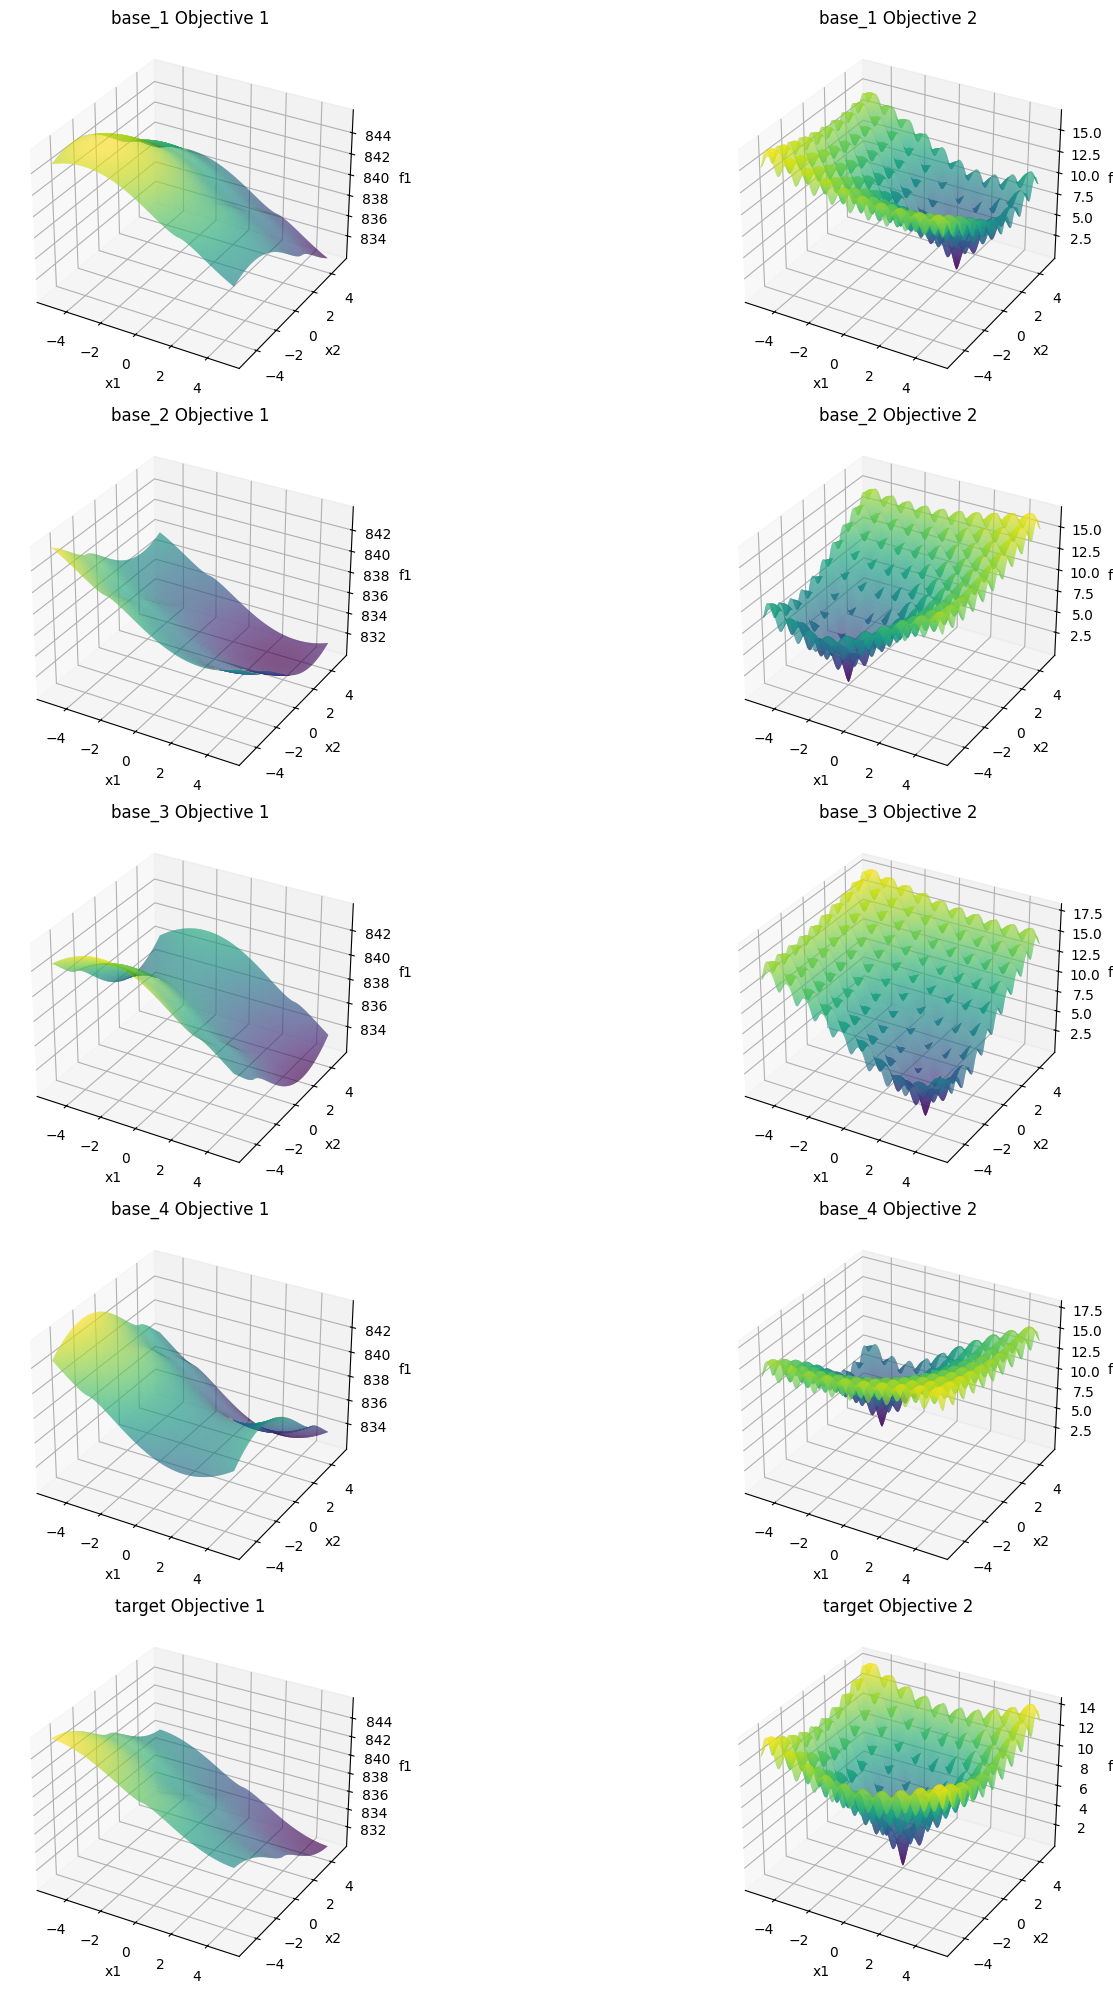

In [58]:
NUM_BASE_TASKS = 4

TARGET_SHIFT = 0.0 

shift_values = [[2, 2], [-2, -2], [3, -3], [-3, 3]]

# Define the Schwefel and Ackley functions using PyTorch operations
def schwefel(x, c):
    x_shifted = x - torch.tensor(c, dtype=x.dtype, device=x.device)
    return 418.9829 * x.size(1) - torch.sum(x_shifted * torch.sin(torch.sqrt(torch.abs(x_shifted))), dim=1)

def ackley(x, c):
    x_shifted = x - torch.tensor(c, dtype=x.dtype, device=x.device)
    part1 = -20 * torch.exp(-0.2 * torch.sqrt(0.5 * torch.sum(x_shifted**2, dim=1)))
    part2 = -torch.exp(0.5 * torch.sum(torch.cos(2 * torch.pi * x_shifted), dim=1))
    return part1 + part2 + 20 + torch.exp(torch.tensor(1.0, dtype=x.dtype, device=x.device))

# Define the base functions with different shift values
def base_1(x):
    c = shift_values[0]
    f1 = schwefel(x, c)
    f2 = ackley(x, c)
    return torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)

def base_2(x):
    c = shift_values[1]
    f1 = schwefel(x, c)
    f2 = ackley(x, c)
    return torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)

def base_3(x):
    c = shift_values[2]
    f1 = schwefel(x, c)
    f2 = ackley(x, c)
    return torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)

def base_4(x):
    c = shift_values[3]
    f1 = schwefel(x, c)
    f2 = ackley(x, c)
    return torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)

def target(x):
    c = [0, 0]
    f1 = schwefel(x, c)
    f2 = ackley(x, c)
    return torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)

# Define the range for the input x as a 2D tensor
x1 = torch.linspace(-5, 5, 400)
x2 = torch.linspace(-5, 5, 400)
x1, x2 = torch.meshgrid(x1, x2)
x = torch.stack([x1.flatten(), x2.flatten()], dim=1)

# Plot the functions
fig = plt.figure(figsize=(18, 20))
functions = [base_1, base_2, base_3, base_4, target]

for i, func in enumerate(functions):
    outputs = func(x)
    
    ax1 = fig.add_subplot(5, 2, 2*i+1, projection='3d')
    ax1.plot_trisurf(x[:, 0].numpy(), x[:, 1].numpy(), outputs[:, 0].numpy(), cmap='viridis', edgecolor='none')
    ax1.set_title(f'{func.__name__} Objective 1')
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    ax1.set_zlabel('f1')

    ax2 = fig.add_subplot(5, 2, 2*i+2, projection='3d')
    ax2.plot_trisurf(x[:, 0].numpy(), x[:, 1].numpy(), outputs[:, 1].numpy(), cmap='viridis', edgecolor='none')
    ax2.set_title(f'{func.__name__} Objective 2')
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x2')
    ax2.set_zlabel('f2')

plt.tight_layout()
plt.show()

In [ ]:
NUM_BASE_TASKS = 4

TARGET_SHIFT = 0.0



import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def base_1(x):
    # f1 = x[:, 0]
    # g = 1 + 9 * torch.sum(x[:, 1:], dim=1) / (x.size(1) - 1)
    # f2 = g * (1 - torch.sqrt(f1 / g))
    # return torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)

def base_2(x):
    # f1 = x[:, 0]
    # g = 1 + 9 * torch.sum(x[:, 1:], dim=1) / (x.size(1) - 1)
    # f2 = g * (1 - (f1 / g)**2)
    # return torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)

def base_3(x):
    # f1 = x[:, 0]
    # g = 1 + 9 * torch.sum(x[:, 1:], dim=1) / (x.size(1) - 1)
    # f2 = g * (1 - torch.sqrt(f1 / g) - (f1 / g) * torch.sin(10 * torch.pi * f1))
    # return torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)

def base_4(x):
    # f1 = x[:, 0]
    # g = 1 + 10 * (x.size(1) - 1) + torch.sum(x[:, 1:]**2 - 10 * torch.cos(4 * torch.pi * x[:, 1:]), dim=1)
    # f2 = g * (1 - torch.sqrt(f1 / g))
    # return torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)

def zdt6(x):
    f1 = 1 - torch.exp(-4 * x[:, 0]) * torch.sin(6 * torch.pi * x[:, 0])**6
    g = 1 + 9 * (torch.sum(x[:, 1:], dim=1) / (x.size(1) - 1))**0.25
    h = 1 - (f1 / g)**2
    f2 = g * h
    return torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)

# Define the range for the input x as a 2D tensor
x1 = torch.linspace(0.0, 1, 400)
x2 = torch.linspace(0.0, 1, 400)
x1, x2 = torch.meshgrid(x1, x2)
x = torch.stack([x1.flatten(), x2.flatten()], dim=1)

# Plot the functions
fig = plt.figure(figsize=(18, 20))

functions = [base_1, base_2, base_3, base_4, zdt6]

for i, func in enumerate(functions):
    outputs = func(x)
    
    ax1 = fig.add_subplot(5, 2, 2*i+1, projection='3d')
    ax1.plot_trisurf(x[:, 0].numpy(), x[:, 1].numpy(), outputs[:, 0].numpy(), cmap='viridis', edgecolor='none')
    ax1.set_title(f'Function {i+1}a')
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    ax1.set_zlabel(f'f1')

    ax2 = fig.add_subplot(5, 2, 2*i+2, projection='3d')
    ax2.plot_trisurf(x[:, 0].numpy(), x[:, 1].numpy(), outputs[:, 1].numpy(), cmap='viridis', edgecolor='none')
    ax2.set_title(f'Function {i+1}b')
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x2')
    ax2.set_zlabel(f'f2')

plt.tight_layout()
plt.show()


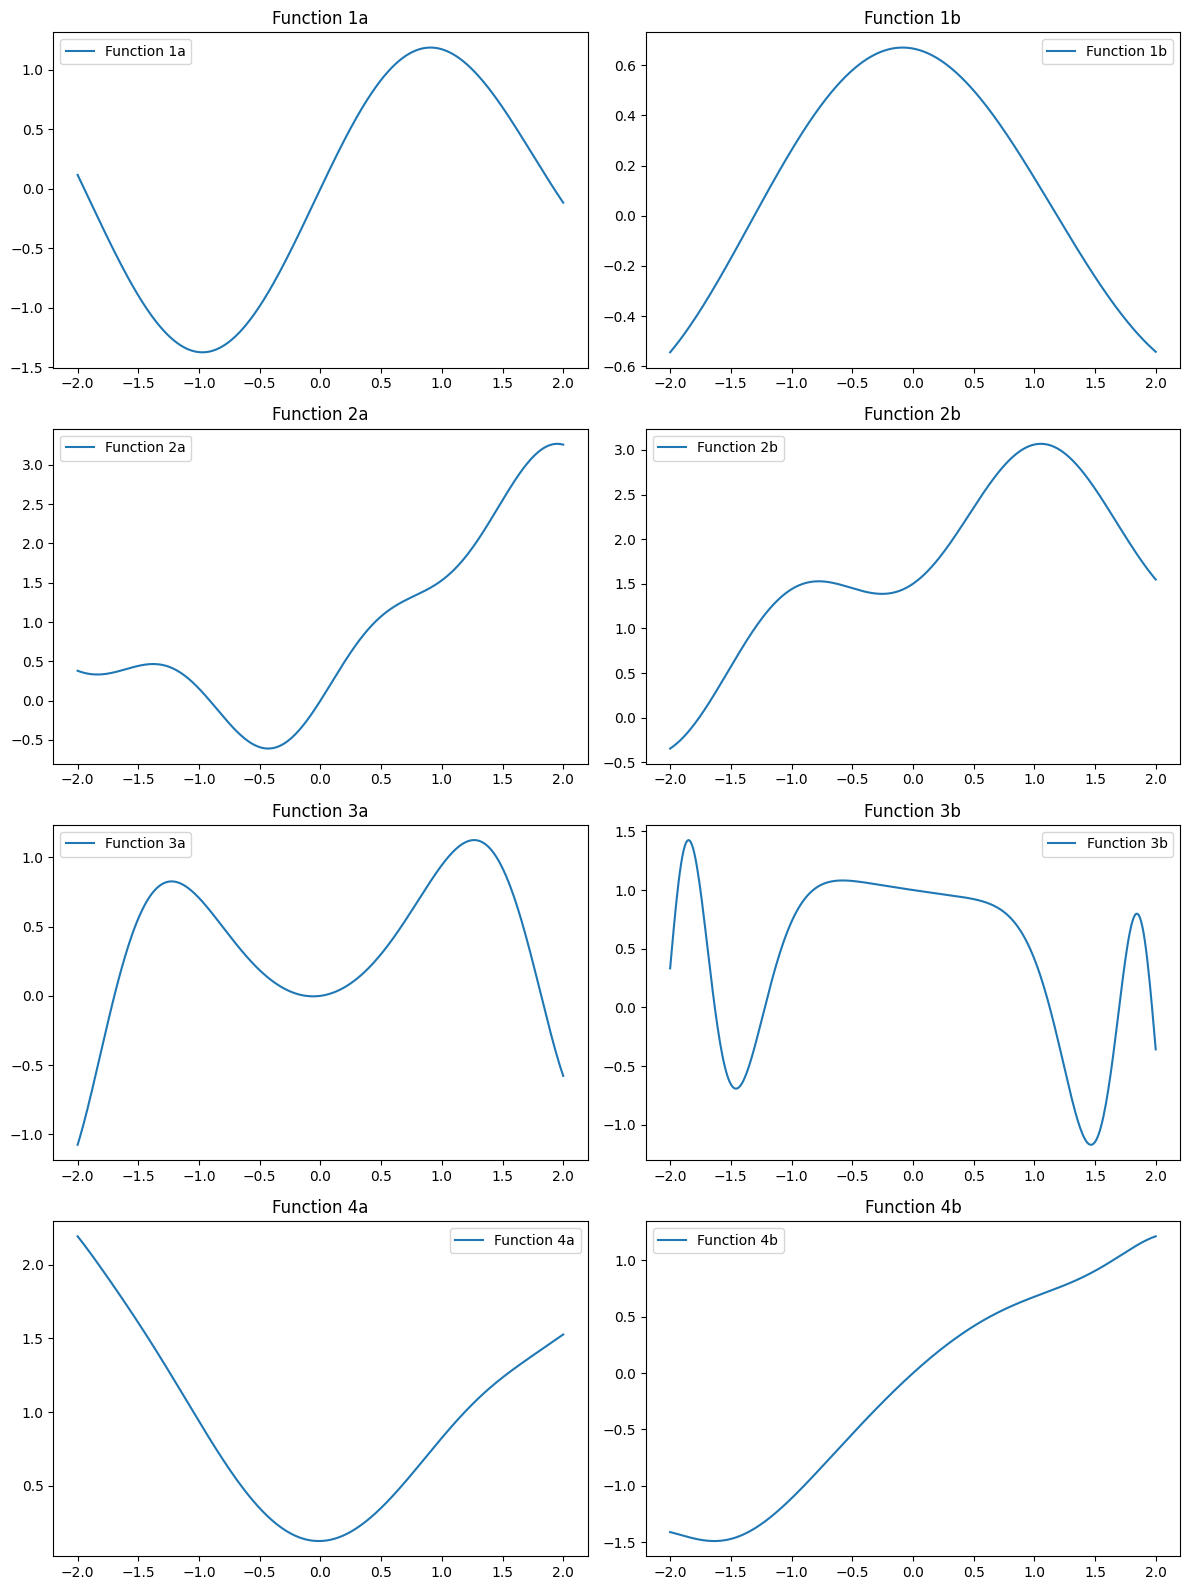

In [3]:
NUM_BASE_TASKS = 4
# set shift for target task
TARGET_SHIFT = 0.0 # (for default Alpine function)
# TARGET_SHIFT = 1.0 # (for Schaffer and others)

# Define the function sets with torch compatibility
def base_1(x):
    f1 = torch.sin(5 * torch.pi * x / 10) * torch.exp(-x / 10) + torch.sin(2 * torch.pi * x / 3) / 4 + x / 20
    f2 = torch.cos(4 * torch.pi * x / 10) * torch.exp(-x / 20) - torch.cos(2 * torch.pi * x / 5) / 3 - x / 25
    return torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)

def base_2(x):
    f1 = torch.sin(x) * (x + 1) + torch.sin(4 * x) / 3 + x / 10
    f2 = torch.cos(x / 2) * (x + 2) - torch.cos(3 * x) / 2 - x / 15
    return torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)

def base_3(x):
    f1 = torch.sin(x**2) + torch.tan(x / 12) * torch.exp(-x / 5) + x / 30
    f2 = torch.cos(x**3) - torch.tan(x / 8) * torch.exp(-x / 4) - x / 35
    return torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)

def base_4(x):
    f1 = x * torch.sin(3 * torch.pi * x / 10) * torch.exp(-x / 10) + torch.cos(x**2) / 8 + x / 40
    f2 = x * torch.cos(2 * torch.pi * x / 15) * torch.exp(-x / 12) - torch.sin(x**2) / 6 - x / 45
    return torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)

# Define the range for the input x starting from a small positive value
x = torch.linspace(-2, 2, 400)

# Plot the functions
fig, axes = plt.subplots(4, 2, figsize=(12, 16))

for i in range(1, 5):
    func = globals()[f"base_{i}"]
    outputs = func(x)
    
    # Plot first function of the pair
    axes[i-1, 0].plot(x.numpy(), outputs[:, 0].numpy(), label=f'Function {i}a')
    axes[i-1, 0].set_title(f'Function {i}a')
    axes[i-1, 0].legend()
    
    # Plot second function of the pair
    axes[i-1, 1].plot(x.numpy(), outputs[:, 1].numpy(), label=f'Function {i}b')
    axes[i-1, 1].set_title(f'Function {i}b')
    axes[i-1, 1].legend()

plt.tight_layout()
plt.show()

### DONT RUN THIS IF YOU RAN THE ABOVE CELL!!!!!!!!!!!!!!!

In [5]:
NUM_BASE_TASKS = 5 if not SMOKE_TEST else 2
# NUM_BASE_TASKS = 4 if not SMOKE_TEST else 2 # for unique base models


def task_shift(task):
    """
    Fetch shift amount for task.
    """
    return math.pi * task / 12.0

# shift values for other functions
shift_values = [-0.4, -0.2, 0.1, 0.2, 0.4]

# set shift for target task
TARGET_SHIFT = 0.0 # (for default Alpine function)
# TARGET_SHIFT = 1.0 # (for Schaffer and others)

Then, let's define our function $f(x, s_i)$ and set bounds on $x$.

In [6]:
BOUNDS = torch.tensor([[-10], [10.0]], dtype=dtype, device=device) # For default Alpine function
# BOUNDS = torch.tensor([[-2.0], [2.0]], dtype=dtype, device=device) # For three hump camel
# BOUNDS = torch.tensor([[0], [2.0]], dtype=dtype, device=device) # For Schaffer
# BOUNDS = torch.tensor([[0], [1.0]], dtype=dtype, device=device) # For ZDT1
# BOUNDS = torch.tensor([[-5.0], [5.0]], dtype=dtype, device=device) #for ackley and schwefel

def f(X, shift=TARGET_SHIFT):
    """
    Torch-compatible multi-objective function for the target_task
    """
    f1 = X * torch.sin(X + torch.pi + shift) + X / 10.0
    # f2 = X * torch.cos(X + torch.pi + shift) - X / 5.0
    f2 = X * torch.sin(X + torch.pi + shift) + X / 10.0 

    # # Three hump camel
    # f1 = -(2 * (X + shift)**2 - 1.05 * (X + shift)**4 + ((X + shift)**6) / 6)
    # f2 = -(2 * (X + 1 + shift)**2 - 1.05 * (X + 1 + shift)**4 + ((X + 1 + shift)**6) / 6)

    #zdt6
    # x = x + shift_values[0]
    # x[0] = x[0] + math.pi * 0  
    # f1 = X[:, 0]
    # g = 1 + 9 * torch.sum(X[:, 1:], dim=1) / (X.size(1) - 1)
    # f2 = g * (1 - torch.sqrt(f1 / g))
    # return torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)



    # def schwefel(x, c):
    #     x_shifted = x - torch.tensor(c, dtype=x.dtype, device=x.device)
    #     return 418.9829 * x.size(1) - torch.sum(x_shifted * torch.sin(torch.sqrt(torch.abs(x_shifted))), dim=1)

    # def ackley(x, c):
    #     x_shifted = x - torch.tensor(c, dtype=x.dtype, device=x.device)
    #     part1 = -20 * torch.exp(-0.2 * torch.sqrt(0.5 * torch.sum(x_shifted**2, dim=1)))
    #     part2 = -torch.exp(0.5 * torch.sum(torch.cos(2 * torch.pi * x_shifted), dim=1))
    #     return part1 + part2 + 20 + torch.exp(torch.tensor(1.0, dtype=x.dtype, device=x.device))

    # c = [0, 0]
    # f1 = schwefel(X, c)
    # f2 = ackley(X, c)
    # return torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)

    
    # # Schaffer
    # f1 = -(shift*X)**2
    # f2 = -(shift*X - 2)**2

    # # ZDT1
    # g = 1.0
    # h = 1.0 - shift*np.sqrt(X / g)
    # f1 = shift*X + 0.3*np.sin(5 * np.pi * X)
    # f2 = g * h + 0.3*np.cos(5 * np.pi * X)

    # f1 = -(3*(shift*X)**2 + 4*(shift*X) + 10)

    # f2 = -(5*(shift*X)**2 - 3*(shift*X) - 5)
    
    # f1 = -(X * shift)
    # f2 = -(1 - np.sqrt(X * shift))

    f_X = torch.cat([f1, f2], dim=-1)   # Stack the objectives along the last dimension
    return f_X

In [7]:
print(BOUNDS[0])

tensor([-10.], dtype=torch.float64)


In [110]:
# # If using different noise levels

# y_new[:,0] = y[:,0] + 0.07*torch.randn_like(y[:,0])
# y_new[:,1] = y[:,1] + 0.05*torch.randn_like(y[:,1])
# yvar[:,0] = torch.full_like(y[:,0], 0.07**2)
# yvar[:,1] = torch.full_like(y[:,1], 0.05**2)

#### Sample training data for prior base tasks

We sample data from a Sobol sequence to help ensure numerical stability when using a small amount of 1-D data. Sobol sequences help prevent us from sampling a bunch of training points that are close together.

In [8]:
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import normalize, unnormalize

noise_std = 0.05

# Sample data for each base task
data_by_task = {}
for task in range(NUM_BASE_TASKS):
    num_training_points = 20
    # draw points from a sobol sequence
    raw_x = draw_sobol_samples(
        bounds=BOUNDS,
        n=num_training_points,
        q=1,
        seed=task + 5397923,
    ).squeeze(1)
    # get observed values
    f_x = f(raw_x, task_shift(task + 1))
    train_y = f_x + noise_std * torch.randn_like(f_x)
    train_yvar = torch.full_like(train_y, noise_std**2)
    # store training data
    data_by_task[task] = {
    # scale x to [0, 1]
    "train_x": normalize(raw_x, bounds=BOUNDS),
    # "train_x": raw_x,
    "train_y": train_y,
    "train_yvar": train_yvar,
    }


# Schaffer function & others

# noise_std = 0.05

# # Sample data for each base task
# data_by_task = {}
# for task in range(NUM_BASE_TASKS):
#     num_training_points = 20
#     # draw points from a sobol sequence
#     raw_x = draw_sobol_samples(
#         bounds=BOUNDS,
#         n=num_training_points,
#         q=1,
#         seed=task + 5397923,
#     ).squeeze(1)
#     # get observed values
#     f_x = f(raw_x, shift_values[task])
#     train_y = f_x + noise_std * torch.randn_like(f_x)
#     train_yvar = torch.full_like(train_y, noise_std**2)
#     # store training data
#     data_by_task[task] = {
#     # scale x to [0, 1]
#     "train_x": normalize(raw_x, bounds=BOUNDS),
#     "train_y": train_y,
#     "train_yvar": train_yvar,
#     }

# #for unique base models

# noise_std = 0.05

# # Sample data for each base task
# data_by_task = {}
# for task in range(NUM_BASE_TASKS):
#     num_training_points = 20
#     # draw points from a sobol sequence
#     raw_x = draw_sobol_samples(
#         bounds=BOUNDS,
#         n=num_training_points,
#         q=2,
#         seed=task + 5397923,
#     ).squeeze()
#     # get observed values
#     func = globals()[f"base_{task + 1}"]
#     print(func.__name__)
#     f_x = func(raw_x).squeeze(-1)
#     f_x = torch.tensor(f_x)
#     train_y = f_x + noise_std * torch.randn_like(f_x)
#     train_yvar = torch.full_like(train_y, noise_std**2)
#     # store training data
#     data_by_task[task] = {
#     # scale x to [0, 1]
#     "train_x": normalize(raw_x, bounds=BOUNDS).to(torch.float64),
#     # "train_x":raw_x.to(torch.float64),
#     "train_y": train_y.to(torch.float64),
#     "train_yvar": train_yvar.to(torch.float64),
#     }

In [10]:
data_by_task[2]['train_y'].shape
# data_by_task[1]
# data_by_task[2]
# data_by_task[3]

torch.Size([20, 2])

#### Let's plot the base tasks and the target task function along with the observed points

base_1
base_2
base_3
base_4


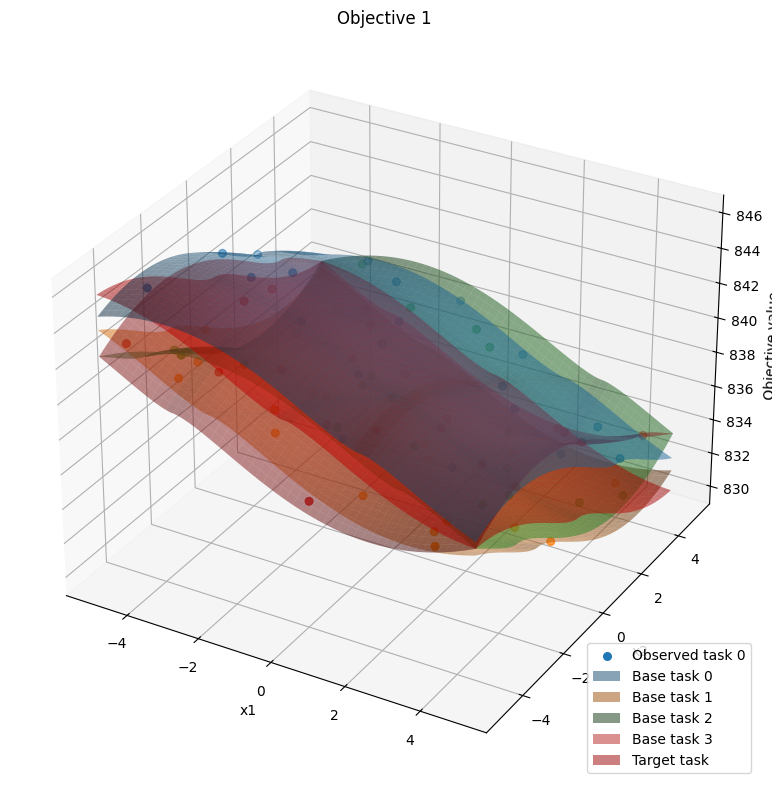

base_1
base_2
base_3
base_4


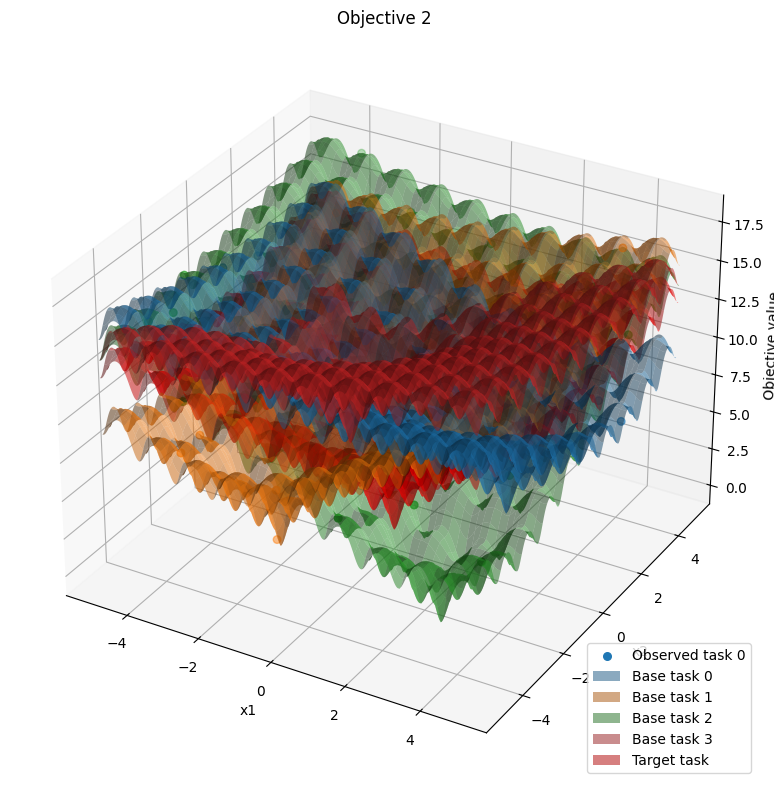

In [70]:
from matplotlib import pyplot as plt
x1 = torch.linspace(-5, 5, 400)
x2 = torch.linspace(-5, 5, 400)
x1, x2 = torch.meshgrid(x1, x2)
x = torch.stack([x1.flatten(), x2.flatten()], dim=1)

# Placeholder function for the target function

# TARGET_SHIFT = torch.tensor([0.1, 0.1])

for obj in range(2):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    for task in data_by_task:
        # Plot observed values
        train_x_unnormalized = unnormalize(data_by_task[task]["train_x"], bounds=BOUNDS).cpu().numpy()
        train_y = data_by_task[task]["train_y"][:, obj].cpu().numpy()
        t = ax.scatter(
            train_x_unnormalized[:, 0],
            train_x_unnormalized[:, 1],
            train_y,
            s=30,
            label=f"Observed task {task}" if task == 0 else "",
        )
        
        # Plot true function
        func = globals()[f"base_{task + 1}"]
        print(func.__name__)
        func_outputs = func(x)[:, obj].cpu().numpy().reshape(x1.shape)
        ax.plot_surface(
            x1.numpy(),
            x2.numpy(),
            func_outputs,
            color=t.get_facecolor()[0],
            alpha=0.5,
            label=f"Base task {task}",
        )
    
    # Plot true target function
    target_outputs = f(x, TARGET_SHIFT)[:, obj].detach().numpy().reshape(x1.shape)
    ax.plot_surface(
        x1.numpy(),
        x2.numpy(),
        target_outputs,
        color='r',
        alpha=0.5,
        linewidth=2,
        linestyle='--',
        label="Target task",
    )
    
    ax.set_title(f"Objective {obj + 1}")
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('Objective value')
    ax.legend(loc="lower right", fontsize=10)
    plt.tight_layout()
    # ax.set_zlim([-3, 3])
    plt.show()

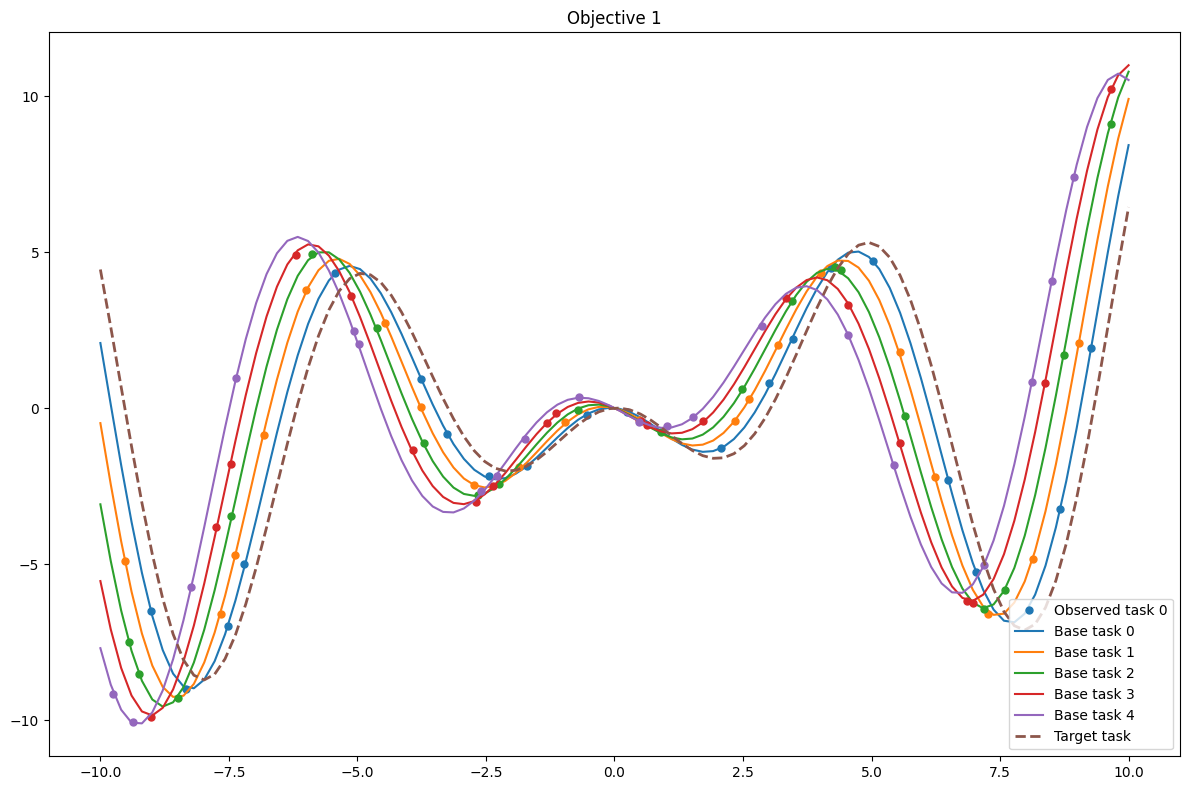

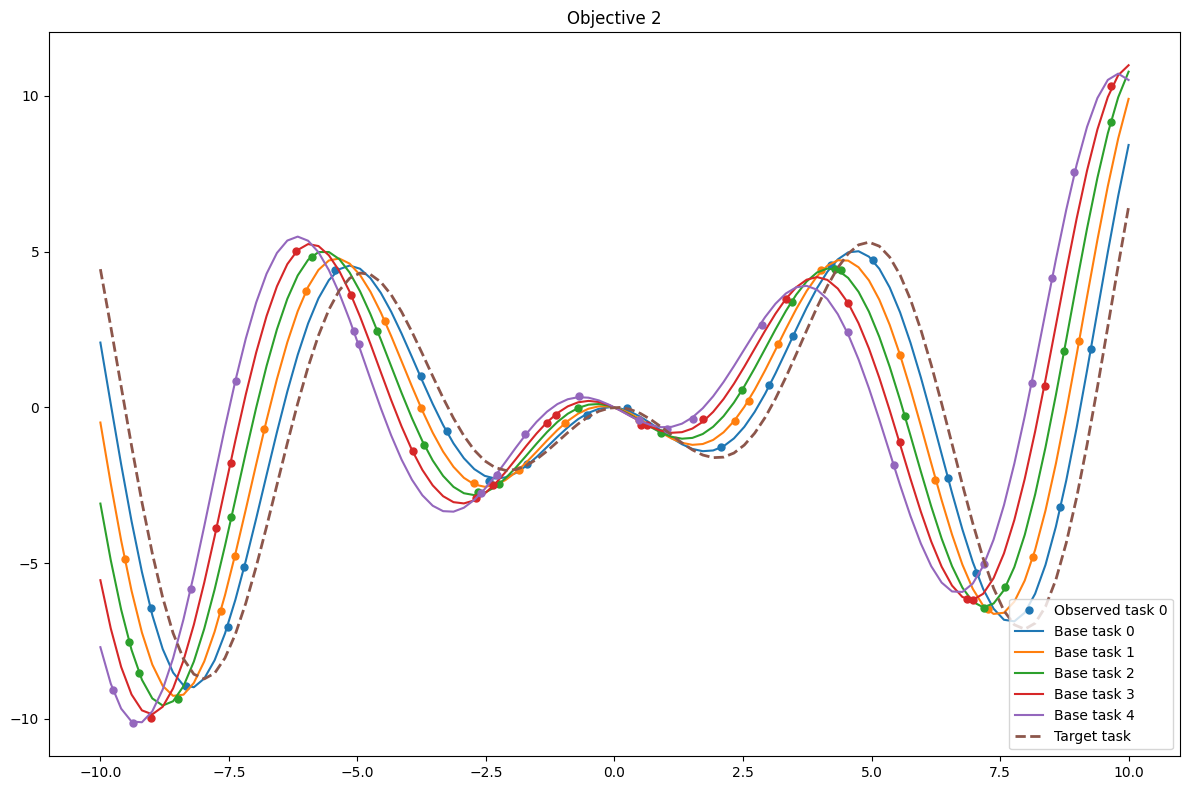

In [11]:
from matplotlib import pyplot as plt

# Plotting
x = torch.linspace(BOUNDS[0][0], BOUNDS[1][0], 100).unsqueeze(-1)

for obj in range(2):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    for task in data_by_task:
        # Plot observed values
        t = ax.plot(
            unnormalize(data_by_task[task]["train_x"], bounds=BOUNDS).cpu().numpy(),
            # data_by_task[task]["train_x"].cpu().numpy(),
            data_by_task[task]["train_y"][:, obj].cpu().numpy(),
            ".",
            markersize=10,
            label=f"Observed task {task}" if task == 0 else "",
        )
        # Plot true function
        ax.plot(
            x.detach().numpy(),
            f(x, task_shift(task + 1))[:, obj].cpu().numpy(),
            label=f"Base task {task}",
            color=t[0].get_color(),
        )
    # Plot true target function
    ax.plot(
        x.detach().numpy(),
        f(x, TARGET_SHIFT)[:, obj].detach().numpy(),
        "--",
        label="Target task",
        linewidth=2,
    )
    ax.set_title(f"Objective {obj + 1}")
    ax.legend(loc="lower right", fontsize=10)
    plt.tight_layout()
    plt.show()

# # Schaffer and others
# Plotting
# x = torch.linspace(BOUNDS[0][0], BOUNDS[1][0], 100).unsqueeze(-1)

# for obj in range(2):
#     fig, ax = plt.subplots(1, 1, figsize=(12, 8))
#     for task in data_by_task:
#         # Plot observed values
#         t = ax.plot(
#             unnormalize(data_by_task[task]["train_x"], bounds=BOUNDS).cpu().numpy(),
#             data_by_task[task]["train_y"][:, obj].cpu().numpy(),
#             ".",
#             markersize=10,
#             label=f"Observed task {task}" if task == 0 else "",
#         )
#         # Plot true function
#         ax.plot(
#             x.detach().numpy(),
#             f(x, shift_values[task])[:, obj].cpu().numpy(),
#             label=f"Base task {task}",
#             color=t[0].get_color(),
#         )
#     # Plot true target function
#     ax.plot(
#         x.detach().numpy(),
#         f(x, TARGET_SHIFT)[:, obj].detach().numpy(),
#         "--",
#         label="Target task",
#         linewidth=2,
#     )
#     ax.set_title(f"Objective {obj + 1}")
#     ax.legend(loc="lower right", fontsize=10)
#     plt.tight_layout()
#     plt.ylim([-3,0])
#     plt.show()

#plotting 

# x = torch.linspace(BOUNDS[0][0], BOUNDS[1][0], 100).unsqueeze(-1)

# for obj in range(2):
#     fig, ax = plt.subplots(1, 1, figsize=(12, 8))
#     for task in data_by_task:
#         # Plot observed values
#         t = ax.plot(
#             unnormalize(data_by_task[task]["train_x"], bounds=BOUNDS).cpu().numpy(),
#             data_by_task[task]["train_y"][:, obj].cpu().numpy(),
#             ".",
#             markersize=10,
#             label=f"Observed task {task}" if task == 0 else "",
#         )
#         # Plot true function
#         func = globals()[f"base_{task + 1}"]
#         print(func.__name__)
#         ax.plot(
#             x.detach().numpy(),
#             func(x)[:, obj].cpu().numpy(),
#             label=f"Base task {task}",
#             color=t[0].get_color(),
#         )
#     # Plot true target function
#     ax.plot(
#         x.detach().numpy(),
        
#         f(x, TARGET_SHIFT)[:, obj].detach().numpy(),
#         "--",
#         label="Target task",
#         linewidth=2,
#     )
#     ax.set_title(f"Objective {obj + 1}")
#     ax.legend(loc="lower right", fontsize=10)
#     plt.tight_layout()
#     plt.ylim([-3, 3])
#     plt.show()

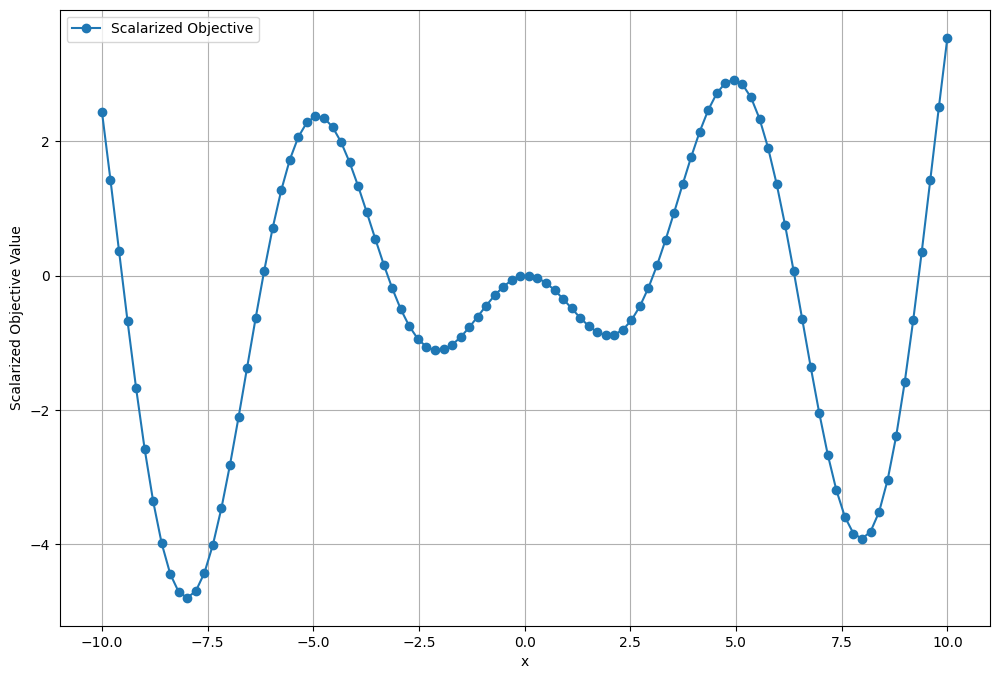

In [12]:
# Plot best observed scalarized value 

# Define the weights and alpha for the custom scalarization
weights = torch.tensor([0.5, 0.5])
alpha = 0.05

# Define the custom scalarization function with min and sum components
def custom_scalarization(x, weights, alpha=0.05):
    values = f(x, TARGET_SHIFT) 
    # values = -f(x) # for minimization 
    weighted_values = weights * values
    return weighted_values.min(dim=-1).values + alpha * weighted_values.sum(dim=-1)
    # return weighted_values.sum(dim = -1)

scalarized_objective = np.array([custom_scalarization(xi, weights, alpha) for xi in x])


# Plot the scalarized objectives
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plt.plot(x, scalarized_objective, label='Scalarized Objective', marker='o')
plt.xlabel('x')
plt.ylabel('Scalarized Objective Value')
plt.legend()
plt.grid(True)
plt.show()

### Fit base task models

First, let's define a helper function to fit a FixedNoiseGP with an fixed observed noise level.

In [45]:
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import FixedNoiseGP
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.kernels import RBFKernel,ScaleKernel
from gpytorch.priors import NormalPrior
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.constraints import Interval

# Fit model using fit_gpytorch_model
def get_fitted_model_SO(train_X, train_Y, train_Yvar, state_dict=None):
    """
    Get a single task GP. The model will be fit unless a state_dict with model
        hyperparameters is provided.
    """
    Y_mean = train_Y.mean(dim=-2, keepdim=True)
    Y_std = train_Y.std(dim=-2, keepdim=True)
    
    model = FixedNoiseGP(train_X, (train_Y - Y_mean) / Y_std, train_Yvar)
    
    model.Y_mean = Y_mean
    model.Y_std = Y_std
    
    if state_dict is None:
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)

    else:
        model.load_state_dict(state_dict)
    return model



# # Fit model using Adam optimizer
# def get_fitted_model_SO(train_X, train_Y, train_Yvar, state_dict=None):
#     """
#     Get a single task GP. The model will be fit unless a state_dict with model
#         hyperparameters is provided.
#     """
#     Y_mean = train_Y.mean(dim=-2, keepdim=True)
#     Y_std = train_Y.std(dim=-2, keepdim=True)
    
#     model = FixedNoiseGP(train_X, (train_Y - Y_mean) / Y_std, train_Yvar)
    
#     model.Y_mean = Y_mean
#     model.Y_std = Y_std

#     if state_dict is None:
#         # Optimize hyperparameters

#         # Set up the optimizer
#         parameters = list(model.parameters()) # + list(model.likelihood.parameters())
#         optimizer = torch.optim.Adam(parameters, lr=0.01)

#         # Training loop
#         for epoch in range(150):
            
#             optimizer.zero_grad()
            
#             output = model(train_X)
                
#             # Calculate Exact Marginal Log Likelihood (loss function) for the current model
#             mll = ExactMarginalLogLikelihood(model.likelihood, model)
#             loss = -mll(output, train_Y) 
                
#             # Backward pass 
#             # The backward() method is called on the scalar tensor. It computes the gradients of the loss function with 
#             # respect to each parameter of the model. 
#             loss.backward()
            
#             # Optimization step (Parameter update)
#             # Adjusts the model parameters in the opposite direction of the gradients to minimize the loss.
#             optimizer.step()
#     else:
#         model.load_state_dict(state_dict)
        
#     return model

In [44]:
import torch
from gpytorch.mlls import SumMarginalLogLikelihood
from botorch.models import FixedNoiseGP, ModelListGP
from botorch.fit import fit_gpytorch_model

# def get_fitted_model(train_x, train_y, state_dict=None, dimension=None):
#     """
#     Get a multi-objective GP model with standardized train_y. 
#     The model will be fit unless a state_dict with model hyperparameters is provided.
#     """
#     models = []
#     batch_shape = torch.Size([train_x.size(0)])
    
#     for i in range(train_y.shape[-1]):
#         train_objective = train_y[:, i]
        
#         # Standardize the training objective
#         Y_mean = train_objective.mean(dim=-1, keepdim=True)
#         Y_std = train_objective.std(dim=-1, keepdim=True)
#         standardized_train_objective = (train_objective - Y_mean) / Y_std
#         # print(standardized_train_objective)

#         # Single Task GP
#         model = SingleTaskGP(train_x, standardized_train_objective.unsqueeze(-1),covar_module=ScaleKernel(
#                 base_kernel=RBFKernel(ard_num_dims=dimension,lengthscale_prior=NormalPrior(0.4,0.56))
#                 ,outputscale_prior=NormalPrior(0.2,0.56)))
#         model.likelihood = GaussianLikelihood(noise_prior=NormalPrior(0.1,0.2),noise_constraint=Interval(0.00001,0.1))

        
#         # Store the mean and std for later unstandardization
#         model.Y_mean = Y_mean
#         model.Y_std = Y_std
#         models.append(model)

#     # Create a ModelListGP from the individual models
#     model = ModelListGP(*models)
    
#     if state_dict is None:
#         mll = SumMarginalLogLikelihood(model.likelihood, model)
#         model.train()  # Set model to training mode
#         fit_gpytorch_model(mll)
#     else:
#         model = SingleTaskGP(train_x, (train_y - Y_mean)/Y_std,covar_module=ScaleKernel(batch_shape=batch_shape,
#                     base_kernel=RBFKernel(ard_num_dims=dimension,batch_shape=batch_shape,lengthscale_prior=NormalPrior(0.4,0.56))
#                     ,outputscale_prior=NormalPrior(0.2,0.56)))
#         model.likelihood=GaussianLikelihood(noise_prior=NormalPrior(0.1,0.2),noise_constraint=Interval(0.00001,0.1),batch_shape=batch_shape)
#         model.load_state_dict(state_dict)
    
#     return model


    
# # # Get fitted model with Adam optimizer
# # def get_fitted_model(train_x, train_y, state_dict=None, dimension=None):
# #     """
# #     Get a multi-objective GP model with standardized train_y. 
# #     The model will be fit unless a state_dict with model hyperparameters is provided.
# #     """
# #     models = []
# #     mll_values = []
    
# #     for i in range(train_y.shape[-1]):
# #         train_objective = train_y[:, i]
        
# #         # Standardize the training objective
# #         Y_mean = train_objective.mean(dim=-1, keepdim=True)
# #         Y_std = train_objective.std(dim=-1, keepdim=True)
# #         standardized_train_objective = (train_objective - Y_mean) / Y_std

# #         # Single Task GP
# #         model = SingleTaskGP(train_x, (train_y - Y_mean)/Y_std,covar_module=ScaleKernel(
# #                 base_kernel=RBFKernel(ard_num_dims=dimension,lengthscale_prior=NormalPrior(0.4,0.56))
# #                 ,outputscale_prior=NormalPrior(0.2,0.56)))
# #         model.likelihood = GaussianLikelihood(noise_prior=NormalPrior(0.1,0.2),noise_constraint=Interval(0.00001,0.1))
        
# #         # Store the mean and std for later unstandardization
# #         model.Y_mean = Y_mean
# #         model.Y_std = Y_std

# #         if state_dict is None:
# #             # Optimize hyperparameters

# #             # Set up the optimizer
# #             # parameters = list(model.parameters()) 
# #             parameters = list(model.parameters()) + list(model.likelihood.parameters())
# #             optimizer = torch.optim.Adam(parameters, lr=0.01)
    
# #             # Training loop
# #             for epoch in range(150):
                
# #                 optimizer.zero_grad()
                
# #                 output = model(train_x)
                    
# #                 # Calculate Exact Marginal Log Likelihood (loss function) for the current model
# #                 mll = ExactMarginalLogLikelihood(model.likelihood, model)
# #                 loss = -mll(output, train_y[:, i]) 
                    
# #                 # Backward pass 
# #                 # The backward() method is called on the scalar tensor. It computes the gradients of the loss function with 
# #                 # respect to each parameter of the model. 
# #                 loss.backward()
                
# #                 # Optimization step (Parameter update)
# #                 # Adjusts the model parameters in the opposite direction of the gradients to minimize the loss.
# #                 optimizer.step()
                    
# #         else:
# #             # Load the state_dict
# #             model.load_state_dict(state_dict)

# #         model.eval()   # Set model to evaluation mode
# #         mll.eval()     # Set mll to evaluation mode

# #         with torch.no_grad():
# #             # Evaluate the marginal log likelihood on the training data
# #             output = model(*model.train_inputs)
# #             mll_value = mll(output, model.train_targets).item()
# #         mll_values.append(mll_value)
# #         # Switch back to training mode to avoid warnings during subsequent training steps
# #         model.train()
# #         mll.train()
        
# #         models.append(model)
    
# #     # Create a ModelListGP from the individual models
# #     model = ModelListGP(*models)
# #     # print(f'returning mll_values: {mll_values}')
# #     return model, mll_values

# import torch
# from gpytorch.mlls import SumMarginalLogLikelihood
# from botorch.models import FixedNoiseGP, ModelListGP
# from botorch.fit import fit_gpytorch_model
 
def get_fitted_model(train_x, train_y, train_Yvar, state_dict=None):
    """
    Get a multi-objective GP model with standardized train_y. 
    The model will be fit unless a state_dict with model hyperparameters is provided.
    """
    models = []
    
    for i in range(train_y.shape[-1]):
        train_objective = train_y[:, i]
        train_Yvar_objective = train_Yvar[:, i]
        
        # Standardize the training objective
        Y_mean = train_objective.mean(dim=-1, keepdim=True)
        Y_std = train_objective.std(dim=-1, keepdim=True)
        standardized_train_objective = (train_objective - Y_mean) / Y_std
        
        # Fixed Noise GP
        model = FixedNoiseGP(train_x, standardized_train_objective.unsqueeze(-1), train_Yvar_objective.unsqueeze(-1))
        
        # Store the mean and std for later unstandardization
        model.Y_mean = Y_mean
        model.Y_std = Y_std
        models.append(model)

    # Create a ModelListGP from the individual models
    model = ModelListGP(*models)
    
    if state_dict is None:
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_model(mll)
    else:
        model.load_state_dict(state_dict)
    
    return model


    
# # Get fitted model with Adam optimizer
# def get_fitted_model(train_x, train_y, train_Yvar, state_dict=None):
#     """
#     Get a multi-objective GP model with standardized train_y. 
#     The model will be fit unless a state_dict with model hyperparameters is provided.
#     """
    
#     for i in range(train_y.shape[-1]):
#         train_objective = train_y[:, i]
#         train_Yvar_objective = train_Yvar[:, i]
        
#         # Standardize the training objective
#         Y_mean = train_objective.mean(dim=-1, keepdim=True)
#         Y_std = train_objective.std(dim=-1, keepdim=True)
#         standardized_train_objective = (train_objective - Y_mean) / Y_std
        
#         # Fixed Noise GP
#         model = FixedNoiseGP(train_x, standardized_train_objective.unsqueeze(-1), train_Yvar_objective.unsqueeze(-1))

#         # Store the mean and std for later unstandardization
#         model.Y_mean = Y_mean
#         model.Y_std = Y_std

#         if state_dict is None:
#             # Optimize hyperparameters

#             # Set up the optimizer
#             parameters = list(model.parameters()) #+ list(model.likelihood.parameters())
#             optimizer = torch.optim.Adam(parameters, lr=0.01)
    
#             # Training loop
#             for epoch in range(150):
                
#                 optimizer.zero_grad()
                
#                 output = model(train_x)
                    
#                 # Calculate Exact Marginal Log Likelihood (loss function) for the current model
#                 mll = ExactMarginalLogLikelihood(model.likelihood, model)
#                 loss = -mll(output, train_y[:, i]) 
                    
#                 # Backward pass 
#                 # The backward() method is called on the scalar tensor. It computes the gradients of the loss function with 
#                 # respect to each parameter of the model. 
#                 loss.backward()
                
#                 # Optimization step (Parameter update)
#                 # Adjusts the model parameters in the opposite direction of the gradients to minimize the loss.
#                 optimizer.step()
                    
#         else:
#             # Load the state_dict
#             model.load_state_dict(state_dict)
        
#         models.append(model)
    
#     # Create a ModelListGP from the individual models
#     model = ModelListGP(*models)
    
#     return model

#### Now let's fit a FixedNoiseGP for each base task

In [46]:
# Fit base model
base_model_list = []
for task in range(NUM_BASE_TASKS):
    print(f"Fitting base model {task}")
    # model, _ = get_fitted_model(
    model = get_fitted_model(
        data_by_task[task]["train_x"],
        data_by_task[task]["train_y"],
        data_by_task[task]["train_yvar"],
    )
    base_model_list.append(model)

Fitting base model 0
Fitting base model 1
Fitting base model 2
Fitting base model 3
Fitting base model 4


In [16]:
print(base_model_list[0].models[1])

FixedNoiseGP(
  (likelihood): FixedNoiseGaussianLikelihood(
    (noise_covar): FixedGaussianNoise()
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
)


### Implement the RGPE

The main idea of the RGPE is to estimate the target function as weighted sum of the target model and the base models:
$$\bar f(\mathbf x | \mathcal D) =
\sum_{i=1}^{t} w_if^i(\mathbf x |\mathcal D_i)$$
Importantly, the ensemble model is also a GP:
$$\bar f(\mathbf x | \mathcal D) \sim \mathcal N\bigg(\sum_{i=1}^{t} w_i\mu_i(\mathbf x), \sum_{i=1}^{t}w_i^2\sigma_i^2\bigg)$$

The weights $w_i$ for model $i$ are based on the the ranking loss between a draw from the model's posterior and the targets. Specifically, the ranking loss for model $i$ is:
$$\mathcal L(f^i, \mathcal D_t) = \sum_{j=1}^{n_t}\sum_{k=1}^{n_t}\mathbb 1\bigg[\bigg(f^i\big(\mathbf x^t_j\big) < f^i\big(\mathbf x_k^t\big)\bigg)\oplus \big(y_j^t < y_k^t\big)\bigg]$$
where $\oplus$ is exclusive-or.

The loss for the target model is computing using leave-one-out cross-validation (LOOCV) and is given by:
$$\mathcal L(f^t, \mathcal D_t) = \sum_{j=1}^{n_t}\sum_{k=1}^{n_t}\mathbb 1\bigg[\bigg(f^t_{-j}\big(\mathbf x^t_j\big) < f^t_{-j}\big(\mathbf x_k^t\big)\bigg)\oplus \big(y_j^t < y_k^t\big)\bigg]$$
where $f^t_{-j}$ model fitted to all data from the target task except training example $j$.

The weights are then computed as:
$$w_i = \frac{1}{S}\sum_{s=1}^S\mathbb 1\big(i = \text{argmin}_{i'}l_{i', s}\big)$$

In [17]:
def roll_col(X, shift):
    """
    Rotate columns to right by shift.
    """
    return torch.cat((X[..., -shift:], X[..., :-shift]), dim=-1)

In [18]:
def compute_ranking_loss(f_samps, target_y):
    """
    Compute ranking loss for each sample from the posterior over target points.

    Args:
        f_samps: `n_samples x (n) x n`-dim tensor of samples
        target_y: `n x 1`-dim tensor of targets
    Returns:
        Tensor: `n_samples`-dim tensor containing the ranking loss across each sample
    """
    n = target_y.shape[0]
    if f_samps.ndim == 3:
        # Compute ranking loss for target model
        # take cartesian product of target_y
        cartesian_y = torch.cartesian_prod(
            target_y.squeeze(-1),
            target_y.squeeze(-1),
        ).view(n, n, 2)
        # the diagonal of f_samps are the out-of-sample predictions
        # for each LOO model, compare the out of sample predictions to each in-sample prediction
        rank_loss = (
            (
                (f_samps.diagonal(dim1=1, dim2=2).unsqueeze(-1) < f_samps)
                ^ (cartesian_y[..., 0] < cartesian_y[..., 1])
            )
            .sum(dim=-1)
            .sum(dim=-1)
        )
    else:
        rank_loss = torch.zeros(
            f_samps.shape[0], dtype=torch.long, device=target_y.device
        )
        y_stack = target_y.squeeze(-1).expand(f_samps.shape)
        for i in range(1, target_y.shape[0]):
            rank_loss += (
                (roll_col(f_samps, i) < f_samps) ^ (roll_col(y_stack, i) < y_stack)
            ).sum(dim=-1)
    return rank_loss

Define a function to:
1. Create a batch mode-gp LOOCV GP using the hyperparameters from `target_model`
2. Draw a joint sample across all points from the target task (in-sample and out-of-sample)

In [19]:
def get_target_model_loocv_sample_preds(
    train_x, train_y, train_yvar, target_model, num_samples
):
    """
    Create a batch-mode LOOCV GP and draw a joint sample across all points from the target task.

    Args:
        train_x: `n x d` tensor of training points
        train_y: `n x 1` tensor of training targets
        target_model: fitted target model
        num_samples: number of mc samples to draw

    Return: `num_samples x n x n`-dim tensor of samples, where dim=1 represents the `n` LOO models,
        and dim=2 represents the `n` training points.
    """
    batch_size = len(train_x)
    masks = torch.eye(len(train_x), dtype=torch.uint8, device=device).bool()
    train_x_cv = torch.stack([train_x[~m] for m in masks])
    train_y_cv = torch.stack([train_y[~m] for m in masks])
    train_yvar_cv = torch.stack([train_yvar[~m] for m in masks])
    state_dict = target_model.state_dict()
    # expand to batch size of batch_mode LOOCV model
    state_dict_expanded = {
        name: t.expand(batch_size, *[-1 for _ in range(t.ndim)])
        for name, t in state_dict.items()
    }
    model = get_fitted_model_SO(
        train_x_cv, train_y_cv, train_yvar_cv, state_dict=state_dict_expanded
    )
    with torch.no_grad():
        posterior = model.posterior(train_x)
        # Since we have a batch mode gp and model.posterior always returns an output dimension,
        # the output from `posterior.sample()` here `num_samples x n x n x 1`, so let's squeeze
        # the last dimension.
        sampler = SobolQMCNormalSampler(sample_shape=torch.Size([num_samples]))
        return sampler(posterior).squeeze(-1)

In [20]:
def compute_rank_weights(train_x, train_y, train_yvar, base_models, target_model, num_samples):
    """
    Compute ranking weights for each base model and the target model (using
        LOOCV for the target model). Note: This implementation does not currently
        address weight dilution, since we only have a small number of base models.

    Args:
        train_x: `n x d` tensor of training points (for target task)
        train_y: `n` tensor of training targets (for target task)
        base_models: list of base models
        target_model: target model
        num_samples: number of mc samples

    Returns:
        Tensor: `n_t`-dim tensor with the ranking weight for each model
    """
    ranking_losses = []
    # compute ranking loss for each base model
    for task in range(len(base_models)):
        model = base_models[task]
        # compute posterior over training points for target task
        posterior = model.posterior(train_x)
        sampler = SobolQMCNormalSampler(sample_shape=torch.Size([num_samples]))
        base_f_samps = sampler(posterior).squeeze(-1).squeeze(-1)
        # compute and save ranking loss
        ranking_losses.append(compute_ranking_loss(base_f_samps, train_y))
    # compute ranking loss for target model using LOOCV
    # f_samps
    target_f_samps = get_target_model_loocv_sample_preds(
        train_x,
        train_y,
        train_yvar,
        target_model,
        num_samples,
    )
    ranking_losses.append(compute_ranking_loss(target_f_samps, train_y))
    # print(ranking_losses)
    ranking_loss_tensor = torch.stack(ranking_losses)
    # compute best model (minimum ranking loss) for each sample
    best_models = torch.argmin(ranking_loss_tensor, dim=0)
    # compute proportion of samples for which each model is best
    rank_weights = (
        best_models.bincount(minlength=len(ranking_losses)).type_as(train_x)
        / num_samples
    )
    return rank_weights

In [21]:
from botorch.models.gpytorch import GPyTorchModel
from gpytorch.models import GP
from gpytorch.distributions import MultivariateNormal
from gpytorch.lazy import PsdSumLazyTensor
from gpytorch.likelihoods import LikelihoodList
from torch.nn import ModuleList


class RGPE(GP, GPyTorchModel):
    """
    Rank-weighted GP ensemble. Note: this class inherits from GPyTorchModel which provides an
        interface for GPyTorch models in botorch.
    """

    _num_outputs = 1  # metadata for botorch

    def __init__(self, models, weights):
        super().__init__()
        self.models = ModuleList(models)
        for m in models:
            if not hasattr(m, "likelihood"):
                raise ValueError(
                    "RGPE currently only supports models that have a likelihood (e.g. ExactGPs)"
                )
        self.likelihood = LikelihoodList(*[m.likelihood for m in models])
        self.weights = weights
        self.to(weights)

    def forward(self, x):
        weighted_means = []
        weighted_covars = []
        # filter model with zero weights
        # weights on covariance matrices are weight**2
        non_zero_weight_indices = (self.weights**2 > 0).nonzero()
        non_zero_weights = self.weights[non_zero_weight_indices]
        # re-normalize
        non_zero_weights /= non_zero_weights.sum()

        for non_zero_weight_idx in range(non_zero_weight_indices.shape[0]):
            raw_idx = non_zero_weight_indices[non_zero_weight_idx].item()
            model = self.models[raw_idx]
            posterior = model.posterior(x)
            # # unstandardize predictions
            posterior_mean = posterior.mean.squeeze(-1) * model.Y_std + model.Y_mean
            posterior_cov = posterior.mvn.lazy_covariance_matrix * model.Y_std.pow(2)
            # posterior_mean = posterior.mean.squeeze(-1)
            # posterior_cov = posterior.mvn.lazy_covariance_matrix
            
            # apply weight
            weight = non_zero_weights[non_zero_weight_idx]
            weighted_means.append(weight * posterior_mean)
            weighted_covars.append(posterior_cov * weight**2)
        # set mean and covariance to be the rank-weighted sum the means and covariances of the
        # base models and target model
        mean_x = torch.stack(weighted_means).sum(dim=0)
        covar_x = PsdSumLazyTensor(*weighted_covars)
        return MultivariateNormal(mean_x, covar_x)

In [22]:
from torch import Tensor
def get_chebyshev_scalarization_unnormalized(weights: Tensor, Y: Tensor, alpha: float = 0.05):
    r"""Construct an augmented Chebyshev scalarization.

    Augmented Chebyshev scalarization:
        objective(y) = min(w * y) + alpha * sum(w * y)

    Outcomes are first normalized to [0,1] for maximization (or [-1,0] for minimization)
    and then an augmented Chebyshev scalarization is applied.

    Note: this assumes maximization of the augmented Chebyshev scalarization.
    Minimizing/Maximizing an objective is supported by passing a negative/positive
    weight for that objective. To make all w * y's have positive sign
    such that they are comparable when computing min(w * y), outcomes of minimization
    objectives are shifted from [0,1] to [-1,0].

    See [Knowles2005]_ for details.

    This scalarization can be used with qExpectedImprovement to implement q-ParEGO
    as proposed in [Daulton2020qehvi]_.

    Args:
        weights: A `m`-dim tensor of weights.
            Positive for maximization and negative for minimization.
        Y: A `n x m`-dim tensor of observed outcomes, which are used for
            scaling the outcomes to [0,1] or [-1,0].
        alpha: Parameter governing the influence of the weighted sum term. The
            default value comes from [Knowles2005]_.

    Returns:
        Transform function using the objective weights.

    Example:
        >>> weights = torch.tensor([0.75, -0.25])
        >>> transform = get_aug_chebyshev_scalarization(weights, Y)
    """
    if weights.shape != Y.shape[-1:]:
        raise BotorchTensorDimensionError(
            "weights must be an `m`-dim tensor where Y is `... x m`."
            f"Got shapes {weights.shape} and {Y.shape}."
        )
    elif Y.ndim > 2:
        raise NotImplementedError("Batched Y is not currently supported.")

   # def chebyshev_obj(Y: Tensor, X: Optional[Tensor] = None) -> Tensor:
    def chebyshev_obj(Y: Tensor) -> Tensor:
        product = weights * Y
        return product.min(dim=-1).values + alpha * product.sum(dim=-1)

    if Y.shape[-2] == 0:
        # If there are no observations, we do not need to normalize the objectives
        return chebyshev_obj
    if Y.shape[-2] == 1:
        # If there is only one observation, set the bounds to be
        # [min(Y_m), min(Y_m) + 1] for each objective m. This ensures we do not
        # divide by zero
        Y_bounds = torch.cat([Y, Y + 1], dim=0)
    else:
        # Set the bounds to be [min(Y_m), max(Y_m)], for each objective m
        Y_bounds = torch.stack([Y.min(dim=-2).values, Y.max(dim=-2).values])

    # A boolean mask indicating if minimizing an objective
    minimize = weights < 0

    # def obj(Y: Tensor, X: Optional[Tensor] = None) -> Tensor:
    def obj(Y: Tensor) -> Tensor:
        # scale to [0,1]
        # Y_normalized = normalize(Y, bounds=Y_bounds)
        # # If minimizing an objective, convert Y_normalized values to [-1,0],
        # # such that min(w*y) makes sense, we want all w*y's to be positive
        # Y_normalized[..., minimize] = Y_normalized[..., minimize] - 1
        return chebyshev_obj(Y=Y)

    return obj

In [23]:
def get_weighted_sum(weights: Tensor, Y: Tensor):
    r"""Construct an augmented Chebyshev scalarization.

    Augmented Chebyshev scalarization:
        objective(y) = min(w * y) + alpha * sum(w * y)

    Outcomes are first normalized to [0,1] for maximization (or [-1,0] for minimization)
    and then an augmented Chebyshev scalarization is applied.

    Note: this assumes maximization of the augmented Chebyshev scalarization.
    Minimizing/Maximizing an objective is supported by passing a negative/positive
    weight for that objective. To make all w * y's have positive sign
    such that they are comparable when computing min(w * y), outcomes of minimization
    objectives are shifted from [0,1] to [-1,0].

    See [Knowles2005]_ for details.

    This scalarization can be used with qExpectedImprovement to implement q-ParEGO
    as proposed in [Daulton2020qehvi]_.

    Args:
        weights: A `m`-dim tensor of weights.
            Positive for maximization and negative for minimization.
        Y: A `n x m`-dim tensor of observed outcomes, which are used for
            scaling the outcomes to [0,1] or [-1,0].
        alpha: Parameter governing the influence of the weighted sum term. The
            default value comes from [Knowles2005]_.

    Returns:
        Transform function using the objective weights.

    Example:
        >>> weights = torch.tensor([0.75, -0.25])
        >>> transform = get_aug_chebyshev_scalarization(weights, Y)
    """
    if weights.shape != Y.shape[-1:]:
        raise BotorchTensorDimensionError(
            "weights must be an `m`-dim tensor where Y is `... x m`."
            f"Got shapes {weights.shape} and {Y.shape}."
        )
    elif Y.ndim > 2:
        raise NotImplementedError("Batched Y is not currently supported.")

    def chebyshev_obj(Y: Tensor) -> Tensor:
        product = weights * Y
        # return product.min(dim=-1).values + alpha * product.sum(dim=-1)
        return product.sum(dim=-1)
    if Y.shape[-2] == 0:
        # If there are no observations, we do not need to normalize the objectives
        return chebyshev_obj
    if Y.shape[-2] == 1:
        # If there is only one observation, set the bounds to be
        # [min(Y_m), min(Y_m) + 1] for each objective m. This ensures we do not
        # divide by zero
        Y_bounds = torch.cat([Y, Y + 1], dim=0)
    else:
        # Set the bounds to be [min(Y_m), max(Y_m)], for each objective m
        Y_bounds = torch.stack([Y.min(dim=-2).values, Y.max(dim=-2).values])

    # A boolean mask indicating if minimizing an objective
    minimize = weights < 0

    def obj(Y: Tensor) -> Tensor:
        # scale to [0,1]
        Y_normalized = normalize(Y, bounds=Y_bounds)
        # If minimizing an objective, convert Y_normalized values to [-1,0],
        # such that min(w*y) makes sense, we want all w*y's to be positive
        Y_normalized[..., minimize] = Y_normalized[..., minimize] - 1
        return chebyshev_obj(Y=Y_normalized)

    return obj


In [29]:
pip show botorch

Name: botorch
Version: 0.9.5
Summary: Bayesian Optimization in PyTorch
Home-page: https://botorch.org
Author: Meta Platforms, Inc.
Author-email: 
License: MIT
Location: c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages
Requires: gpytorch, linear-operator, multipledispatch, pyro-ppl, scipy, torch
Required-by: 
Note: you may need to restart the kernel to use updated packages.


### Optimize target function using RGPE + qNEI

In [ ]:
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
#from botorch.acquisition.objective import ChebyshevScalarization
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.models import ModelListGP, SingleTaskGP
from botorch.sampling import SobolQMCNormalSampler
from botorch.sampling import IIDNormalSampler
from botorch.optim.optimize import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.sampling import sample_simplex
from botorch.acquisition.objective import GenericMCObjective
import torch
import warnings

# suppress GPyTorch warnings about adding jitter
import warnings


warnings.filterwarnings("ignore", "^.*jitter.*", category=RuntimeWarning)


# Subscripts _1 and _2 represent objectives 1 and 2 respectively

best_rgpe_all_1 = []
best_rgpe_all_2 = []
best_vanilla_nei_all_1 = []
best_vanilla_nei_all_2 = []
rank_weights_all_1 = []
rank_weights_all_2 = []

# mll_values_total = []
# mll_values_vanilla_total = []
hyperparameters_total = []
hyperparameters_vanilla_total = []

rgpe_models = []
rgpe_target_models = []
vanilla_models = []

N_BATCH = 20 if not SMOKE_TEST else 2
NUM_POSTERIOR_SAMPLES = 256 if not SMOKE_TEST else 16
RANDOM_INITIALIZATION_SIZE = 3
N_TRIALS = 8 # 10 if not SMOKE_TEST else 2
MC_SAMPLES = 512 if not SMOKE_TEST else 32
N_RESTART_CANDIDATES = 512 if not SMOKE_TEST else 8
N_RESTARTS = 10 if not SMOKE_TEST else 2
Q_BATCH_SIZE = 1
SHIFT_OBJ_ITER = 6 #change this if you want to change the objective
SHIFT_VALUE = 8.0 #change this to specify the amount to shift with


best_rgpe_inputs_1 = []
best_rgpe_inputs_2 = []
best_vanilla_nei_inputs_1 = []
best_vanilla_nei_inputs_2 = []
best_scalarized_rgpe_values_total = []
best_scalarized_rgpe_params_total = []
best_scalarized_vanilla_values_total = []
best_scalarized_vanilla_params_total = []

# Average over multiple trials
for trial in range(N_TRIALS):
    print(f"Trial {trial + 1} of {N_TRIALS}")
    best_rgpe_1 = []
    best_rgpe_2 = []
    best_rgpe_input_1 = []
    best_rgpe_input_2 = []
    best_vanilla_nei_1 = []
    best_vanilla_nei_2 = []
    best_vanilla_nei_input_1 = []
    best_vanilla_nei_input_2 = []
    rank_weights_list_1 = []
    rank_weights_list_2 = []
    mll_values_trial = []
    mll_values_vanilla_trial = []
    hyperparameters_list = []
    hyperparameters_vanilla_list = []
    best_scalarized_vanilla_values = []
    best_scalarized_rgpe_values = []
    best_scalarized_rgpe_params = []
    best_scalarized_vanilla_params = []
    
    # Initial random observations
    raw_x = draw_sobol_samples(bounds=BOUNDS, n=RANDOM_INITIALIZATION_SIZE, q=1, seed=0).squeeze(-1) #change q value based on input dimensions
    train_x = normalize(raw_x, bounds=BOUNDS)
    train_y_noiseless = f(raw_x)
    train_y = train_y_noiseless + noise_std * torch.randn_like(train_y_noiseless)
    train_yvar = torch.full_like(train_y, noise_std**2)

    # clone train_x and train_y for vanilla (regular GP)
    vanilla_nei_train_x = train_x.clone()
    vanilla_nei_train_y = train_y.clone()
    vanilla_nei_train_yvar = train_yvar.clone()
    
    for iteration in range(N_BATCH):
        # print(train_x.shape, train_y.shape)
        target_model = get_fitted_model(train_x, train_y, train_yvar)
        
        base_model_list_1 = [base_model_list[i].models[0] for i in range(NUM_BASE_TASKS)]
        base_model_list_2 = [base_model_list[i].models[1] for i in range(NUM_BASE_TASKS)]

        target_model_1 = target_model.models[0]
        target_model_2 = target_model.models[1]

        hyperparameters = {
            "lengthscale": [target_model_1.covar_module.base_kernel.lengthscale.detach().cpu().numpy(), 
                            target_model_2.covar_module.base_kernel.lengthscale.detach().cpu().numpy()],
            "noise": [target_model_1.likelihood.noise.detach().cpu().numpy(),
                      target_model_2.likelihood.noise.detach().cpu().numpy()],
            "outputscale": [target_model_1.covar_module.outputscale.detach().cpu().numpy(),
                            target_model_2.covar_module.outputscale.detach().cpu().numpy()]
        }
        hyperparameters_list.append(hyperparameters)
            
        model_list_1 = base_model_list_1 + [target_model_1]
        model_list_2 = base_model_list_2 + [target_model_2]
        # print(model_list_1)
        
        train_y_1 = train_y[:,0].reshape(train_y.shape[0],1)
        train_yvar_1 = train_yvar[:,0].reshape(train_yvar.shape[0],1)
        
        train_y_2 = train_y[:,1].reshape(train_y.shape[0],1)
        train_yvar_2 = train_yvar[:,1].reshape(train_yvar.shape[0],1)

        # compute rank weights
        rank_weights_1 = compute_rank_weights(
                train_x,
                train_y_1,
                train_yvar_1,
                base_model_list_1,
                target_model_1,
                NUM_POSTERIOR_SAMPLES,
            )
        
        rank_weights_2 = compute_rank_weights(
                train_x,
                train_y_2,
                train_yvar_2,
                base_model_list_2,
                target_model_2,
                NUM_POSTERIOR_SAMPLES,
            )
        # print(rank_weights_1)
        # print(rank_weights_2)
        
        rank_weights_list_1.append(rank_weights_1)
        rank_weights_list_2.append(rank_weights_2)

        
        ##  create model 
        rgpe_model_1 = RGPE(model_list_1, rank_weights_1)
        rgpe_model_2 = RGPE(model_list_2, rank_weights_2)
        rgpe_model = ModelListGP(rgpe_model_1, rgpe_model_2)

        # Create Chebyshev scalarization objective and acquisition function

        with torch.no_grad():
            pred = rgpe_model.posterior(train_x).mean
        
        weights = torch.tensor([0.5, 0.5]) #use this if you want equal importance for both objectives
        
        
        chebyshev_objective = GenericMCObjective(
            get_chebyshev_scalarization(
                weights,
                pred
            )
        )
        
        sampler_qnei = SobolQMCNormalSampler(sample_shape=torch.tensor([512]).shape)
        qNEI = qNoisyExpectedImprovement(
            model=rgpe_model,
            X_baseline=train_x,
            sampler=sampler_qnei,
            objective=chebyshev_objective,
            prune_baseline=True,
        )

        # optimize
        candidate, _ = optimize_acqf(
            acq_function=qNEI,
            bounds=torch.tensor([[0.0], [1.0]], dtype=dtype, device=device),
            q=Q_BATCH_SIZE,
            num_restarts=N_RESTARTS,
            raw_samples=N_RESTART_CANDIDATES,
        )
        # print('\n\n\n\n\n', noise_std)
        # fetch the new values
        new_x = candidate.detach()
        new_y_noiseless = f(unnormalize(new_x, bounds=BOUNDS))
        new_y = new_y_noiseless + noise_std * torch.randn_like(new_y_noiseless)
        new_yvar = torch.full_like(new_y, noise_std**2)

        # update training points
        train_x = torch.cat((train_x, new_x))
        train_y = torch.cat((train_y, new_y))
        train_yvar = torch.cat((train_yvar, new_yvar))

        alpha = 0.1  # specify the alpha value
        product = weights * train_y
        scalarized_y = product.min(dim=-1).values + alpha * product.sum(dim=-1)

        best_scalarized_value, best_scalarized_index = scalarized_y.max(0)
        best_scalarized_rgpe_values.append(best_scalarized_value.item())
        best_scalarized_rgpe_params.append(unnormalize(train_x[best_scalarized_index], BOUNDS))

        # get the new best observed value and input parameters
        best_value_1, best_index_1 = train_y[:,0].max(0)
        best_value_2, best_index_2 = train_y[:,1].max(0)
        best_rgpe_1.append(best_value_1.item())
        best_rgpe_2.append(best_value_2.item())
        best_rgpe_input_1.append(train_x[best_index_1])
        best_rgpe_input_2.append(train_x[best_index_2])

        
        ### Run Vanilla NEI for comparison ###
        
        vanilla_nei_model = get_fitted_model(
            vanilla_nei_train_x,
            vanilla_nei_train_y,
            vanilla_nei_train_yvar,
        )

        hyperparameters_vanilla = {
            "lengthscale": [vanilla_nei_model.models[0].covar_module.base_kernel.lengthscale.detach().cpu().numpy(), 
                            vanilla_nei_model.models[1].covar_module.base_kernel.lengthscale.detach().cpu().numpy()],
            "noise": [vanilla_nei_model.models[0].likelihood.noise.detach().cpu().numpy(),
                      vanilla_nei_model.models[1].likelihood.noise.detach().cpu().numpy()],
            "outputscale": [vanilla_nei_model.models[0].covar_module.outputscale.detach().cpu().numpy(),
                            vanilla_nei_model.models[1].covar_module.outputscale.detach().cpu().numpy()]
        }
        hyperparameters_vanilla_list.append(hyperparameters_vanilla)

        # Create Chebyshev scalarization objective and acquisition function
        
        with torch.no_grad():
            vanilla_pred = vanilla_nei_model.posterior(train_x).mean
            
        weights = torch.tensor([0.5, 0.5]) #use this if you want equal importance for both objectives
        product = weights * vanilla_nei_train_y
        scalarized_y = product.min(dim=-1).values + alpha * product.sum(dim=-1)

        best_scalarized_value, best_scalarized_index = scalarized_y.max(0)
        best_scalarized_vanilla_values.append(best_scalarized_value.item())
        best_scalarized_vanilla_params.append(unnormalize(vanilla_nei_train_x[best_scalarized_index], BOUNDS))
        
        vanilla_chebyshev_objective = GenericMCObjective(
            get_chebyshev_scalarization(
                weights,
                vanilla_pred
            )
        )
        
        sampler_qnei = SobolQMCNormalSampler(sample_shape=torch.tensor([512]).shape)
        vanilla_qNEI = qNoisyExpectedImprovement(
            model=vanilla_nei_model,
            X_baseline=vanilla_nei_train_x,
            sampler=sampler_qnei,
            objective=vanilla_chebyshev_objective,
            prune_baseline=True,
        )
        # Next best candidate
        vanilla_nei_candidate, _ = optimize_acqf(
            acq_function=vanilla_qNEI,
            bounds=torch.tensor([[0.0], [1.0]], dtype=dtype, device=device),
            q=Q_BATCH_SIZE,
            num_restarts=N_RESTARTS,
            raw_samples=N_RESTART_CANDIDATES,
        )
        # fetch the new values
        vanilla_nei_new_x = vanilla_nei_candidate.detach()
        vanilla_nei_new_y_noiseless = f(unnormalize(vanilla_nei_new_x, bounds=BOUNDS))
        vanilla_nei_new_y = vanilla_nei_new_y_noiseless + noise_std * torch.randn_like(vanilla_nei_new_y_noiseless)
        vanilla_nei_new_yvar = torch.full_like(vanilla_nei_new_y, noise_std**2)
        
        # update training points
        vanilla_nei_train_x = torch.cat([vanilla_nei_train_x, vanilla_nei_new_x])
        vanilla_nei_train_y = torch.cat([vanilla_nei_train_y, vanilla_nei_new_y])
        vanilla_nei_train_yvar = torch.cat([vanilla_nei_train_yvar, vanilla_nei_new_yvar])
        
        # get the new best observed value and input parameters
        vanilla_nei_best_value_1, vanilla_best_index_1 = vanilla_nei_train_y[:,0].max(0)
        vanilla_nei_best_value_2, vanilla_best_index_2 = vanilla_nei_train_y[:,1].max(0)
        
        best_vanilla_nei_1.append(vanilla_nei_best_value_1.item())
        best_vanilla_nei_2.append(vanilla_nei_best_value_2.item())
        best_vanilla_nei_input_1.append(vanilla_nei_train_x[vanilla_best_index_1])
        best_vanilla_nei_input_2.append(vanilla_nei_train_x[vanilla_best_index_2])
    
    hyperparameters_total.append(hyperparameters_list)
    hyperparameters_vanilla_total.append(hyperparameters_vanilla_list)

    rgpe_models.append([rgpe_model, train_x, train_y])
    vanilla_models.append([vanilla_nei_model, vanilla_nei_train_x, vanilla_nei_train_y])

    best_rgpe_all_1.append(best_rgpe_1)
    best_rgpe_all_2.append(best_rgpe_2)
    best_rgpe_inputs_1.append(best_rgpe_input_1)
    best_rgpe_inputs_2.append(best_rgpe_input_2)
    best_scalarized_rgpe_values_total.append(best_scalarized_rgpe_values)
    best_scalarized_rgpe_params_total.append(best_scalarized_rgpe_params)
    best_vanilla_nei_all_1.append(best_vanilla_nei_1)
    best_vanilla_nei_all_2.append(best_vanilla_nei_2)
    best_vanilla_nei_inputs_1.append(best_vanilla_nei_input_1)
    best_vanilla_nei_inputs_2.append(best_vanilla_nei_input_2)
    best_scalarized_vanilla_values_total.append(best_scalarized_vanilla_values)
    best_scalarized_vanilla_params_total.append(best_scalarized_vanilla_params)
    rank_weights_all_1.append(rank_weights_list_1)
    rank_weights_all_2.append(rank_weights_list_2)

best_scalarized_rgpe_params_total = np.array(best_scalarized_rgpe_params_total).squeeze(-1)
best_scalarized_vanilla_params_total = np.array(best_scalarized_vanilla_params_total).squeeze(-1)

In [20]:
# mll_values_total = []
# mll_values_vanilla_total = []
# hyperparameters_total = []
# hyperparameters_vanilla_total = []

# rgpe_models = []
# rgpe_target_models = []
# vanilla_models = []
print(np.array(best_vanilla_nei_all_1))

[[-0.12813057 -0.12813057 -0.00417289 -0.00417289  0.06930875  0.06930875
   0.06930875  0.06930875  0.06930875  0.06930875]]


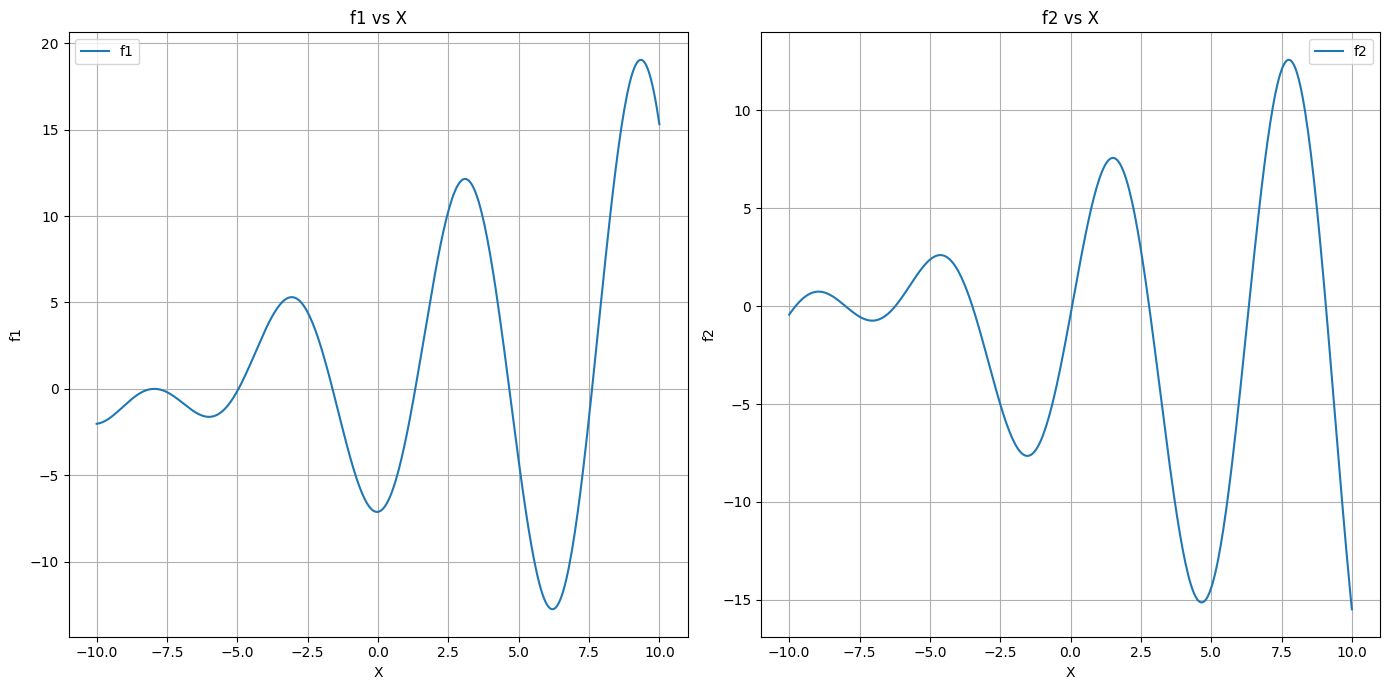

In [54]:
def shift_f(X, shift=1.0):
    f1 = (X + shift) * torch.sin(X + torch.pi + shift) + (X + shift) / 10.0
    f2 = (X + shift) * torch.cos(X + torch.pi + shift) - (X + shift) / 5.0
    
    f_X = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=-1)  # Stack the objectives along the last dimension
    return f_X

X = torch.linspace(-10, 10, 400) # Alpine

shift = 8.0  # Assuming TARGET_SHIFT is 1.0
f_X = shift_f(X, shift)

f1 = f_X[:, 0].numpy()
f2 = f_X[:, 1].numpy()

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(X.numpy(), f1, label='f1')
plt.xlabel('X')
plt.ylabel('f1')
plt.title('f1 vs X')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(X.numpy(), f2, label='f2')
plt.xlabel('X')
plt.ylabel('f2')
plt.title('f2 vs X')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

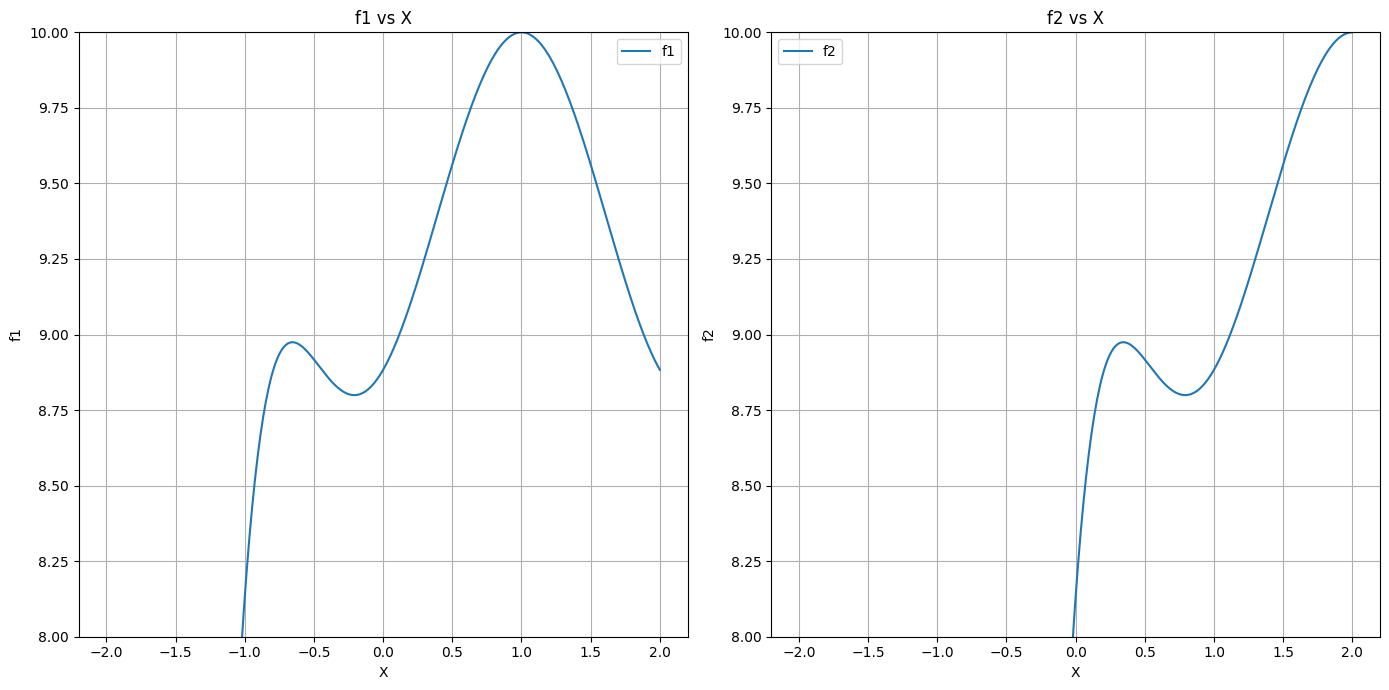

In [23]:
def shift_f_camel(X, shift=0.0):

    # Three hump camel
    f1 = (-(2 * (X + shift-1)**2 - 1.05 * (X + shift -1)**4 + ((X + shift -1)**6) / 6)) + 10
    f2 = (-(2 * (X + shift-2)**2 - 1.05 * (X + shift -2)**4 + ((X + shift -2)**6) / 6)) + 10
    
    f_X = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=-1)  # Stack the objectives along the last dimension
    return f_X

X = torch.linspace(-2, 2, 400)

shift = 0.0  
f_X = shift_f_camel(X, shift)

f1 = f_X[:, 0].numpy()
f2 = f_X[:, 1].numpy()

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(X.numpy(), f1, label='f1')
plt.xlabel('X')
plt.ylabel('f1')
plt.title('f1 vs X')
plt.grid(True)
plt.ylim([8,10])
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(X.numpy(), f2, label='f2')
plt.xlabel('X')
plt.ylabel('f2')
plt.title('f2 vs X')
plt.grid(True)
plt.ylim([8,10])
plt.legend()

plt.tight_layout()
plt.show()

### Shifted Cost function optimization 

In [95]:
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
#from botorch.acquisition.objective import ChebyshevScalarization
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.models import ModelListGP, SingleTaskGP
from botorch.sampling import SobolQMCNormalSampler
from botorch.sampling import IIDNormalSampler
from botorch.optim.optimize import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.sampling import sample_simplex
from botorch.acquisition.objective import GenericMCObjective
import torch
import warnings

# suppress GPyTorch warnings about adding jitter
import warnings


warnings.filterwarnings("ignore", "^.*jitter.*", category=RuntimeWarning)


def shift_f(X, shift = TARGET_SHIFT):
    
    # # Three hump camel
    # shift = 0.0
    # f1 = (-(2 * (X + shift-1)**2 - 1.05 * (X + shift -1)**4 + ((X + shift -1)**6) / 6)) + 10
    # f2 = (-(2 * (X + shift-2)**2 - 1.05 * (X + shift -2)**4 + ((X + shift -2)**6) / 6)) + 10

    # cubic functions
    # f1 = -0.5 * (X**3 - 3 * X**2 + 2) + 3*np.sin(1 * np.pi * X)
    # f2 = -0.5 * (X**3 - 2.5 * X**2 + 1.5) + 3*np.sin(1 * np.pi * X - np.pi)

    f1 = (1 + 0.5 * X) * 3* np.sin(1 * np.pi * X)
    f2 = (1 + 0.5 * X) * 3* np.cos(1 * np.pi * X-np.pi)
    
    f_X = torch.cat([f1, f2], dim=-1)   # Stack the objectives along the last dimension
    return f_X

# Subscripts _1 and _2 represent objectives 1 and 2 respectively

best_rgpe_all_1 = []
best_rgpe_all_2 = []
best_vanilla_nei_all_1 = []
best_vanilla_nei_all_2 = []
rank_weights_all_1 = []
rank_weights_all_2 = []

# mll_values_total = []
# mll_values_vanilla_total = []
hyperparameters_total = []
hyperparameters_vanilla_total = []

rgpe_models = []
rgpe_target_models = []
vanilla_models = []

N_BATCH = 10 if not SMOKE_TEST else 2
NUM_POSTERIOR_SAMPLES = 256 if not SMOKE_TEST else 16
RANDOM_INITIALIZATION_SIZE = 3
N_TRIALS = 8 # 10 if not SMOKE_TEST else 2
MC_SAMPLES = 512 if not SMOKE_TEST else 32
N_RESTART_CANDIDATES = 512 if not SMOKE_TEST else 8
N_RESTARTS = 10 if not SMOKE_TEST else 2
Q_BATCH_SIZE = 1
SHIFT_OBJ_ITER = 6 #change this if you want to change the objective
SHIFT_VALUE = 8.0 #change this to specify the amount to shift with


best_rgpe_inputs_1 = []
best_rgpe_inputs_2 = []
best_vanilla_nei_inputs_1 = []
best_vanilla_nei_inputs_2 = []
best_scalarized_rgpe_values_total = []
best_scalarized_rgpe_params_total = []
best_scalarized_vanilla_values_total = []
best_scalarized_vanilla_params_total = []

# Average over multiple trials
for trial in range(N_TRIALS):
    print(f"Trial {trial + 1} of {N_TRIALS}")
    best_rgpe_1 = []
    best_rgpe_2 = []
    best_rgpe_input_1 = []
    best_rgpe_input_2 = []
    best_vanilla_nei_1 = []
    best_vanilla_nei_2 = []
    best_vanilla_nei_input_1 = []
    best_vanilla_nei_input_2 = []
    rank_weights_list_1 = []
    rank_weights_list_2 = []
    mll_values_trial = []
    mll_values_vanilla_trial = []
    hyperparameters_list = []
    hyperparameters_vanilla_list = []
    best_scalarized_vanilla_values = []
    best_scalarized_rgpe_values = []
    best_scalarized_rgpe_params = []
    best_scalarized_vanilla_params = []
    
    # Initial random observations
    raw_x = draw_sobol_samples(bounds=BOUNDS, n=RANDOM_INITIALIZATION_SIZE, q=1, seed=0).squeeze(-1) #change q value based on input dimensions
    train_x = normalize(raw_x, bounds=BOUNDS)
    train_y_noiseless = f(raw_x)
    train_y = train_y_noiseless + noise_std * torch.randn_like(train_y_noiseless)
    train_yvar = torch.full_like(train_y, noise_std**2)

    # clone train_x and train_y for vanilla (regular GP)
    vanilla_nei_train_x = train_x.clone()
    vanilla_nei_train_y = train_y.clone()
    vanilla_nei_train_yvar = train_yvar.clone()
    
    for iteration in range(N_BATCH):
        print(train_x.shape, train_y.shape)
        target_model = get_fitted_model(train_x, train_y, train_yvar)
        
        base_model_list_1 = [base_model_list[i].models[0] for i in range(NUM_BASE_TASKS)]
        base_model_list_2 = [base_model_list[i].models[1] for i in range(NUM_BASE_TASKS)]

        target_model_1 = target_model.models[0]
        target_model_2 = target_model.models[1]

        hyperparameters = {
            "lengthscale": [target_model_1.covar_module.base_kernel.lengthscale.detach().cpu().numpy(), 
                            target_model_2.covar_module.base_kernel.lengthscale.detach().cpu().numpy()],
            "noise": [target_model_1.likelihood.noise.detach().cpu().numpy(),
                      target_model_2.likelihood.noise.detach().cpu().numpy()],
            "outputscale": [target_model_1.covar_module.outputscale.detach().cpu().numpy(),
                            target_model_2.covar_module.outputscale.detach().cpu().numpy()]
        }
        hyperparameters_list.append(hyperparameters)
            
        model_list_1 = base_model_list_1 + [target_model_1]
        model_list_2 = base_model_list_2 + [target_model_2]
        
        train_y_1 = train_y[:,0].reshape(train_y.shape[0],1)
        train_yvar_1 = train_yvar[:,0].reshape(train_yvar.shape[0],1)
        
        train_y_2 = train_y[:,1].reshape(train_y.shape[0],1)
        train_yvar_2 = train_yvar[:,1].reshape(train_yvar.shape[0],1)

        # compute rank weights
        rank_weights_1 = compute_rank_weights(
                train_x,
                train_y_1,
                train_yvar_1,
                base_model_list_1,
                target_model_1,
                NUM_POSTERIOR_SAMPLES,
            )
        
        rank_weights_2 = compute_rank_weights(
                train_x,
                train_y_2,
                train_yvar_2,
                base_model_list_2,
                target_model_2,
                NUM_POSTERIOR_SAMPLES,
            )
        
        rank_weights_list_1.append(rank_weights_1)
        rank_weights_list_2.append(rank_weights_2)

        
        ##  create model 
        rgpe_model_1 = RGPE(model_list_1, rank_weights_1)
        rgpe_model_2 = RGPE(model_list_2, rank_weights_2)
        rgpe_model = ModelListGP(rgpe_model_1, rgpe_model_2)

        # Create Chebyshev scalarization objective and acquisition function

        with torch.no_grad():
            pred = rgpe_model.posterior(train_x).mean
        
        weights = torch.tensor([0.5, 0.5]) #use this if you want equal importance for both objectives
        alpha = 0.1  # specify the alpha value
        product = weights * train_y
        scalarized_y = product.min(dim=-1).values + alpha * product.sum(dim=-1)

        best_scalarized_value, best_scalarized_index = scalarized_y.max(0)
        best_scalarized_rgpe_values.append(best_scalarized_value.item())
        best_scalarized_rgpe_params.append(unnormalize(train_x[best_scalarized_index], BOUNDS))
        
        chebyshev_objective = GenericMCObjective(
            get_chebyshev_scalarization(
                weights,
                pred
            )
        )
        
        sampler_qnei = SobolQMCNormalSampler(sample_shape=torch.tensor([512]).shape)
        qNEI = qNoisyExpectedImprovement(
            model=rgpe_model,
            X_baseline=train_x,
            sampler=sampler_qnei,
            objective=chebyshev_objective,
            prune_baseline=True,
        )

        # optimize
        candidate, _ = optimize_acqf(
            acq_function=qNEI,
            bounds=torch.tensor([[0.0], [1.0]], dtype=dtype, device=device),
            q=Q_BATCH_SIZE,
            num_restarts=N_RESTARTS,
            raw_samples=N_RESTART_CANDIDATES,
        )
        print('\n\n\n\n\n', noise_std)
        # fetch the new values
        new_x = candidate.detach()
        if SHIFT_OBJ_ITER != 0:
            if iteration < SHIFT_OBJ_ITER:
                new_y_noiseless = f(unnormalize(new_x, bounds=BOUNDS))
            else:
                new_y_noiseless = shift_f(unnormalize(new_x, bounds=BOUNDS), shift=SHIFT_VALUE)
        new_y = new_y_noiseless + noise_std * torch.randn_like(new_y_noiseless)
        new_yvar = torch.full_like(new_y, noise_std**2)

        # update training points
        train_x = torch.cat((train_x, new_x))
        train_y = torch.cat((train_y, new_y))
        train_yvar = torch.cat((train_yvar, new_yvar))

        # get the new best observed value and input parameters
        best_value_1, best_index_1 = train_y[:,0].max(0)
        best_value_2, best_index_2 = train_y[:,1].max(0)
        best_rgpe_1.append(best_value_1.item())
        best_rgpe_2.append(best_value_2.item())
        best_rgpe_input_1.append(train_x[best_index_1])
        best_rgpe_input_2.append(train_x[best_index_2])

        
        ### Run Vanilla NEI for comparison ###
        
        vanilla_nei_model = get_fitted_model(
            vanilla_nei_train_x,
            vanilla_nei_train_y,
            vanilla_nei_train_yvar,
        )

        hyperparameters_vanilla = {
            "lengthscale": [vanilla_nei_model.models[0].covar_module.base_kernel.lengthscale.detach().cpu().numpy(), 
                            vanilla_nei_model.models[1].covar_module.base_kernel.lengthscale.detach().cpu().numpy()],
            "noise": [vanilla_nei_model.models[0].likelihood.noise.detach().cpu().numpy(),
                      vanilla_nei_model.models[1].likelihood.noise.detach().cpu().numpy()],
            "outputscale": [vanilla_nei_model.models[0].covar_module.outputscale.detach().cpu().numpy(),
                            vanilla_nei_model.models[1].covar_module.outputscale.detach().cpu().numpy()]
        }
        hyperparameters_vanilla_list.append(hyperparameters_vanilla)

        # Create Chebyshev scalarization objective and acquisition function
        
        with torch.no_grad():
            vanilla_pred = vanilla_nei_model.posterior(train_x).mean
            
        weights = torch.tensor([0.5, 0.5]) #use this if you want equal importance for both objectives
        product = weights * vanilla_nei_train_y
        scalarized_y = product.min(dim=-1).values + alpha * product.sum(dim=-1)

        best_scalarized_value, best_scalarized_index = scalarized_y.max(0)
        best_scalarized_vanilla_values.append(best_scalarized_value.item())
        best_scalarized_vanilla_params.append(unnormalize(vanilla_nei_train_x[best_scalarized_index], BOUNDS))
        
        vanilla_chebyshev_objective = GenericMCObjective(
            get_chebyshev_scalarization(
                weights,
                vanilla_pred
            )
        )
        
        sampler_qnei = SobolQMCNormalSampler(sample_shape=torch.tensor([512]).shape)
        vanilla_qNEI = qNoisyExpectedImprovement(
            model=vanilla_nei_model,
            X_baseline=vanilla_nei_train_x,
            sampler=sampler_qnei,
            objective=vanilla_chebyshev_objective,
            prune_baseline=True,
        )
        # Next best candidate
        vanilla_nei_candidate, _ = optimize_acqf(
            acq_function=vanilla_qNEI,
            bounds=torch.tensor([[0.0], [1.0]], dtype=dtype, device=device),
            q=Q_BATCH_SIZE,
            num_restarts=N_RESTARTS,
            raw_samples=N_RESTART_CANDIDATES,
        )
        # fetch the new values
        vanilla_nei_new_x = vanilla_nei_candidate.detach()
        if SHIFT_OBJ_ITER != 0:
            if iteration < SHIFT_OBJ_ITER:
                vanilla_nei_new_y_noiseless = f(unnormalize(vanilla_nei_new_x, bounds=BOUNDS))
            else:
                vanilla_nei_new_y_noiseless = shift_f(unnormalize(vanilla_nei_new_x, bounds=BOUNDS), shift=SHIFT_VALUE)
        # vanilla_nei_new_y_noiseless = f(unnormalize(vanilla_nei_new_x, bounds=BOUNDS))
        vanilla_nei_new_y = vanilla_nei_new_y_noiseless + noise_std * torch.randn_like(vanilla_nei_new_y_noiseless)
        print(vanilla_nei_new_y_noiseless, vanilla_nei_new_y, unnormalize(vanilla_nei_new_x, bounds=BOUNDS))
        vanilla_nei_new_yvar = torch.full_like(vanilla_nei_new_y, noise_std**2)
        
        # update training points
        vanilla_nei_train_x = torch.cat([vanilla_nei_train_x, vanilla_nei_new_x])
        vanilla_nei_train_y = torch.cat([vanilla_nei_train_y, vanilla_nei_new_y])
        vanilla_nei_train_yvar = torch.cat([vanilla_nei_train_yvar, vanilla_nei_new_yvar])
        
        # get the new best observed value and input parameters
        vanilla_nei_best_value_1, vanilla_best_index_1 = vanilla_nei_train_y[:,0].max(0)
        vanilla_nei_best_value_2, vanilla_best_index_2 = vanilla_nei_train_y[:,1].max(0)
        
        best_vanilla_nei_1.append(vanilla_nei_best_value_1.item())
        best_vanilla_nei_2.append(vanilla_nei_best_value_2.item())
        best_vanilla_nei_input_1.append(vanilla_nei_train_x[vanilla_best_index_1])
        best_vanilla_nei_input_2.append(vanilla_nei_train_x[vanilla_best_index_2])
    
    hyperparameters_total.append(hyperparameters_list)
    hyperparameters_vanilla_total.append(hyperparameters_vanilla_list)

    rgpe_models.append([rgpe_model, train_x, train_y])
    vanilla_models.append([vanilla_nei_model, vanilla_nei_train_x, vanilla_nei_train_y])

    best_rgpe_all_1.append(best_rgpe_1)
    best_rgpe_all_2.append(best_rgpe_2)
    best_rgpe_inputs_1.append(best_rgpe_input_1)
    best_rgpe_inputs_2.append(best_rgpe_input_2)
    best_scalarized_rgpe_values_total.append(best_scalarized_rgpe_values)
    best_scalarized_rgpe_params_total.append(best_scalarized_rgpe_params)
    best_vanilla_nei_all_1.append(best_vanilla_nei_1)
    best_vanilla_nei_all_2.append(best_vanilla_nei_2)
    best_vanilla_nei_inputs_1.append(best_vanilla_nei_input_1)
    best_vanilla_nei_inputs_2.append(best_vanilla_nei_input_2)
    best_scalarized_vanilla_values_total.append(best_scalarized_vanilla_values)
    best_scalarized_vanilla_params_total.append(best_scalarized_vanilla_params)
    rank_weights_all_1.append(rank_weights_list_1)
    rank_weights_all_2.append(rank_weights_list_2)

best_scalarized_rgpe_params_total = np.array(best_scalarized_rgpe_params_total).squeeze(-1)
best_scalarized_vanilla_params_total = np.array(best_scalarized_vanilla_params_total).squeeze(-1)

Trial 1 of 8
torch.Size([3, 1]) torch.Size([3, 2])





 0.05
tensor([[6.4402, 6.4402]], dtype=torch.float64) tensor([[6.4713, 6.4558]], dtype=torch.float64) tensor([[10.]], dtype=torch.float64)
torch.Size([4, 1]) torch.Size([4, 2])


c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(







 0.05
tensor([[-1.8755, -1.8755]], dtype=torch.float64) tensor([[-1.9234, -1.9366]], dtype=torch.float64) tensor([[-2.3852]], dtype=torch.float64)
torch.Size([5, 1]) torch.Size([5, 2])


c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(







 0.05
tensor([[5.2562, 5.2562]], dtype=torch.float64) tensor([[5.3089, 5.2909]], dtype=torch.float64) tensor([[4.7923]], dtype=torch.float64)
torch.Size([6, 1]) torch.Size([6, 2])


c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(







 0.05
tensor([[0.0019, 0.0019]], dtype=torch.float64) tensor([[-0.0644,  0.0398]], dtype=torch.float64) tensor([[0.0265]], dtype=torch.float64)
torch.Size([7, 1]) torch.Size([7, 2])


c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(







 0.05
tensor([[-1.5339, -1.5339]], dtype=torch.float64) tensor([[-1.5745, -1.5552]], dtype=torch.float64) tensor([[1.7281]], dtype=torch.float64)
torch.Size([8, 1]) torch.Size([8, 2])


c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(







 0.05
tensor([[5.3066, 5.3066]], dtype=torch.float64) tensor([[5.2179, 5.3719]], dtype=torch.float64) tensor([[4.9394]], dtype=torch.float64)
torch.Size([9, 1]) torch.Size([9, 2])


c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(







 0.05
tensor([[0.8461, 0.6328]], dtype=torch.float64) tensor([[0.8641, 0.6086]], dtype=torch.float64) tensor([[-1.2956]], dtype=torch.float64)
torch.Size([10, 1]) torch.Size([10, 2])


c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(







 0.05
tensor([[ 0.1403, -0.2256]], dtype=torch.float64) tensor([[ 0.1751, -0.2201]], dtype=torch.float64) tensor([[-1.8229]], dtype=torch.float64)
torch.Size([11, 1]) torch.Size([11, 2])


c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(







 0.05
tensor([[ 0.3443, 13.4834]], dtype=torch.float64) tensor([[ 0.2440, 13.4829]], dtype=torch.float64) tensor([[6.9919]], dtype=torch.float64)
torch.Size([12, 1]) torch.Size([12, 2])


c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\optim\initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(







 0.05


KeyboardInterrupt: 

In [101]:
best_scalarized_vanilla_params_total

array([[  9.7556648 ,   9.9419751 ,  10.        ,  10.        ,
         10.        ,  10.        ,  10.        ,  10.        ,
         10.        ,  10.        ,  10.        ,  10.        ,
         10.        ,  10.        ,  10.        ,  10.        ,
         10.        ,  10.        ,  10.        ,  10.        ],
       [  9.7556648 ,   9.85089144,  10.        ,  10.        ,
         10.        ,  10.        ,  10.        ,  10.        ,
         10.        ,  10.        ,  10.        ,  10.        ,
         10.        ,  10.        ,  10.        ,  10.        ,
         10.        ,  10.        ,  10.        ,  10.        ],
       [  9.7556648 ,  10.        ,  10.        ,  10.        ,
         10.        ,  10.        ,  10.        ,  10.        ,
         10.        ,  10.        ,  10.        ,  10.        ,
         10.        ,  10.        ,  10.        ,  10.        ,
         10.        ,  10.        ,  10.        ,  10.        ],
       [  9.7556648 ,   9.7556648 , -

In [103]:
best_scalarized_rgpe_params_total

array([[10.        , 10.        , 10.        , 10.        , 10.        ,
        10.        , 10.        , 10.        , 10.        , 10.        ,
        10.        , 10.        , 10.        , 10.        , 10.        ,
        10.        , 10.        , 10.        , 10.        , 10.        ],
       [10.        , 10.        , 10.        , 10.        , 10.        ,
        10.        , 10.        , 10.        , 10.        , 10.        ,
        10.        , 10.        , 10.        , 10.        , 10.        ,
        10.        , 10.        , 10.        , 10.        , 10.        ],
       [10.        , 10.        , 10.        , 10.        , 10.        ,
        10.        , 10.        , 10.        , 10.        , 10.        ,
        10.        , 10.        , 10.        , 10.        , 10.        ,
        10.        , 10.        , 10.        , 10.        , 10.        ],
       [ 4.63697119, 10.        , 10.        , 10.        , 10.        ,
        10.        , 10.        , 10.        , 1

In [72]:
import gpytorch
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



# def plot_final(model, bounds, train_x, train_y, is_rgpe):
#     # Generate normalized grid points
#     x1 = torch.linspace(0, 1, 100, device=train_x.device)
#     x2 = torch.linspace(0, 1, 100, device=train_x.device)
#     x1, x2 = torch.meshgrid(x1, x2)
#     x_grid = torch.stack([x1.flatten(), x2.flatten()], dim=-1)
    
#     # Normalize the training inputs for plotting
#     normalized_train_x = normalize(train_x, bounds)
#     model.eval()

#     for i, sub_model in enumerate(model.models):
#         with torch.no_grad(), gpytorch.settings.fast_pred_var():
#             posterior = sub_model.likelihood(sub_model(x_grid))
#             mean = posterior.mean.squeeze(-1)*sub_model.Y_std + sub_model.Y_mean
#             # variance = posterior.variance
#             lower, upper = posterior.confidence_region()
#             lower=lower*sub_model.Y_std + sub_model.Y_mean
#             upper=upper*sub_model.Y_std + sub_model.Y_mean

#             fig = plt.figure(figsize=(20, 7))

#             # Plot GP mean predictions in normalized space
#             ax1 = fig.add_subplot(121, projection='3d')
#             ax1.plot_trisurf(x_grid[:, 0].cpu().numpy(), 
#                              x_grid[:, 1].cpu().numpy(), 
#                              mean.cpu().numpy().flatten(), cmap='viridis', edgecolor='none')
#             ax1.plot_trisurf(x_grid[:,0].cpu().numpy(), x_grid[:,1].cpu().numpy(), lower.view(-1).cpu().numpy(),
#                 linewidth = 0.2,
#                 antialiased = True,color='gainsboro',alpha=0.4,edgecolor='gainsboro')
#             ax1.plot_trisurf(x_grid[:,0].cpu().numpy(), x_grid[:,1].cpu().numpy(), upper.view(-1).cpu().numpy(),
#                 linewidth = 0.2,
#                 antialiased = True,color='gainsboro',alpha=0.4,edgecolor='gainsboro')
#             ax1.scatter(train_x[:, 0].cpu().numpy(), train_x[:, 1].cpu().numpy(), train_y[:, i].cpu().numpy(), c='r', marker='o', label='Training Data')
#             ax1.set_title(f'GP Mean for {'RGPE' if is_rgpe else 'regular'} Model {i+1}')
#             ax1.set_xlabel('Normalized x1')
#             ax1.set_ylabel('Normalized x2')
#             ax1.set_zlabel('Mean')
#             ax1.legend()

#             # Plot true function values in normalized space
#             true_f = f(unnormalize(x_grid, bounds))
#             ax2 = fig.add_subplot(122, projection='3d')
#             ax2.plot_trisurf(x_grid[:, 0].cpu().numpy(), 
#                              x_grid[:, 1].cpu().numpy(), 
#                              true_f[:, i].cpu().numpy().flatten(), cmap='viridis', edgecolor='none')
#             ax2.scatter(train_x[:, 0].cpu().numpy(), train_x[:, 1].cpu().numpy(), train_y[:, i].cpu().numpy(), c='r', marker='o', label='Training Data')
#             ax2.set_title(f'True Function f{i+1}')
#             ax2.set_xlabel('x1')
#             ax2.set_ylabel('x2')
#             ax2.set_zlabel('Function Value')
#             ax2.legend()

#             plt.show()

def plot_final(model, bounds, train_x, train_y, is_rgpe):
    # Generate normalized grid points for 1D plot
    x_grid = torch.linspace(0, 1, 100, device=train_x.device).unsqueeze(-1)
    
    # Normalize the training inputs for plotting
    normalized_train_x = normalize(train_x, bounds)
    model.eval()

    for i, sub_model in enumerate(model.models):
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            # print(sub_model.Y_std ,sub_model.Y_mean)
            posterior = sub_model(x_grid)
            # mean = posterior.mean.squeeze(-1)*sub_model.Y_std + sub_model.Y_mean
            variance = posterior.variance
            if is_rgpe:
                mean = posterior.mean
            else:
                mean = posterior.mean.squeeze(-1)*sub_model.Y_std + sub_model.Y_mean
                lower, upper = posterior.confidence_region()
                lower=lower*sub_model.Y_std + sub_model.Y_mean
                upper=upper*sub_model.Y_std + sub_model.Y_mean
            # print(lower)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

            # Plot GP mean predictions in normalized space
            ax1.plot(x_grid.cpu().numpy(), mean.cpu().numpy(), label='GP Mean', color='blue')
            if is_rgpe:
                ax1.fill_between(x_grid.cpu().numpy().flatten(), 
                                (mean - 1.96 * variance.sqrt()).cpu().numpy().flatten(), 
                                (mean + 1.96 * variance.sqrt()).cpu().numpy().flatten(), 
                                color='blue', alpha=0.2)
            else:
                ax1.fill_between(x_grid.squeeze(-1).cpu().numpy(), lower.cpu().numpy(),
                    upper.cpu().numpy(), alpha=0.5,label='confidence')
            ax1.scatter(train_x[:, 0].cpu().numpy(), train_y[:, i].cpu().numpy(), c='r', marker='o', label='Training Data')
            ax1.set_title(f'GP Mean for {"RGPE" if is_rgpe else "regular"} Model {i+1}')
            ax1.set_xlabel('Normalized x')
            ax1.set_ylabel('Mean')
            # if i 
            # ax1.set_ylim(-4, 4)
            ax1.legend()

            # Plot true function values in normalized space
            true_f = f(unnormalize(x_grid, bounds))
            ax2.plot(x_grid.cpu().numpy(), true_f[:, i].cpu().numpy(), label='True Function', color='green')
            ax2.scatter(train_x[:, 0].cpu().numpy(), train_y[:, i].cpu().numpy(), c='r', marker='o', label='Training Data')
            ax2.set_title(f'True Function f{i+1}')
            ax2.set_xlabel('x')
            ax2.set_ylabel('Function Value')
            ax2.legend()
            # ax2.set_ylim(-4, 4)

            plt.show()


In [ ]:
for model, x, y in vanilla_models:    
    plot_final(model, BOUNDS, x, y, False)
    # print(x, y)

In [ ]:
for model, x, y in rgpe_models:    
    plot_final(model, BOUNDS, x, y, True)
    # print(x, y)

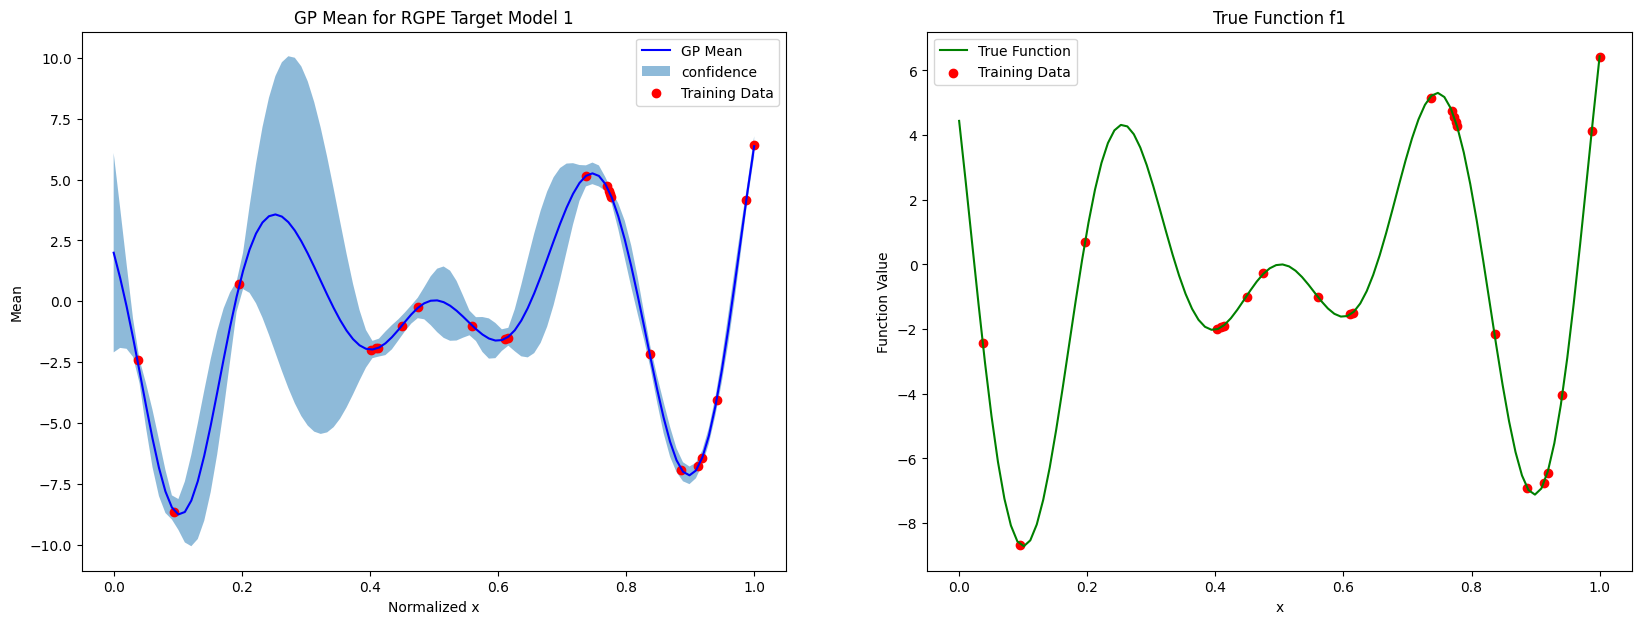

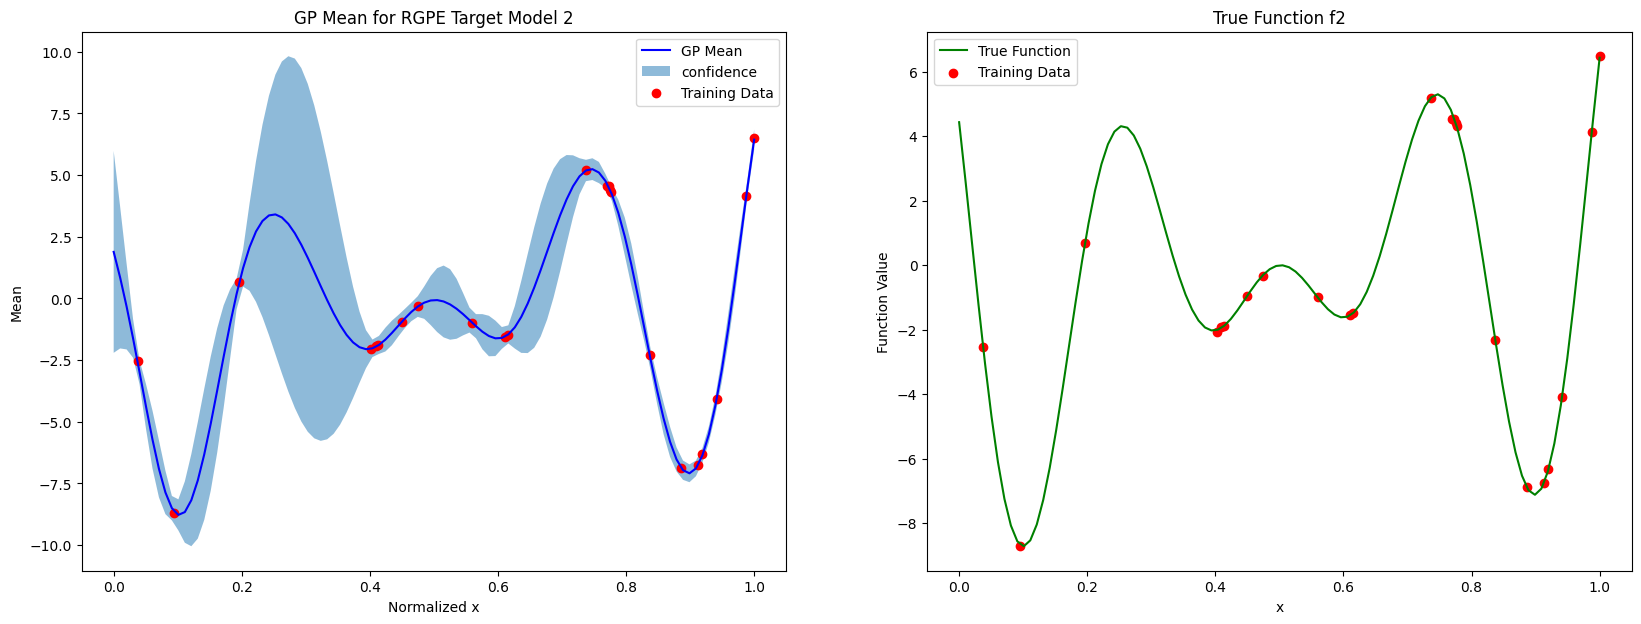

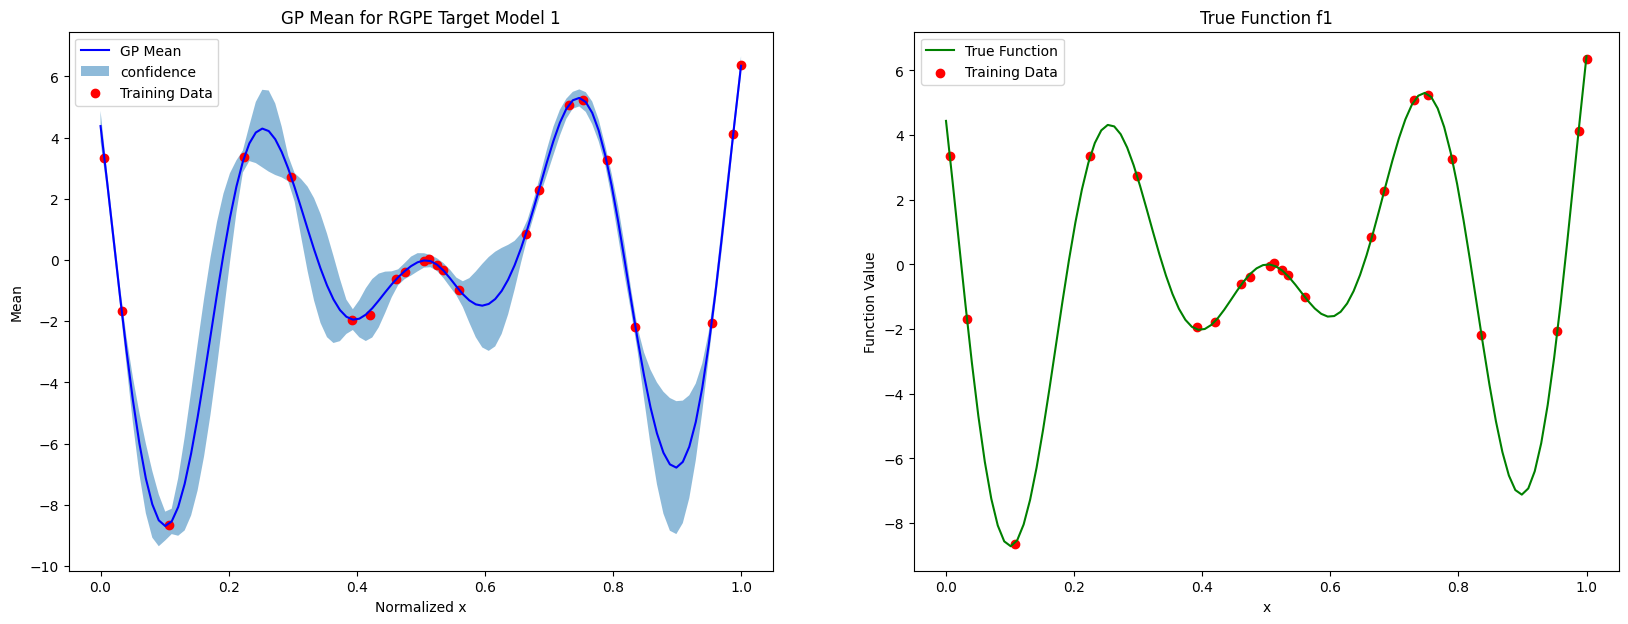

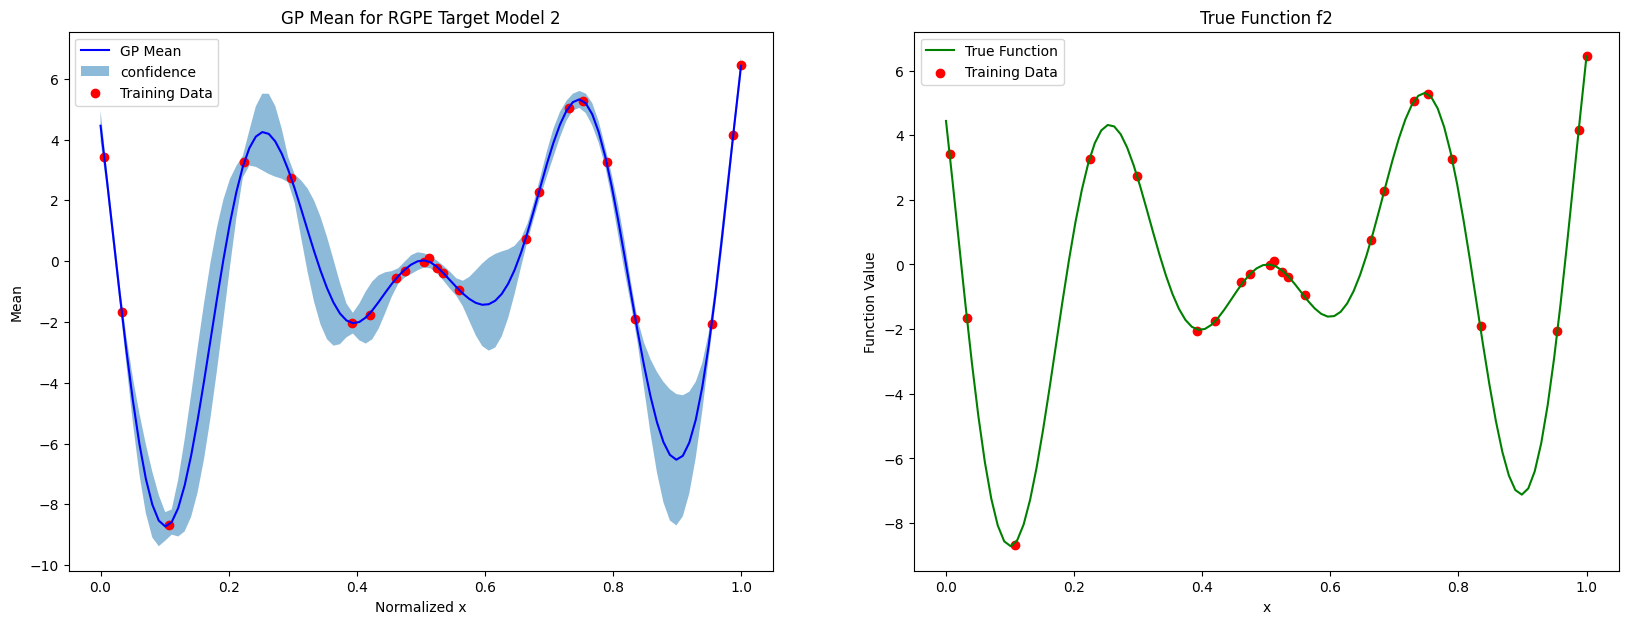

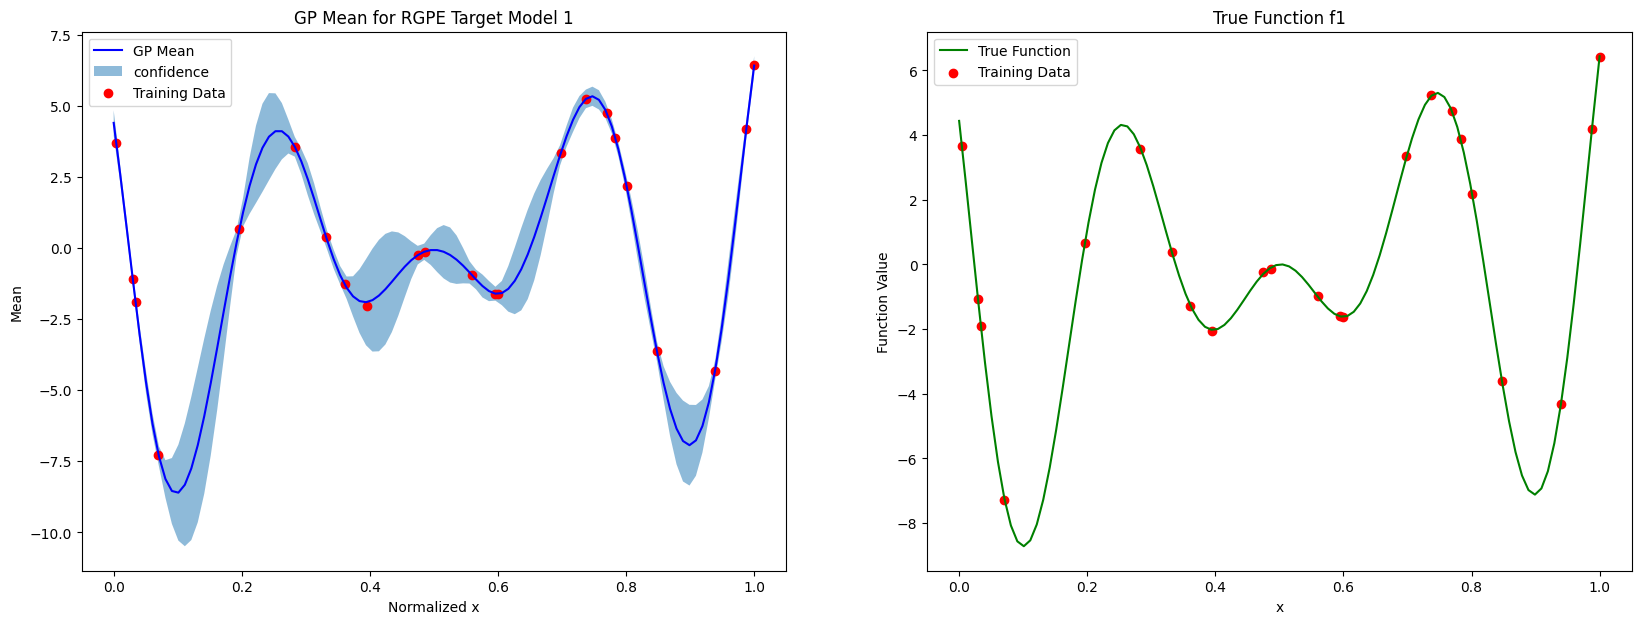

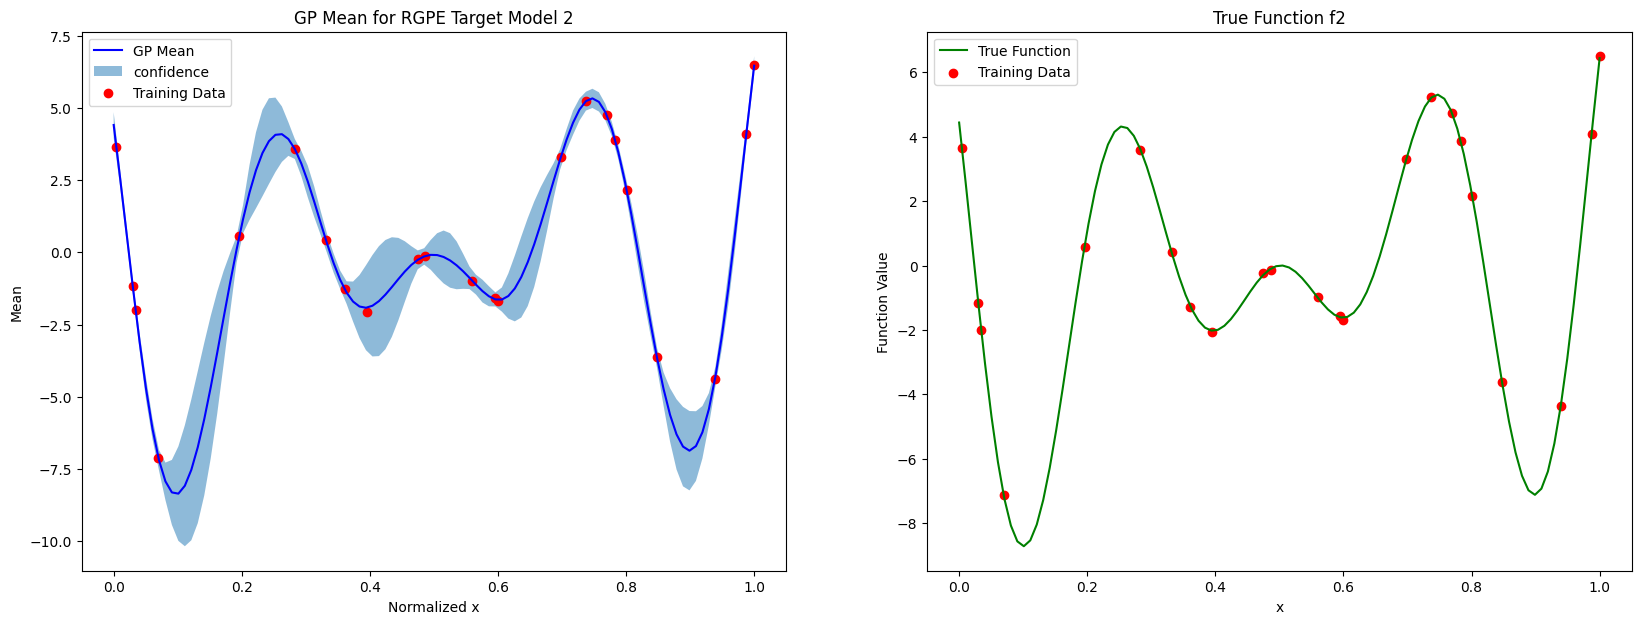

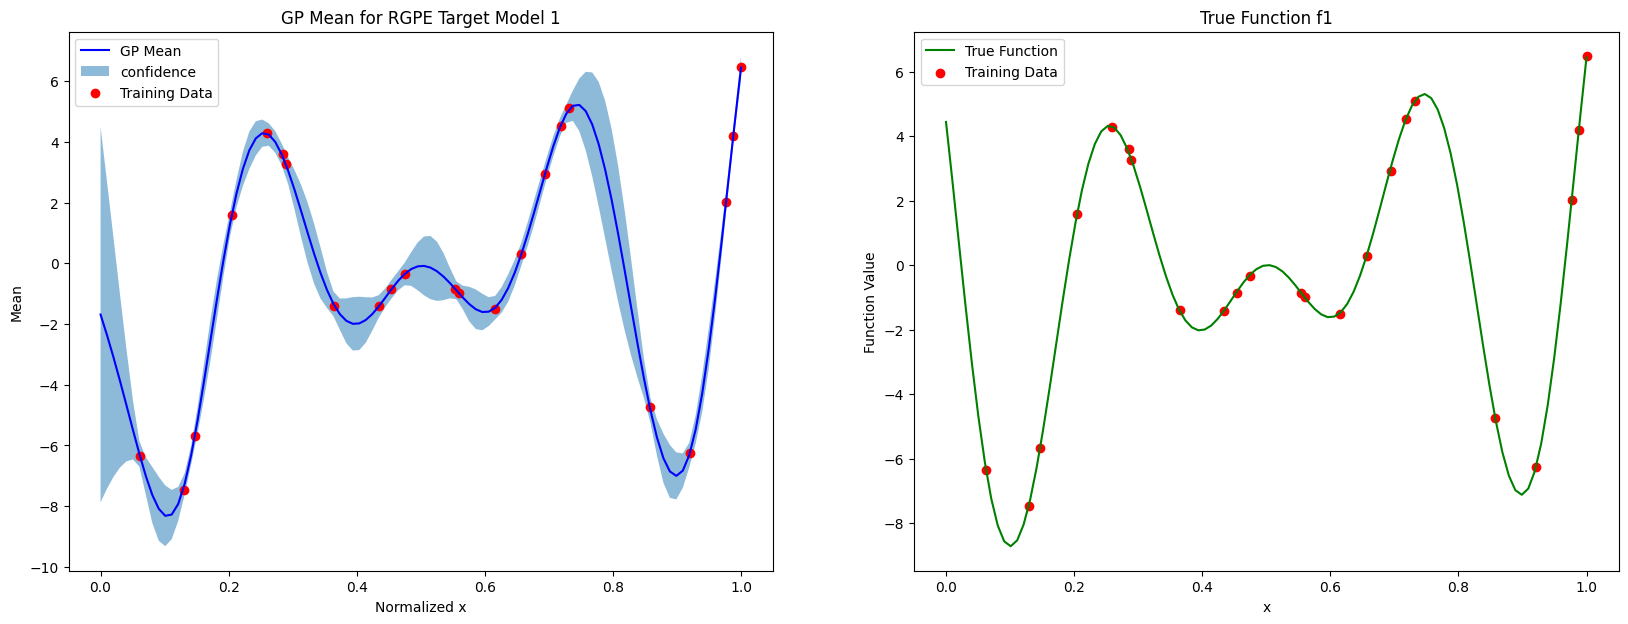

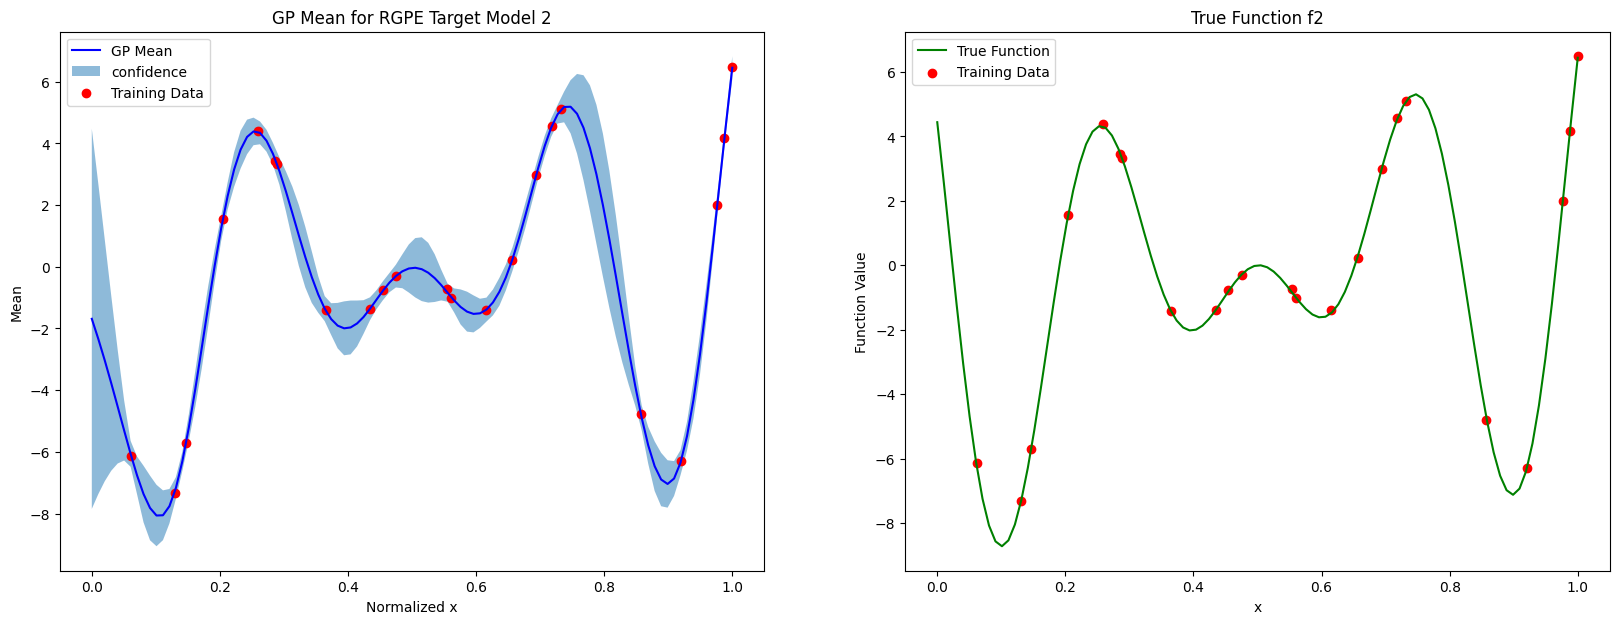

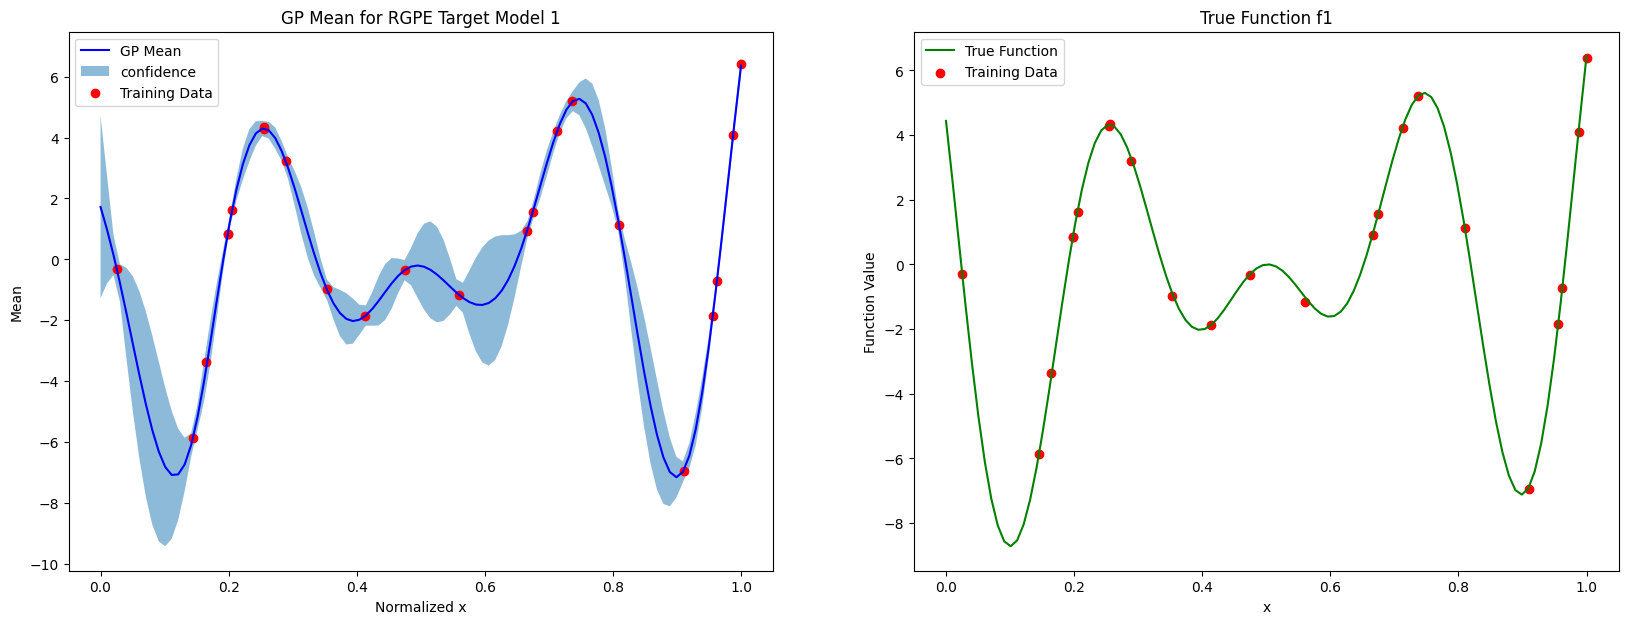

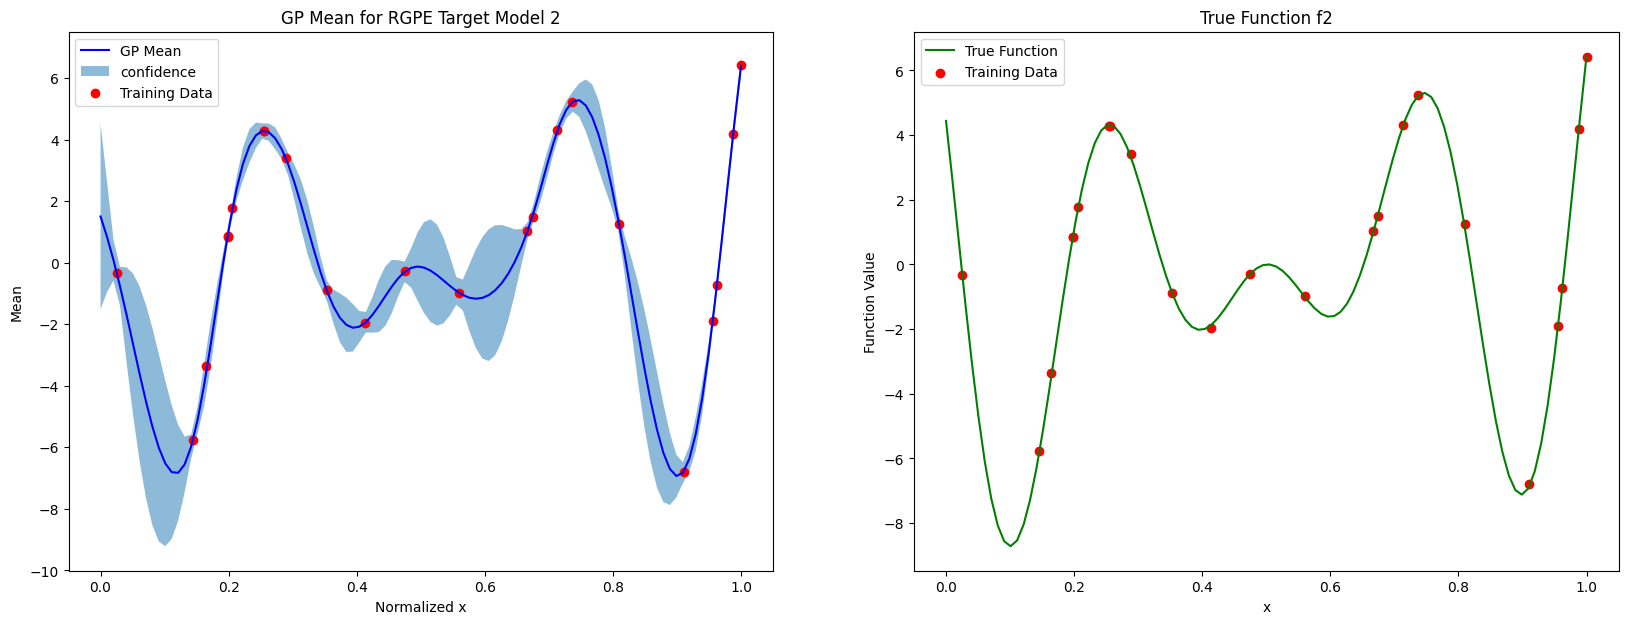

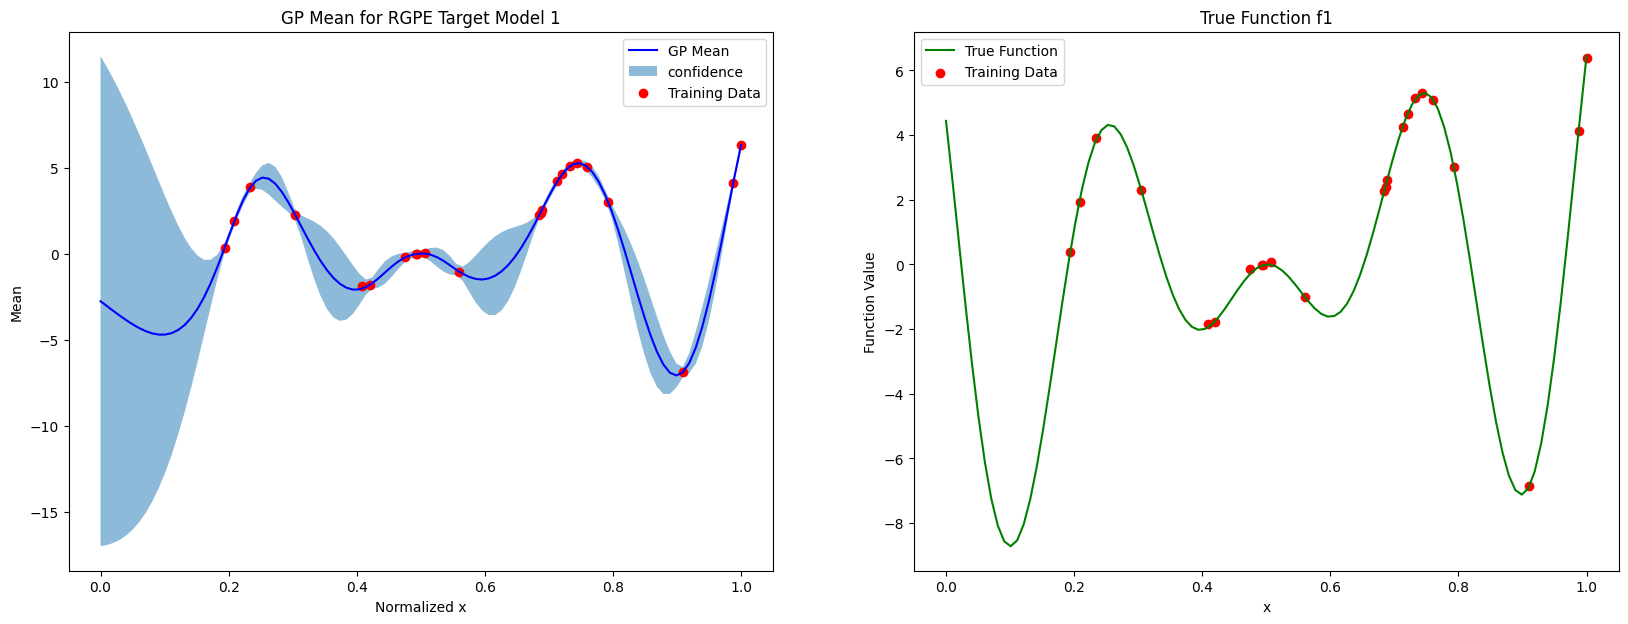

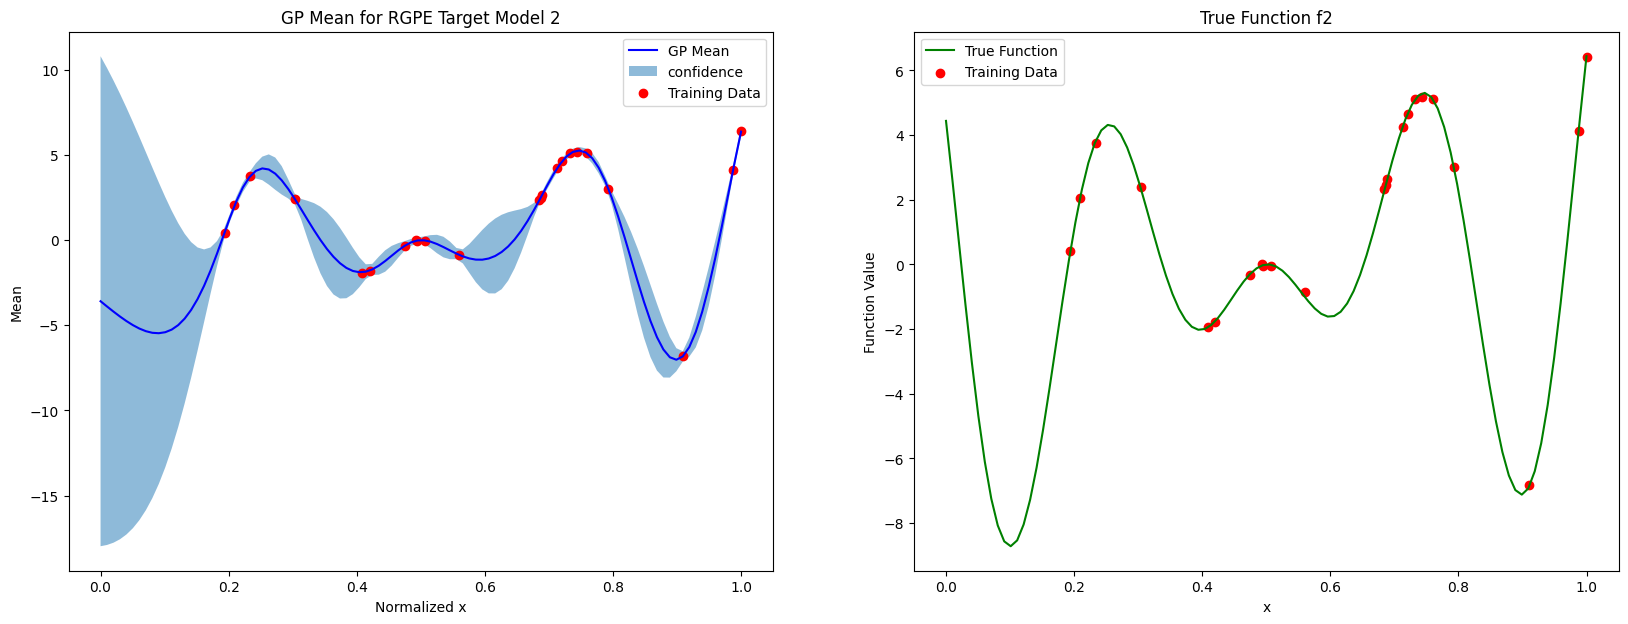

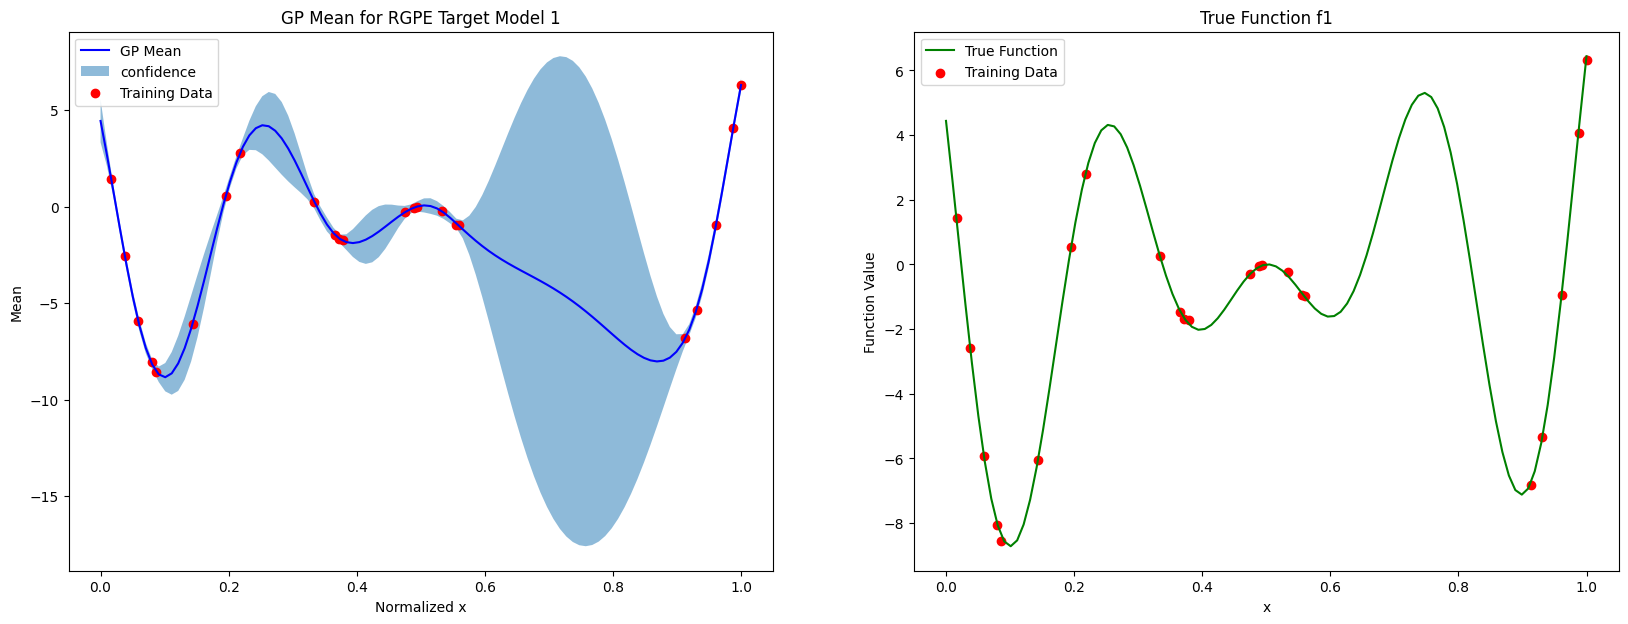

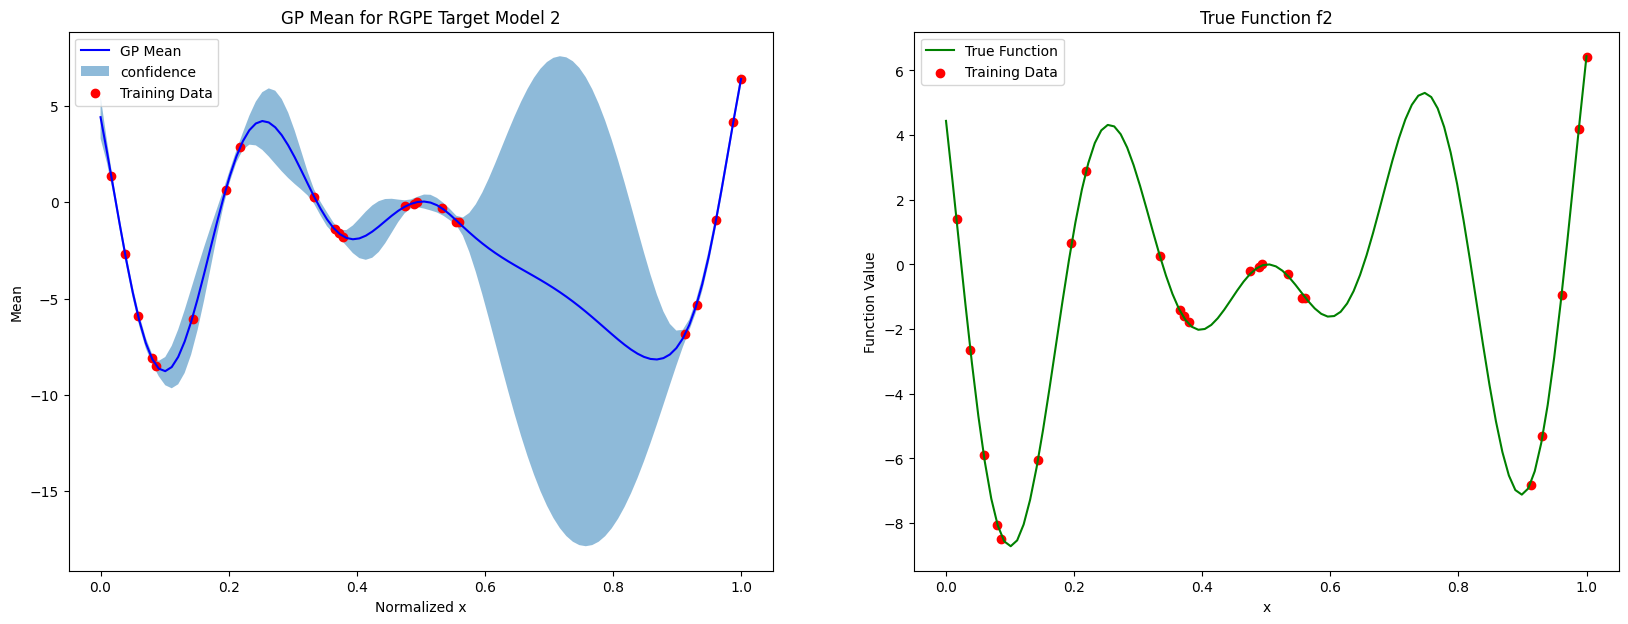

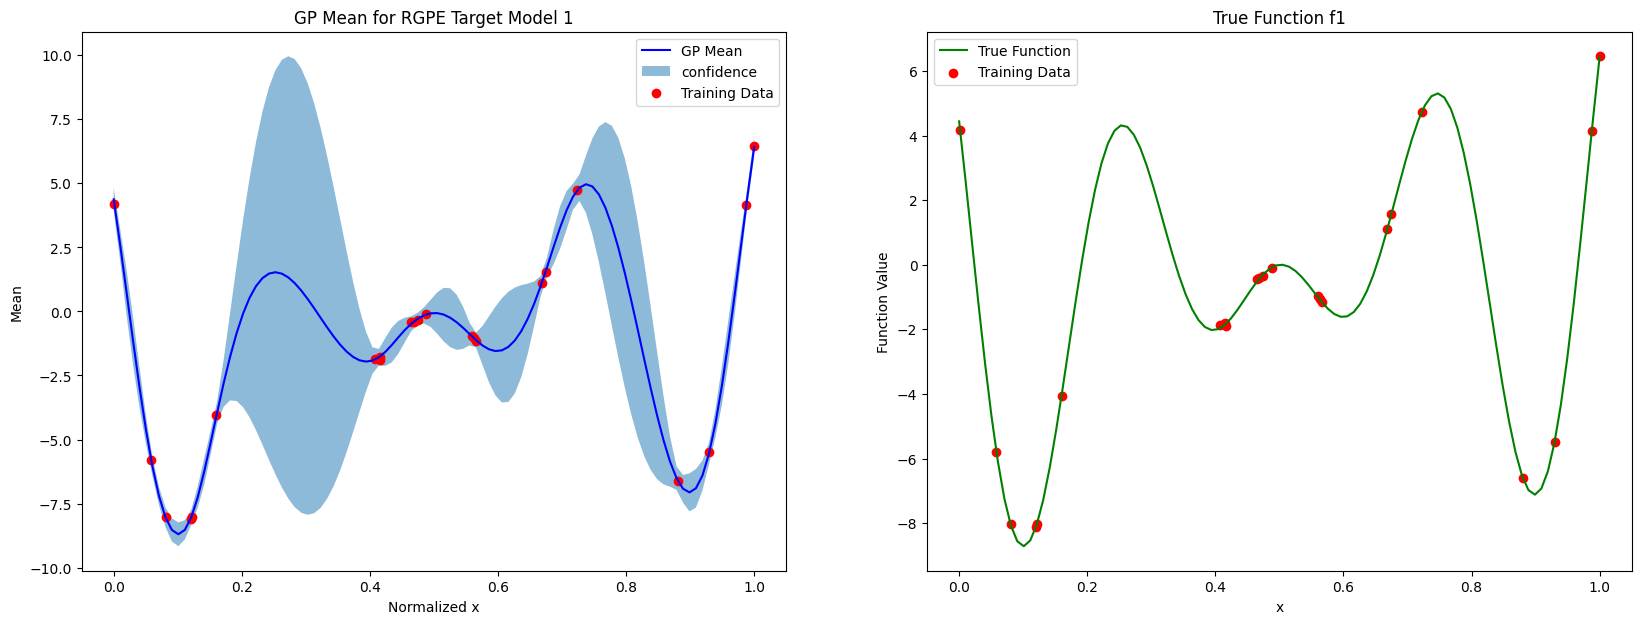

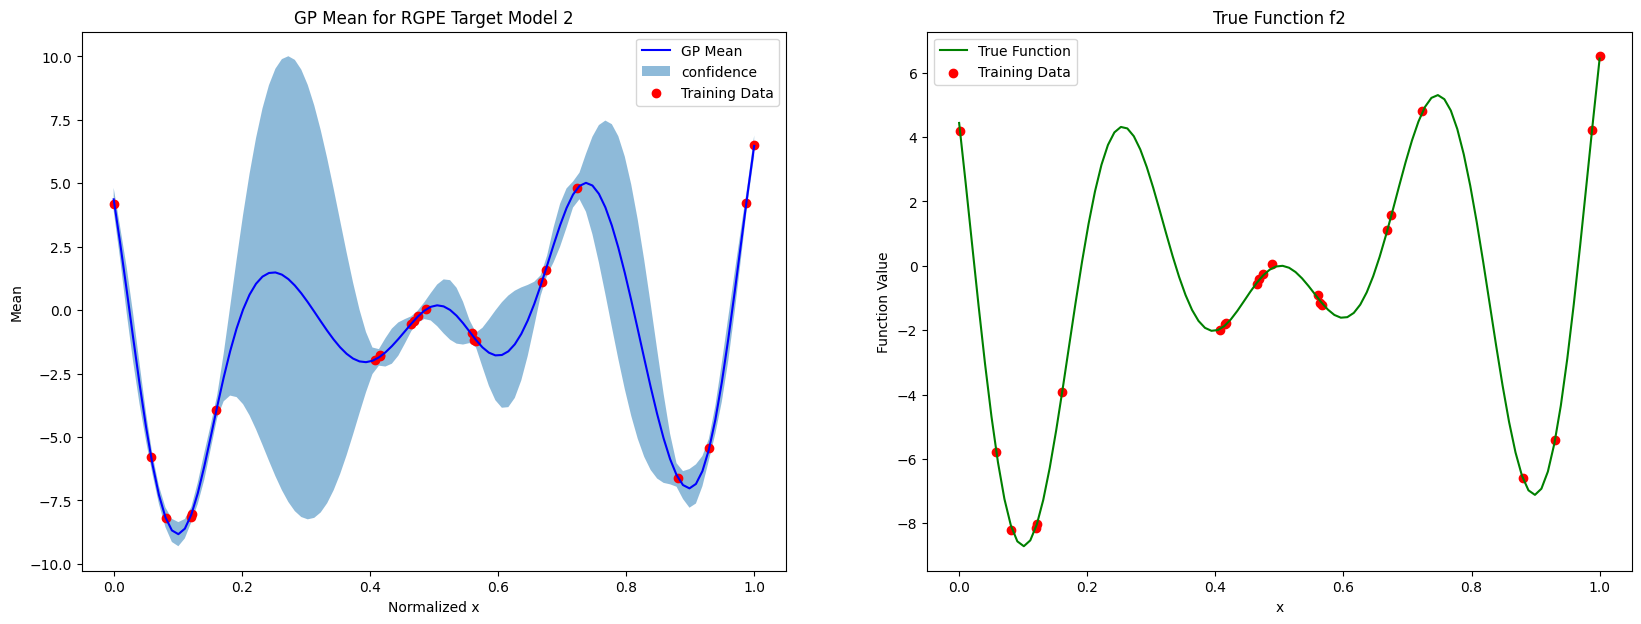

In [108]:
def plot_final_target(model, bounds, train_x, train_y):
    # Generate normalized grid points for 1D plot
    x_grid = torch.linspace(0, 1, 100, device=train_x.device).unsqueeze(-1)
    
    # Normalize the training inputs for plotting
    normalized_train_x = normalize(train_x, bounds)
    model.eval()

    for i, sub_model in enumerate(model.models):
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            model = sub_model.models[-1]
            # print(sub_model.Y_std ,sub_model.Y_mean)
            posterior = model(x_grid)
            # mean = posterior.mean.squeeze(-1)*sub_model.Y_std + sub_model.Y_mean
            variance = posterior.variance
            # if is_rgpe:
            # mean = posterior.mean
        
            mean = posterior.mean.squeeze(-1)*model.Y_std + model.Y_mean
            lower, upper = posterior.confidence_region()
            lower=lower*model.Y_std + model.Y_mean
            upper=upper*model.Y_std + model.Y_mean
            # print(lower)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

            # Plot GP mean predictions in normalized space
            ax1.plot(x_grid.cpu().numpy(), mean.cpu().numpy(), label='GP Mean', color='blue')
            # else:
            ax1.fill_between(x_grid.squeeze(-1).cpu().numpy(), lower.cpu().numpy(),
                upper.cpu().numpy(), alpha=0.5,label='confidence')
            ax1.scatter(train_x[:, 0].cpu().numpy(), train_y[:, i].cpu().numpy(), c='r', marker='o', label='Training Data')
            ax1.set_title(f'GP Mean for RGPE Target Model {i+1}')
            ax1.set_xlabel('Normalized x')
            ax1.set_ylabel('Mean')
            # if i 
            # ax1.set_ylim(-4, 4)
            ax1.legend()

            # Plot true function values in normalized space
            true_f = f(unnormalize(x_grid, bounds))
            ax2.plot(x_grid.cpu().numpy(), true_f[:, i].cpu().numpy(), label='True Function', color='green')
            ax2.scatter(train_x[:, 0].cpu().numpy(), train_y[:, i].cpu().numpy(), c='r', marker='o', label='Training Data')
            ax2.set_title(f'True Function f{i+1}')
            ax2.set_xlabel('x')
            ax2.set_ylabel('Function Value')
            ax2.legend()
            # ax2.set_ylim(-4, 4)

            plt.show()

for model, x, y in rgpe_models:    
    plot_final_target(model, BOUNDS, x, y)

In [29]:
print(np.array(best_scalarized_rgpe_params_total).shape)

(8, 10)


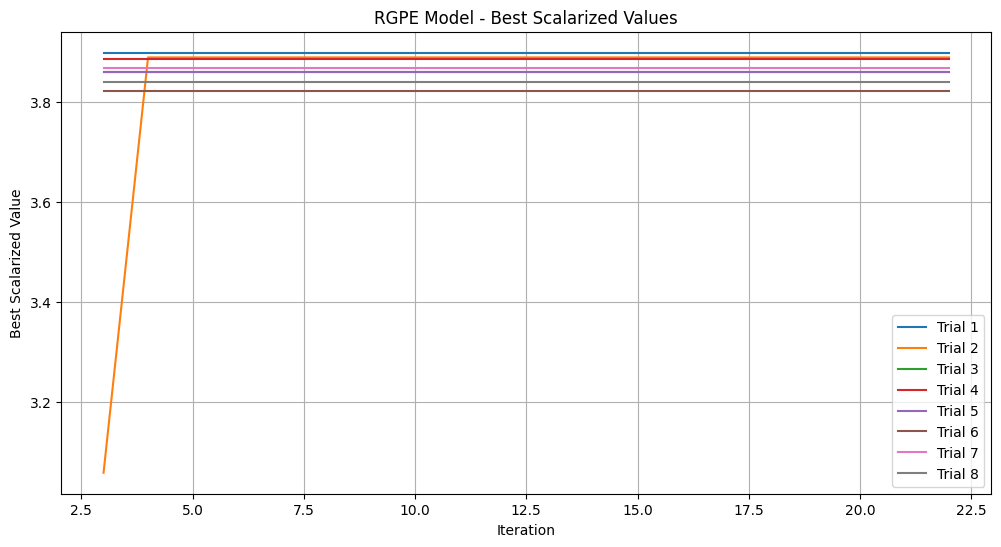

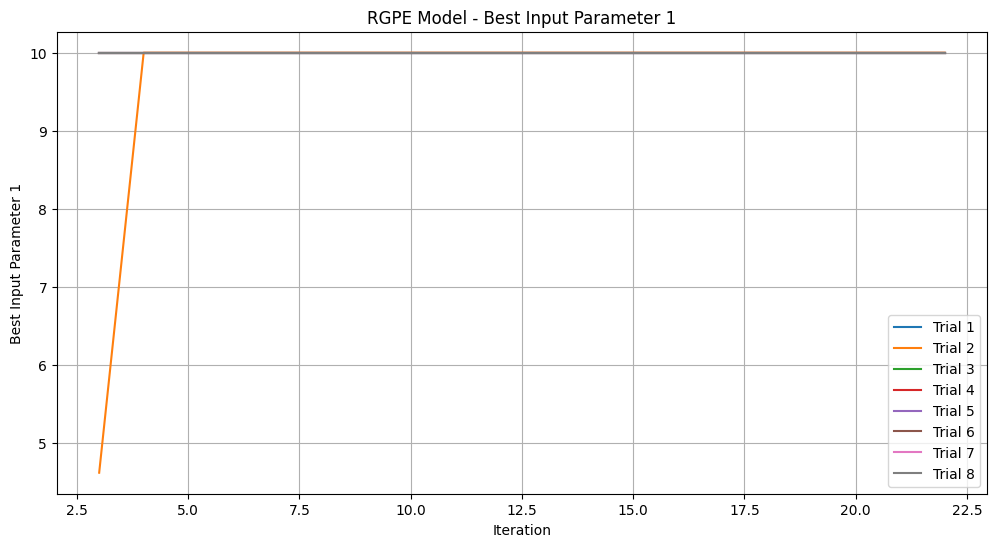

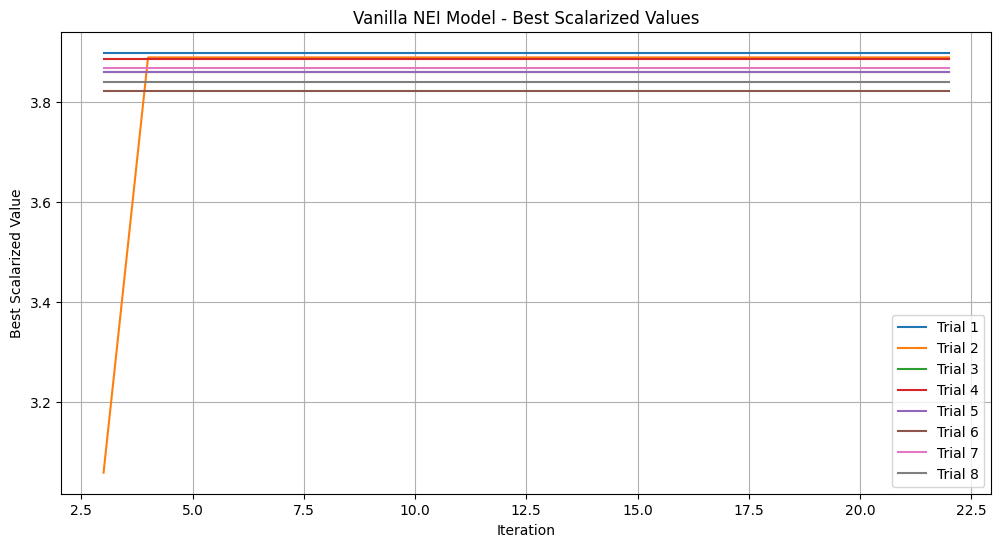

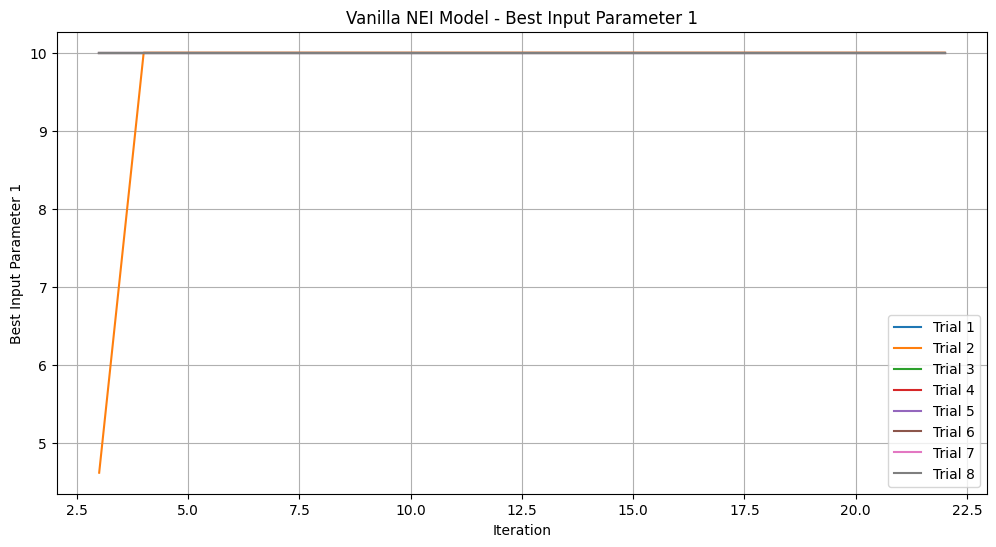

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the best scalarized values and input parameters for all trials
def plot_scalarized_values_and_inputs(best_scalarized_values, best_scalarized_params, title):
    # Convert list of tensors to numpy arrays for easier plotting
    best_scalarized_values_np = [torch.tensor(values) for values in best_scalarized_values]
    best_scalarized_params_np = [torch.tensor(values) for values in best_scalarized_params]

    # best_scalarized_params_np = unnormalize(best_scalarized_params_np, BOUNDS)
    x = range(RANDOM_INITIALIZATION_SIZE, RANDOM_INITIALIZATION_SIZE + N_BATCH)
    # Plot the best scalarized values
    plt.figure(figsize=(12, 6))
    for trial in range(len(best_scalarized_values_np)):
        plt.plot(x, best_scalarized_values_np[trial], label=f'Trial {trial + 1}')
    plt.xlabel('Iteration')
    plt.ylabel('Best Scalarized Value')
    plt.title(f'{title} - Best Scalarized Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the best input parameters
    num_params = best_scalarized_params_np[0].shape[-1] if best_scalarized_params_np[0].ndim > 1 else 1
    for param_idx in range(num_params):
        plt.figure(figsize=(12, 6))
        for trial in range(len(best_scalarized_params_np)):
            if num_params > 1:
                plt.plot(x, best_scalarized_params_np[trial][:, param_idx], label=f'Trial {trial + 1}')
            else:
                plt.plot(x, best_scalarized_params_np[trial], label=f'Trial {trial + 1}')
        plt.xlabel('Iteration')
        plt.ylabel(f'Best Input Parameter {param_idx + 1}')
        plt.title(f'{title} - Best Input Parameter {param_idx + 1}')
        plt.legend()
        plt.grid(True)
        plt.show()

# Plotting for RGPE model
plot_scalarized_values_and_inputs(best_scalarized_rgpe_values_total, best_scalarized_rgpe_params_total, 'RGPE Model')

# Plotting for Vanilla NEI model
plot_scalarized_values_and_inputs(best_scalarized_vanilla_values_total, best_scalarized_vanilla_params_total, 'Vanilla NEI Model')


range(3, 23)


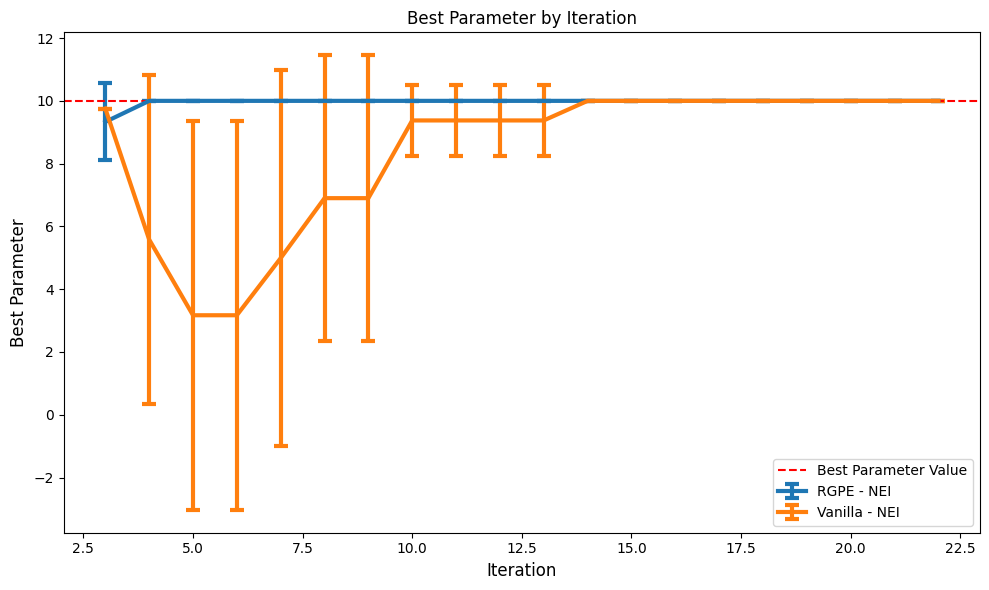

In [97]:
import numpy as np
import torch

# grid_size = 100
# # x1 = np.linspace(-5, 5, grid_size)
# # x2 = np.linspace(-5, 5, grid_size)
# # X1, X2 = np.meshgrid(x1, x2)
# # X = np.stack([X1.ravel(), X2.ravel()], axis=1)
# X = torch.linspace(BOUNDS[0][0], BOUNDS[1][0], grid_size)
# X_tensor = torch.tensor(X, dtype=torch.float64).unsqueeze(-1)

# # Evaluate the function on the grid
# Y = f(X_tensor)
# best_value = torch.max(Y[:, 0]).item()  # Find the maximum value of the first dimension

# Example data for plotting
# RANDOM_INITIALIZATION_SIZE = 5
# N_BATCH = 15
# N_TRIALS = 10

# import numpy as np
values = torch.linspace(BOUNDS[0][0], BOUNDS[1][0], 400).unsqueeze(-1)
Y = f(values)

weights = torch.tensor([0.5, 0.5])  # Example weights
alpha = 0.1  # Example alpha value

# Perform scalarization
product = weights * Y
scalarized_values = product.min(dim=-1).values + alpha * product.sum(dim=-1)

# Find the max scalarized value and its index
max_scalarized_value, max_index = scalarized_values.max(0)

# best_scalarized_rgpe_params_total = np.array(best_scalarized_rgpe_params_total).squeeze(-1)
# best_scalarized_vanilla_params_total = np.array(best_scalarized_vanilla_params_total).squeeze(-1)

x = range(RANDOM_INITIALIZATION_SIZE, RANDOM_INITIALIZATION_SIZE + N_BATCH)
print(x)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# Plot RGPE - NEI
ax.errorbar(
    x,
    best_scalarized_rgpe_params_total.mean(axis=0),
    yerr=1.96 * best_scalarized_rgpe_params_total.std(axis=0) / math.sqrt(N_TRIALS),
    label="RGPE - NEI",
    linewidth=3,
    capsize=5,
    capthick=3,
)
# Plot vanilla - NEI
ax.errorbar(
    x,
    best_scalarized_vanilla_params_total.mean(axis=0),
    yerr=1.96 * best_scalarized_vanilla_params_total.std(axis=0) / math.sqrt(N_TRIALS),
    label="Vanilla - NEI",
    linewidth=3,
    capsize=5,
    capthick=3,
)

best_param_value = values[max_index].item()
ax.axhline(y=best_param_value, color='red', linestyle='--', label='Best Parameter Value')

# ax.set_ylim(bottom=0)
ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Best Parameter", fontsize=12)
ax.set_title("Best Parameter by Iteration", fontsize=12)
ax.legend(loc="lower right", fontsize=10)
plt.tight_layout()

# Add a red line for the best value of the function (first dimension)
# ax.axhline(y=best_value, color='red', linestyle='--', label='Best Function Value (Objective 1)')

# ax.set_xlabel("Iteration", fontsize=12)
# ax.set_ylabel("Best Observed Value", fontsize=12)
# ax.set_title("Best Observed Value by Iteration - Objective 1", fontsize=12)
# ax.legend(loc="lower right", fontsize=10)
# plt.tight_layo
plt.show()

range(3, 23)


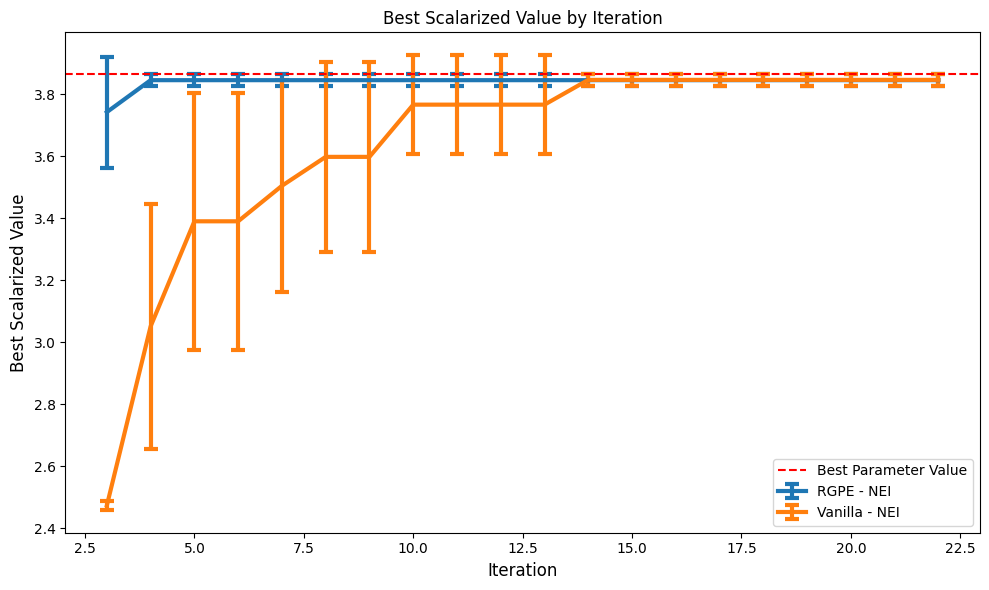

In [98]:
import numpy as np
import torch

# grid_size = 100
# # x1 = np.linspace(-5, 5, grid_size)
# # x2 = np.linspace(-5, 5, grid_size)
# # X1, X2 = np.meshgrid(x1, x2)
# # X = np.stack([X1.ravel(), X2.ravel()], axis=1)
# X = torch.linspace(BOUNDS[0][0], BOUNDS[1][0], grid_size)
# X_tensor = torch.tensor(X, dtype=torch.float64).unsqueeze(-1)

# # Evaluate the function on the grid
# Y = f(X_tensor)
# best_value = torch.max(Y[:, 0]).item()  # Find the maximum value of the first dimension

# Example data for plotting
# RANDOM_INITIALIZATION_SIZE = 5
# N_BATCH = 15
# N_TRIALS = 10

# import numpy as np

values = torch.linspace(BOUNDS[0][0], BOUNDS[1][0], 400).unsqueeze(-1)
Y = f(values)

weights = torch.tensor([0.5, 0.5])  # Example weights
alpha = 0.1  # Example alpha value

# Perform scalarization
product = weights * Y
scalarized_values = product.min(dim=-1).values + alpha * product.sum(dim=-1)

# Find the max scalarized value and its index
max_scalarized_value, max_index = scalarized_values.max(0)

best_scalarized_rgpe_values_total = np.array(best_scalarized_rgpe_values_total)
best_scalarized_vanilla_values_total = np.array(best_scalarized_vanilla_values_total)

x = range(RANDOM_INITIALIZATION_SIZE, RANDOM_INITIALIZATION_SIZE + N_BATCH)
print(x)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# Plot RGPE - NEI
ax.errorbar(
    x,
    best_scalarized_rgpe_values_total.mean(axis=0),
    yerr=1.96 * best_scalarized_rgpe_values_total.std(axis=0) / math.sqrt(N_TRIALS),
    label="RGPE - NEI",
    linewidth=3,
    capsize=5,
    capthick=3,
)
# Plot vanilla - NEI
ax.errorbar(
    x,
    best_scalarized_vanilla_values_total.mean(axis=0),
    yerr=1.96 * best_scalarized_vanilla_values_total.std(axis=0) / math.sqrt(N_TRIALS),
    label="Vanilla - NEI",
    linewidth=3,
    capsize=5,
    capthick=3,
)


ax.axhline(y=max_scalarized_value, color='red', linestyle='--', label='Best Parameter Value')

# ax.set_ylim(bottom=0)
ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Best Scalarized Value", fontsize=12)
ax.set_title("Best Scalarized Value by Iteration", fontsize=12)
ax.legend(loc="lower right", fontsize=10)
plt.tight_layout()

# Add a red line for the best value of the function (first dimension)
# ax.axhline(y=best_value, color='red', linestyle='--', label='Best Function Value (Objective 1)')

# ax.set_xlabel("Iteration", fontsize=12)
# ax.set_ylabel("Best Observed Value", fontsize=12)
# ax.set_title("Best Observed Value by Iteration - Objective 1", fontsize=12)
# ax.legend(loc="lower right", fontsize=10)
# plt.tight_layout()
plt.show()

In [52]:
print(np.array(mll_values_total).shape)

(0,)


## Plot log likelihood history

In [44]:
for i, mll_val in enumerate(mll_values_total):
    mll_val = np.array(mll_val)
    plt.figure(figsize=(10, 6))
    plt.plot(mll_val[:, 0])
    plt.xlabel('Iteration')
    plt.ylabel('Marginal Log Likelihood')
    plt.title(f'Exact Marginal Log Likelihood for trial {i + 1} for RGPE Objective 1')
    # plt.legend()
    plt.show()

    # mll_val = np.array(mll_val)
    plt.figure(figsize=(10, 6))
    plt.plot(mll_val[:, 1])
    plt.xlabel('Iteration')
    plt.ylabel('Marginal Log Likelihood')
    plt.title(f'Exact Marginal Log Likelihood for trial {i + 1} for RGPE Objective 1')
    # plt.legend()
    plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 1000x600 with 0 Axes>

In [ ]:
for i, mll_val in enumerate(mll_values_vanilla_total):
    mll_val = np.array(mll_val)
    plt.figure(figsize=(10, 6))
    plt.plot(mll_val[:, 0])
    plt.xlabel('Iteration')
    plt.ylabel('Marginal Log Likelihood')
    plt.title(f'Exact Marginal Log Likelihood for trial {i + 1} for Regular GP Objective 1')
    # plt.legend()
    plt.show()

    # mll_val = np.array(mll_val)
    plt.figure(figsize=(10, 6))
    plt.plot(mll_val[:, 1])
    plt.xlabel('Iteration')
    plt.ylabel('Marginal Log Likelihood')
    plt.title(f'Exact Marginal Log Likelihood for trial {i + 1} for Regular GP Objective 2')
    # plt.legend()
    plt.show()

## Plot hyperparameter history

In [ ]:
for hyperparameters_list in hyperparameters_total:
    lengthscales_1 = [item['lengthscale'][0].item() for item in hyperparameters_list]
    lengthscales_2 = [item['lengthscale'][1].item() for item in hyperparameters_list]
    outputscales_1 = [item['outputscale'][0].item() for item in hyperparameters_list]
    outputscales_2 = [item['outputscale'][1].item() for item in hyperparameters_list]
    average_noise_1 = [np.mean(item['noise'][0]) for item in hyperparameters_list]
    average_noise_2 = [np.mean(item['noise'][1]) for item in hyperparameters_list]
    # Plotting
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Lengthscale', color=color)
    ax1.plot(range(len(lengthscales_1)), lengthscales_1, 'o-', label='Lengthscale 1', color=color)
    ax1.plot(range(len(lengthscales_2)), lengthscales_2, 's-', label='Lengthscale 2', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Outputscale', color=color)
    ax2.plot(range(len(outputscales_1)), outputscales_1, 'o-', label='Outputscale 1', color=color)
    ax2.plot(range(len(outputscales_2)), outputscales_2, 's-', label='Outputscale 2', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    ax3 = ax1.twinx()
    color = 'tab:green'
    ax3.spines['right'].set_position(('outward', 60))
    ax3.set_ylabel('Average Noise', color=color)
    ax3.plot(range(len(average_noise_1)), average_noise_1, '^-', label='Average Noise 1', color=color)
    ax3.plot(range(len(average_noise_2)), average_noise_2, 's-', label='Average Noise 2', color=color)
    ax3.tick_params(axis='y', labelcolor=color)
    ax3.legend(loc='lower right')

    fig.tight_layout()
    plt.title('Hyperparameters Plot for RGPE')
    plt.show()

In [ ]:
for hyperparameters_vanilla_list in hyperparameters_vanilla_total:    
    lengthscales_1 = [item['lengthscale'][0].item() for item in hyperparameters_vanilla_list]
    lengthscales_2 = [item['lengthscale'][1].item() for item in hyperparameters_vanilla_list]
    outputscales_1 = [item['outputscale'][0].item() for item in hyperparameters_vanilla_list]
    outputscales_2 = [item['outputscale'][1].item() for item in hyperparameters_vanilla_list]
    average_noise_1 = [np.mean(item['noise'][0]) for item in hyperparameters_vanilla_list]
    average_noise_2 = [np.mean(item['noise'][1]) for item in hyperparameters_vanilla_list]
    # Plotting
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Lengthscale', color=color)
    ax1.plot(range(len(lengthscales_1)), lengthscales_1, 'o-', label='Lengthscale 1', color=color)
    ax1.plot(range(len(lengthscales_2)), lengthscales_2, 's-', label='Lengthscale 2', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Outputscale', color=color)
    ax2.plot(range(len(outputscales_1)), outputscales_1, 'o-', label='Outputscale 1', color=color)
    ax2.plot(range(len(outputscales_2)), outputscales_2, 's-', label='Outputscale 2', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    ax3 = ax1.twinx()
    color = 'tab:green'
    ax3.spines['right'].set_position(('outward', 60))
    ax3.set_ylabel('Average Noise', color=color)
    ax3.plot(range(len(average_noise_1)), average_noise_1, '^-', label='Average Noise 1', color=color)
    ax3.plot(range(len(average_noise_2)), average_noise_2, 's-', label='Average Noise 2', color=color)
    ax3.tick_params(axis='y', labelcolor=color)
    ax3.legend(loc='lower right')

    fig.tight_layout()
    plt.title('Hyperparameters Plot for Regular GP')
    plt.show()

## Plot best observed value versus iteration

In [55]:
print(best_vanilla_nei_all_1.shape)

(0,)


range(3, 23)


C:\Users\visha\AppData\Local\Temp\ipykernel_24252\1370694501.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float64).unsqueeze(-1)


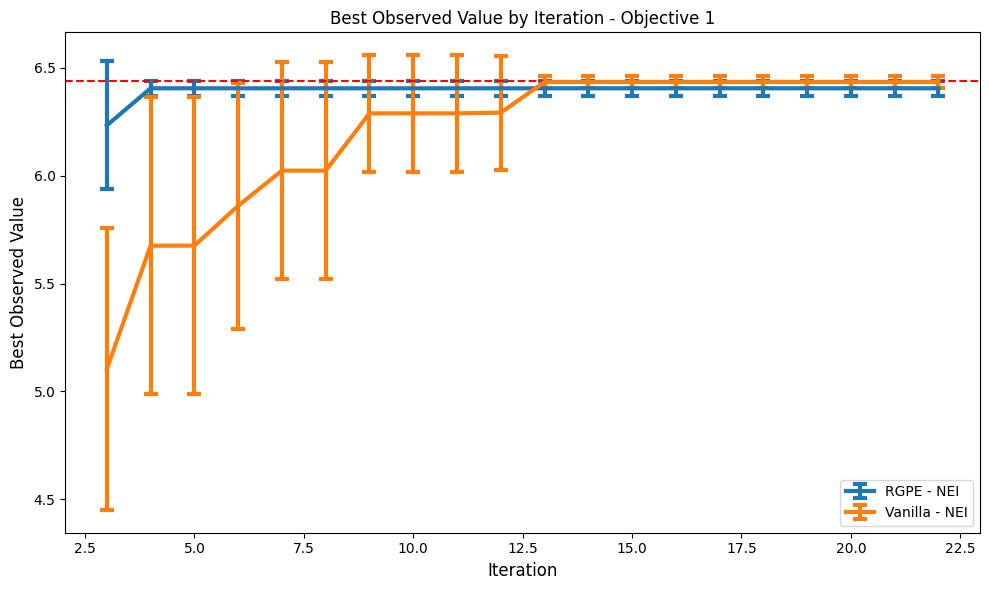

In [99]:
import numpy as np
import torch

grid_size = 100
# x1 = np.linspace(-5, 5, grid_size)
# x2 = np.linspace(-5, 5, grid_size)
# X1, X2 = np.meshgrid(x1, x2)
# X = np.stack([X1.ravel(), X2.ravel()], axis=1)
X = torch.linspace(BOUNDS[0][0], BOUNDS[1][0], grid_size)
X_tensor = torch.tensor(X, dtype=torch.float64).unsqueeze(-1)

# Evaluate the function on the grid
Y = f(X_tensor)
best_value = torch.max(Y[:, 0]).item()  # Find the maximum value of the first dimension

# Example data for plotting
# RANDOM_INITIALIZATION_SIZE = 5
# N_BATCH = 15
# N_TRIALS = 10

# import numpy as np

best_rgpe_all_1 = np.array(best_rgpe_all_1)
best_vanilla_nei_all_1 = np.array(best_vanilla_nei_all_1)

x = range(RANDOM_INITIALIZATION_SIZE, RANDOM_INITIALIZATION_SIZE + N_BATCH)
print(x)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# Plot RGPE - NEI
ax.errorbar(
    x,
    best_rgpe_all_1.mean(axis=0),
    yerr=1.96 * best_rgpe_all_1.std(axis=0) / math.sqrt(N_TRIALS),
    label="RGPE - NEI",
    linewidth=3,
    capsize=5,
    capthick=3,
)
# Plot vanilla - NEI
ax.errorbar(
    x,
    best_vanilla_nei_all_1.mean(axis=0),
    yerr=1.96 * best_vanilla_nei_all_1.std(axis=0) / math.sqrt(N_TRIALS),
    label="Vanilla - NEI",
    linewidth=3,
    capsize=5,
    capthick=3,
)

# ax.set_ylim(bottom=0)
ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Best Observed Value", fontsize=12)
ax.set_title("Best Observed Value by Iteration - Objective 1", fontsize=12)
ax.legend(loc="lower right", fontsize=10)
plt.tight_layout()

# Add a red line for the best value of the function (first dimension)
ax.axhline(y=best_value, color='red', linestyle='--', label='Best Function Value (Objective 1)')

# ax.set_xlabel("Iteration", fontsize=12)
# ax.set_ylabel("Best Observed Value", fontsize=12)
# ax.set_title("Best Observed Value by Iteration - Objective 1", fontsize=12)
# ax.legend(loc="lower right", fontsize=10)
# plt.tight_layout()
plt.show()

range(3, 23)


C:\Users\visha\AppData\Local\Temp\ipykernel_24252\3086994862.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float64).unsqueeze(-1)


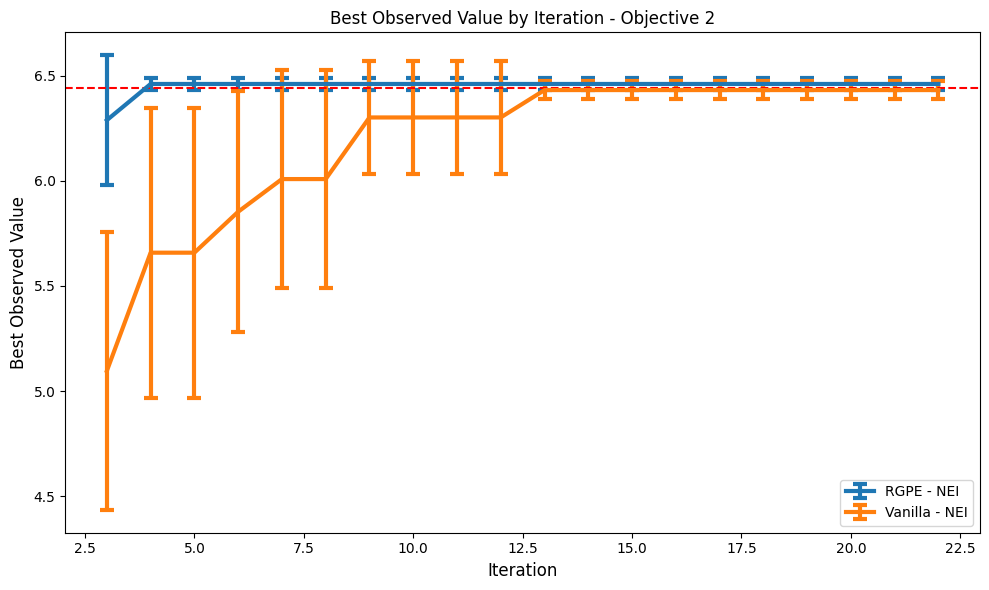

In [100]:
import numpy as np
import torch

grid_size = 100
# x1 = np.linspace(-5, 5, grid_size)
# x2 = np.linspace(-5, 5, grid_size)
# X1, X2 = np.meshgrid(x1, x2)
# X = np.stack([X1.ravel(), X2.ravel()], axis=1)
X = torch.linspace(BOUNDS[0][0], BOUNDS[1][0], grid_size)
X_tensor = torch.tensor(X, dtype=torch.float64).unsqueeze(-1)

# Evaluate the function on the grid
Y = f(X_tensor)
best_value = torch.max(Y[:, 1]).item()  # Find the maximum value of the first dimension

# Example data for plotting
# RANDOM_INITIALIZATION_SIZE = 5
# N_BATCH = 15
# N_TRIALS = 10

# import numpy as np

best_rgpe_all_2 = np.array(best_rgpe_all_2)
best_vanilla_nei_all_2 = np.array(best_vanilla_nei_all_2)

x = range(RANDOM_INITIALIZATION_SIZE, RANDOM_INITIALIZATION_SIZE + N_BATCH)
print(x)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# Plot RGPE - NEI
ax.errorbar(
    x,
    best_rgpe_all_2.mean(axis=0),
    yerr=1.96 * best_rgpe_all_2.std(axis=0) / math.sqrt(N_TRIALS),
    label="RGPE - NEI",
    linewidth=3,
    capsize=5,
    capthick=3,
)
# Plot vanilla - NEI
ax.errorbar(
    x,
    best_vanilla_nei_all_2.mean(axis=0),
    yerr=1.96 * best_vanilla_nei_all_2.std(axis=0) / math.sqrt(N_TRIALS),
    label="Vanilla - NEI",
    linewidth=3,
    capsize=5,
    capthick=3,
)

# ax.set_ylim(bottom=0)
ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Best Observed Value", fontsize=12)
ax.set_title("Best Observed Value by Iteration - Objective 2", fontsize=12)
ax.legend(loc="lower right", fontsize=10)
plt.tight_layout()

# Add a red line for the best value of the function (first dimension)
ax.axhline(y=best_value, color='red', linestyle='--', label='Best Function Value (Objective 2)')

# ax.set_xlabel("Iteration", fontsize=12)
# ax.set_ylabel("Best Observed Value", fontsize=12)
# ax.set_title("Best Observed Value by Iteration - Objective 1", fontsize=12)
# ax.legend(loc="lower right", fontsize=10)
# plt.tight_layout()
plt.show()

# # Plot model weights versus iterations

In [33]:
print(rank_weights_all_1)

[[tensor([0.0000, 0.0000, 0.0039, 0.0000, 0.0000], dtype=torch.float64), tensor([0.0039, 0.0000, 0.0000, 0.0000, 0.0000], dtype=torch.float64), tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0039], dtype=torch.float64), tensor([0.0039, 0.0000, 0.0000, 0.0000, 0.0000], dtype=torch.float64), tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0039], dtype=torch.float64), tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0039], dtype=torch.float64), tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0039], dtype=torch.float64), tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0039], dtype=torch.float64), tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0039], dtype=torch.float64), tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0039], dtype=torch.float64)], [tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0039], dtype=torch.float64), tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0039], dtype=torch.float64), tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0039], dtype=torch.float64), tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0039], dtype=torch.float64), te

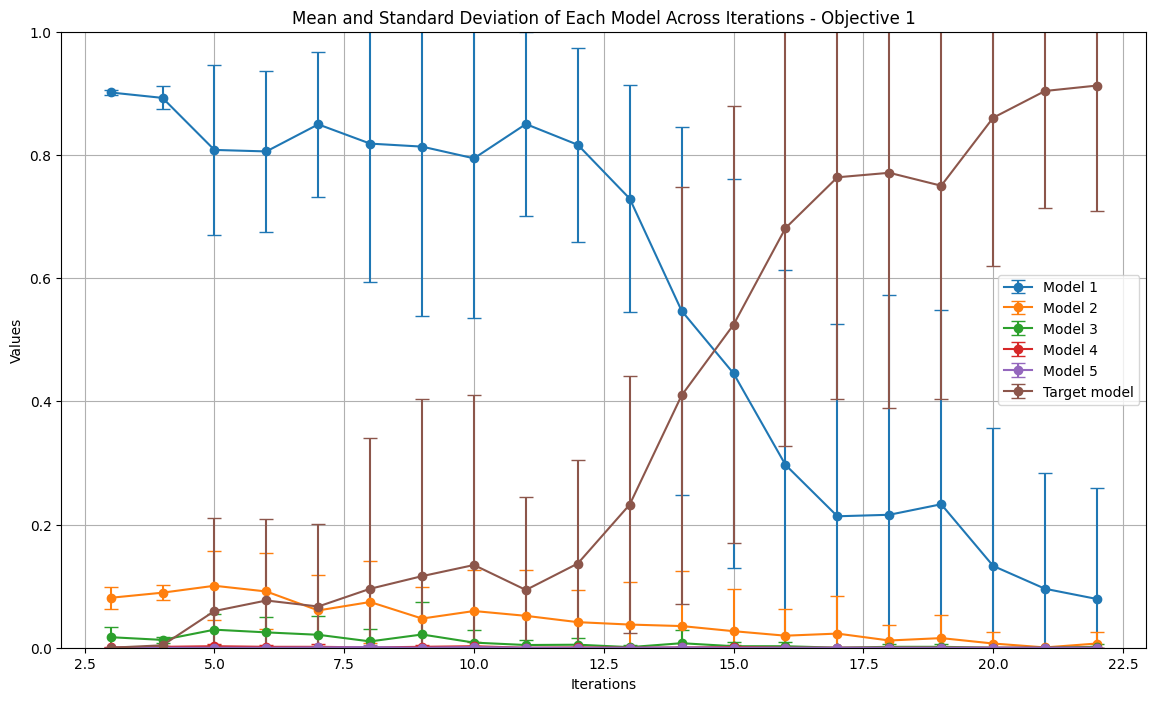

In [89]:
import torch
import matplotlib.pyplot as plt

# Given list of tensors

tensor_list=rank_weights_all_1

def extract_all_columns_mean_std(tensor_list):
    # Determine the number of columns
    num_columns = len(tensor_list[0][0])
    
    # Initialize lists to hold mean and std tensors for each column
    means = []
    stds = []
    
    for column_index in range(num_columns):
        # Extract the specified column from each tensor in each element of the tensor list
        columns = [torch.tensor([t[column_index] for t in element], dtype=torch.float64) for element in tensor_list]
        
        # Stack columns to create a 2D tensor
        stacked_columns = torch.stack(columns)
        
        # Calculate the mean element-wise
        mean_tensor = torch.mean(stacked_columns, dim=0)
        
        # Calculate the standard deviation element-wise
        std_tensor = torch.std(stacked_columns, dim=0)
        
        # Append to the lists
        means.append(mean_tensor)
        stds.append(std_tensor)
    
    return means, stds

# Calculate mean and standard deviation for all columns
means, stds = extract_all_columns_mean_std(tensor_list)

plt.figure(figsize=(14, 8))

for i, (mean_tensor, std_tensor) in enumerate(zip(means, stds)):
    label = f'Model {i+1}' if i < len(means) - 1 else 'Target model'
    plt.errorbar(x, mean_tensor.numpy(), yerr=std_tensor.numpy(), 
                 label=label, marker='o', capsize=5)

plt.xlabel('Iterations')
plt.ylabel('Values')
plt.title('Mean and Standard Deviation of Each Model Across Iterations - Objective 1')
plt.legend()
plt.grid(True)
plt.ylim(0.0, 1.0)
plt.show()

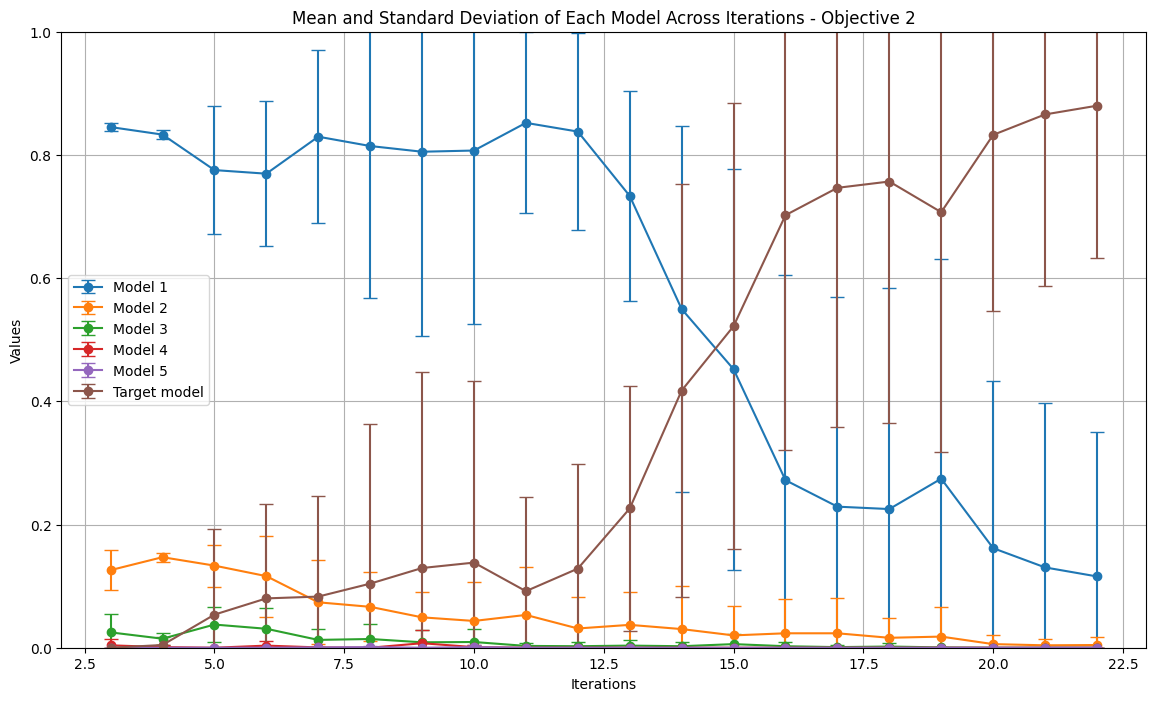

In [90]:
import torch
import matplotlib.pyplot as plt

# Given list of tensors

tensor_list=rank_weights_all_2

def extract_all_columns_mean_std(tensor_list):
    # Determine the number of columns
    num_columns = len(tensor_list[0][0])
    
    # Initialize lists to hold mean and std tensors for each column
    means = []
    stds = []
    
    for column_index in range(num_columns):
        # Extract the specified column from each tensor in each element of the tensor list
        columns = [torch.tensor([t[column_index] for t in element], dtype=torch.float64) for element in tensor_list]
        
        # Stack columns to create a 2D tensor
        stacked_columns = torch.stack(columns)
        
        # Calculate the mean element-wise
        mean_tensor = torch.mean(stacked_columns, dim=0)
        
        # Calculate the standard deviation element-wise
        std_tensor = torch.std(stacked_columns, dim=0)
        
        # Append to the lists
        means.append(mean_tensor)
        stds.append(std_tensor)
    
    return means, stds

# Calculate mean and standard deviation for all columns
means, stds = extract_all_columns_mean_std(tensor_list)

plt.figure(figsize=(14, 8))

for i, (mean_tensor, std_tensor) in enumerate(zip(means, stds)):
    label = f'Model {i+1}' if i < len(means) - 1 else 'Target model'
    plt.errorbar(x, mean_tensor.numpy(), yerr=std_tensor.numpy(), 
                 label=label, marker='o', capsize=5)

plt.xlabel('Iterations')
plt.ylabel('Values')
plt.title('Mean and Standard Deviation of Each Model Across Iterations - Objective 2')
plt.legend()
plt.grid(True)
plt.ylim(0.0, 1.0)
plt.show()

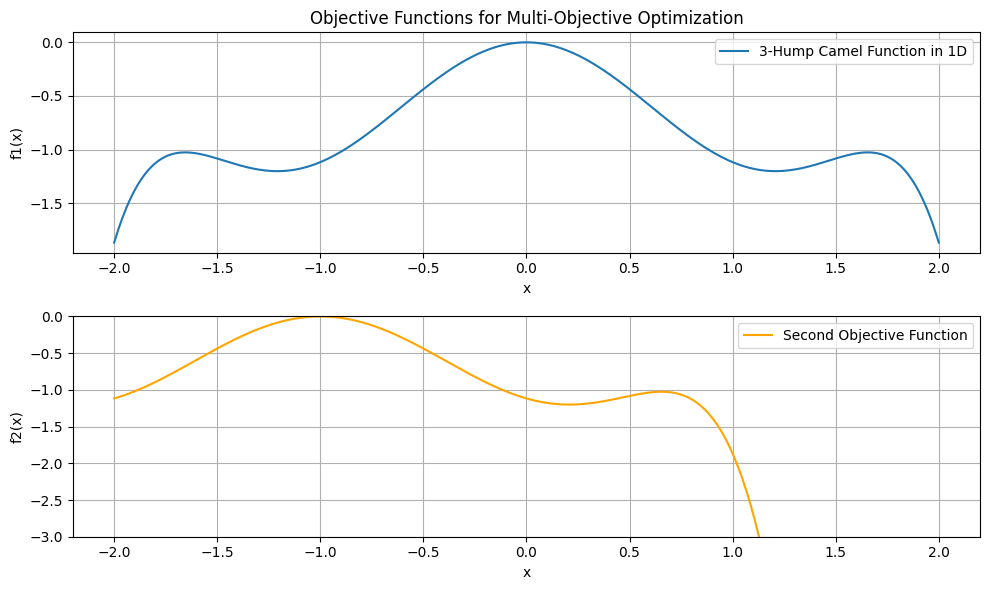

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def three_hump_camel_1d(x):
    return -(2 * x**2 - 1.05 * x**4 + (x**6) / 6)

def second_objective(x):
    return -(2 * (x + 1)**2 - 1.05 * (x + 1)**4 + ((x + 1)**6) / 6)

# Generate x values
x = np.linspace(-2, 2, 400)

# Calculate y values for both functions
y1 = three_hump_camel_1d(x)
y2 = second_objective(x)

# Plotting the functions
plt.figure(figsize=(10, 6))

# Plot for the first objective
plt.subplot(2, 1, 1)
plt.plot(x, y1, label="3-Hump Camel Function in 1D")
plt.title("Objective Functions for Multi-Objective Optimization")
plt.xlabel("x")
plt.ylabel("f1(x)")
plt.legend()
# plt.xlim([-10,10])
plt.grid(True)

# Plot for the second objective
plt.subplot(2, 1, 2)
plt.plot(x, y2, label="Second Objective Function", color="orange")
plt.xlabel("x")
plt.ylabel("f2(x)")
plt.legend()
plt.grid(True)
plt.ylim([-3, 0])
plt.tight_layout()
plt.show()

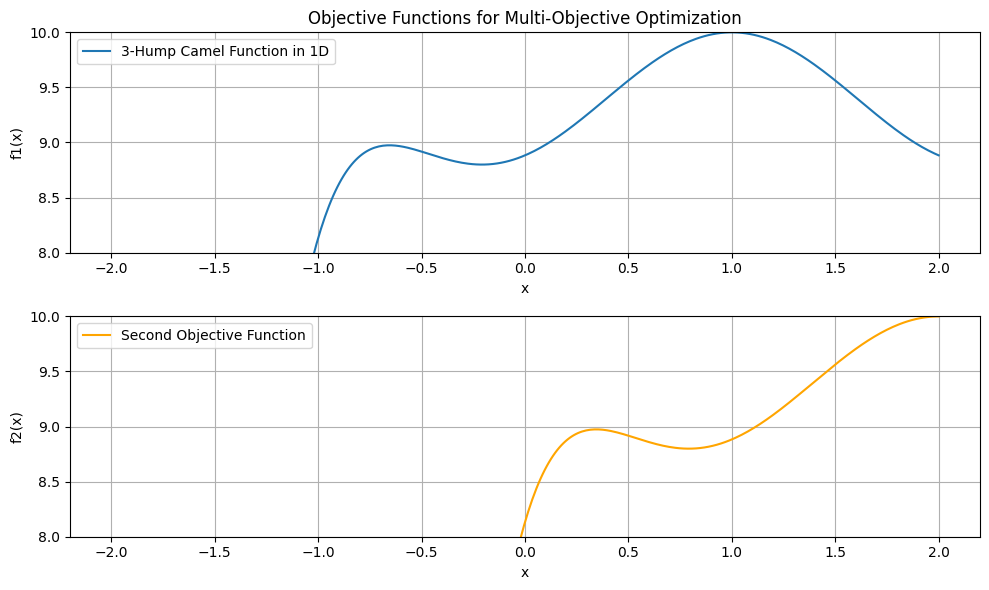

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def three_hump_camel_1d(x):
    return (-(2 * (x-1)**2 - 1.05 * (x-1)**4 + ((x-1)**6) / 6)) + 10

def second_objective(x):
    return (-(2 * (x-2)**2 - 1.05 * (x-2)**4 + ((x-2)**6) / 6)) + 10

# Generate x values
x = np.linspace(-2, 2, 400)

# Calculate y values for both functions
y1 = three_hump_camel_1d(x)
y2 = second_objective(x)

# Plotting the functions
plt.figure(figsize=(10, 6))

# Plot for the first objective
plt.subplot(2, 1, 1)
plt.plot(x, y1, label="3-Hump Camel Function in 1D")
plt.title("Objective Functions for Multi-Objective Optimization")
plt.xlabel("x")
plt.ylabel("f1(x)")
plt.legend()
plt.ylim([8, 10])
plt.grid(True)

# Plot for the second objective
plt.subplot(2, 1, 2)
plt.plot(x, y2, label="Second Objective Function", color="orange")
plt.xlabel("x")
plt.ylabel("f2(x)")
plt.legend()
plt.grid(True)
plt.ylim([8, 10])
plt.tight_layout()
plt.show()

In [20]:
import os
import torch
import pandas as pd
from botorch.models import FixedNoiseGP, ModelListGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler

noise_std = 0.05

def create_base_models(base_model_path, x_dim, all_positive: bool = False):
    base_model_list = []
    num_objectives = None
    target_models = []

    for i in os.listdir(base_model_path):
        if i == 'target_model':
            with open(base_model_path + "/" + i + "/data.csv") as f:
                data = pd.read_csv(f, sep='\s+', header=None)
            x_df = data.iloc[:, :x_dim]
            y_df = data.iloc[:, x_dim:]

            # Normalize x_df
            x_scaler = MinMaxScaler()
            x_df = pd.DataFrame(x_scaler.fit_transform(x_df))

            # Standardize y_df
            y_scaler = StandardScaler()
            y_df = pd.DataFrame(y_scaler.fit_transform(y_df))

            print(f'x_df: {x_df}')
            x = torch.tensor(x_df.values, dtype=torch.float64)
            y = torch.tensor(y_df.values, dtype=torch.float64)
            print(f'x: {x.shape}, y: {y.shape}')
            if all_positive:
                if any(y < 0):
                    y = -y
            print(x.shape, y.shape)
            print(y)
            if num_objectives is None:
                num_objectives = y.shape[-1]
                base_model_list = [[] for _ in range(num_objectives)]

            for obj_index in range(num_objectives):
                train_yvar = torch.full_like(y[:, obj_index], noise_std**2).unsqueeze(-1)
                
                model = FixedNoiseGP(x, y[:, obj_index].unsqueeze(-1), train_Yvar=train_yvar)
                model.Y_mean = y[:, obj_index].mean(dim=0, keepdim=True)
                model.Y_std = y[:, obj_index].std(dim=0, keepdim=True)
                mll = ExactMarginalLogLikelihood(model.likelihood, model)
                fit_gpytorch_mll(mll)
                target_models.append(model)

            # Creating a Model List GP for target models
            target_model_list_gp = ModelListGP(*target_models)
            base_model_list.append(target_model_list_gp)

        else:
            with open(base_model_path + "/" + i + "/data.csv") as f:
                data = pd.read_csv(f, sep='\s+', header=None)
            x_df = data.iloc[:, :x_dim]
            y_df = data.iloc[:, x_dim:]

            # Normalize x_df
            x_scaler = MinMaxScaler()
            x_df = pd.DataFrame(x_scaler.fit_transform(x_df))

            # Standardize y_df
            y_scaler = StandardScaler()
            y_df = pd.DataFrame(y_scaler.fit_transform(y_df))

            print(f'x_df: {x_df}')
            x = torch.tensor(x_df.values, dtype=torch.float64)
            y = torch.tensor(y_df.values, dtype=torch.float64)
            print(f'x: {x.shape}, y: {y.shape}')
            if all_positive:
                if any(y < 0):
                    y = -y
            print(x.shape, y.shape)
            print(y)
            if num_objectives is None:
                num_objectives = y.shape[-1]
                base_model_list = [[] for _ in range(num_objectives)]

            for obj_index in range(num_objectives):
                train_yvar = torch.full_like(y[:, obj_index], noise_std**2).unsqueeze(-1)
                model = FixedNoiseGP(x, y[:, obj_index].unsqueeze(-1), train_Yvar=train_yvar)
                model.Y_mean = y[:, obj_index].mean(dim=0, keepdim=True)
                model.Y_std = y[:, obj_index].std(dim=0, keepdim=True)
                mll = ExactMarginalLogLikelihood(model.likelihood, model)
                fit_gpytorch_mll(mll)
                base_model_list[obj_index].append(model)

    return base_model_list, target_models

<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:62: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:62: SyntaxWarning: invalid escape sequence '\s'
C:\Users\visha\AppData\Local\Temp\ipykernel_4848\2650669363.py:21: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(f, sep='\s+', header=None)
C:\Users\visha\AppData\Local\Temp\ipykernel_4848\2650669363.py:62: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(f, sep='\s+', header=None)


In [21]:
base_models, target_models = create_base_models('C:/GitHub/HIL_toolkit_ARL/base_models', 2)
print(base_models)

x_df:            0         1
0   0.365265  0.000000
1   1.000000  0.756242
2   0.000000  0.377476
3   0.333640  0.311127
4   0.287091  0.510642
5   0.654581  0.441112
6   0.806225  0.780079
7   0.785179  1.000000
8   0.704488  0.868402
9   0.371928  0.862155
10  0.384729  0.113577
11  0.539928  0.491796
12  0.406304  0.268453
13  0.208748  0.514706
14  0.551833  0.679567
x: torch.Size([15, 2]), y: torch.Size([15, 1])
torch.Size([15, 2]) torch.Size([15, 1])
tensor([[ 0.1682],
        [-2.3599],
        [ 1.6388],
        [ 0.7429],
        [ 0.1469],
        [-0.0572],
        [-1.7975],
        [ 0.6777],
        [-0.4215],
        [ 0.1840],
        [ 0.8084],
        [-0.2109],
        [-0.2726],
        [-0.3927],
        [ 1.1453]], dtype=torch.float64)
x_df:            0         1
0   0.530354  0.221597
1   0.229311  0.050286
2   0.489104  0.000000
3   0.753627  0.511729
4   0.183626  0.419798
5   0.224062  0.451133
6   0.541286  0.520527
7   0.736801  0.917183
8   1.000000  1.000

c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0351], dtype=torch.float64), mean = tensor([-1.1842e-16], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0351], dtype=torch.float64), mean = tensor([2.0724e-16], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0351], dtype=torch.float64), mean = tensor([-7.4015e-17], dtype=to